In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import exp, abs, log
from scipy.special import gamma, factorial
import os
import scipy.stats as stats
import statsmodels.api as sm
from utils import *
import time
import datetime as dt
import universal as up
from universal import tools, algos
from universal.algos import *

np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)
np.set_printoptions(threshold=np.inf)

In [2]:
def get_res(path, phase, maxiter, subn, lb):
    data_path1 = path%(phase, maxiter, subn, lb)
    print(data_path1)
    data1 = np.load(data_path1)
    return data1['predY0'], data1['std_varY0'], data1['val_predY0'], data1['val_std_varY0'], data1['sample_Y0']

def ucb_strategy(lam, predY0, std_varY0, sample_Y0):
    rt_v = []
    ninvest = 10

    for i in range(len(predY0)):
        p = predY0[i]
        sell_idx = np.argsort(p-lam*std_varY0[i])[:ninvest//2]
        buy_idx = np.argsort(-(p+lam*std_varY0[i]))[:ninvest//2]
        rr = 1/ninvest
        tmp = rr*(sum(exp(sample_Y0[i, buy_idx]))+sum(exp(-sample_Y0[i, sell_idx])))
        rt_v.append(log(tmp))
    return rt_v


def opt_strategy(predY0, std_var_Y0, sample_Y0, cov, gamma, c, cash=1.0):
    rt_v = []
    x_ori = np.ones(len(predY0[0])) / len(predY0[0])
    for i in range(len(predY0)):
        r = exp(predY0[i])
        cov_dia = std_var_Y0[i] ** 2 * r * r
#          cov_current = np.zeros_like(cov)
        cov_current = cov.copy()
        for k in range(len(r)):
            cov_current[k, k] = cov_dia[k]
        # x_opt = solve(len(r), r, cov_current, delta, cash)
        
        u_opt = solve_u(len(r), x_ori, r, cov_current, gamma0=gamma, c=c)
        x_opt = x_ori + u_opt
        
#         u_opt = solve_sharpratio(len(r), x_ori, r, 1, cov_current)
#         x_opt = x_ori + u_opt
        
        print(x_opt)
#         print(sum(x_opt))
#         print(sample_Y0[i])
#         print(sum(x_opt * exp(sample_Y0[i])))
#         print(predY0[i])
#         time.sleep(10000)
        
        tmp = sum(x_opt * exp(sample_Y0[i])) / cash
        rt_v.append(log(tmp))
        
        x_ori = x_opt
    return rt_v


def max_redraw(rt_v):
    res = max([rt_v[i] - min(rt_v[i+1:]) for i in range(len(rt_v)-1)])
    return res

testv = np.arange(-0.1, 0.10001, 0.01)


def run(path, maxiter, subn, lb, figsize=(10,5), testv=testv, gamma=1.0, c=0.0):
    rt_lst, rd_lst, naive_lst, opt_lst = [], [], [], []
    for phs in range(4, 12):
        print('Phase %d' % phs)
        data_path = './stock_data/stock_phase%02d_lb%d.npz' % (phs, lb)
        data = np.load(data_path)
        cov_train, choice = data['cov_train'], data['choice']
        cov = cov_train[choice[:subn], :][:, choice[:subn]]

        print('Validating...')
        plt.figure(figsize=figsize)
        _, _, predY0, std_varY0, sample_Y0 = get_res(path, phs, maxiter, subn, lb)

        print('Opt strategy')
        rt_v = opt_strategy(predY0, std_varY0, sample_Y0, cov, gamma, c)
        rd = max_redraw(rt_v)
        print('Opt strategy   Total log return: %.8f    Max redraw: %.8f' % (sum(rt_v), rd))
        print('Total return: %.8f' % exp(sum(rt_v)))
        print('Mean return: %.8f' % exp(np.mean(rt_v)))
        exp_rt = rt_v.copy()
        for i in range(1, len(rt_v)):
            exp_rt[i] += exp_rt[i-1]
        exp_rt = exp(exp_rt)
        plt.plot(exp_rt, 'r-', label='Opt strategy')

        print('UCB strategy')
        best_logrt = -np.inf
        best_rt_lam = 0
        best_rd = np.inf
        best_rd_lam = 0
        for lam in testv:
            rt_v=ucb_strategy(lam, predY0, std_varY0, sample_Y0)
            rd = max_redraw(rt_v)
            print('lambda: %.3f   Total log return: %.8f    Max redraw: %.8f' % (lam, sum(rt_v), rd))
            if sum(rt_v)>best_logrt:
                best_logrt=sum(rt_v)
                best_rt_lam=lam
            if rd<best_rd:
                best_rd=rd
                best_rd_lam=lam
            exp_rt=rt_v
            for i in range(1, len(rt_v)):
                exp_rt[i]+=exp_rt[i-1]
            exp_rt = exp(exp_rt)
            plt.plot(exp_rt, color='gray', linewidth=0.2)
        rt_v=ucb_strategy(best_rt_lam, predY0, std_varY0, sample_Y0)
        print('best return lambda: %.3f   Total log return: %.8f' % (best_rt_lam, sum(rt_v)))
        print('Total return: %.8f' % exp(sum(rt_v)))
        print('Mean return: %.8f' % exp(np.mean(rt_v)))
        exp_rt=rt_v.copy()
        for i in range(1, len(rt_v)):
            exp_rt[i]+=exp_rt[i-1]
        exp_rt = exp(exp_rt)
        plt.plot(exp_rt, 'b-', label='best return, lambda=%.3f'%best_rt_lam)
        rt_v=ucb_strategy(best_rd_lam, predY0, std_varY0, sample_Y0)
        print('best redraw lambda: %.3f   Total log return: %.8f' % (best_rd_lam, sum(rt_v)))
        print('Total return: %.8f' % exp(sum(rt_v)))
        print('Mean return: %.8f' % exp(np.mean(rt_v)))
        exp_rt=rt_v.copy()
        for i in range(1, len(rt_v)):
            exp_rt[i]+=exp_rt[i-1]
        exp_rt = exp(exp_rt)
        plt.plot(exp_rt, 'g-', label='best redraw, lambda=%.3f'%best_rd_lam)
        rt_v=ucb_strategy(0, predY0, std_varY0, sample_Y0)
        print('Naive lambda: %.3f   Total log return: %.8f' % (0, sum(rt_v)))
        print('Total return: %.8f' % exp(sum(rt_v)))
        print('Mean return: %.8f' % exp(np.mean(rt_v)))
        exp_rt=rt_v.copy()
        for i in range(1, len(rt_v)):
            exp_rt[i]+=exp_rt[i-1]
        exp_rt = exp(exp_rt)
        plt.plot(exp_rt, 'y-', label='Naive, lambda=%.3f'%0)
        plt.title('Validation UCB');    plt.grid();    plt.legend();    plt.show()
        val_best_rt_lam = best_rt_lam
        val_best_rd_lam = best_rd_lam



        print('Testing...')
        plt.figure(figsize=figsize)
        predY0, std_varY0, _, _, sample_Y0 = get_res(path, phs, maxiter, subn, lb)

        print('UCB strategy')
        best_logrt = -np.inf
        best_rt_lam = 0
        best_rd = np.inf
        best_rd_lam = 0

        for lam in testv:
            rt_v=ucb_strategy(lam, predY0, std_varY0, sample_Y0)
            rd = max_redraw(rt_v)
            print('lambda: %.3f   Total log return: %.8f    Max redraw: %.8f' % (lam, sum(rt_v), rd))
            if sum(rt_v)>best_logrt:
                best_logrt=sum(rt_v)
                best_rt_lam=lam
            if rd<best_rd:
                best_rd=rd
                best_rd_lam=lam
            exp_rt=rt_v
            for i in range(1, len(rt_v)):
                exp_rt[i]+=exp_rt[i-1]
            exp_rt = exp(exp_rt)
            plt.plot(exp_rt, color='gray', linewidth=0.2)
        rt_v=ucb_strategy(best_rt_lam, predY0, std_varY0, sample_Y0)
        print('best return lambda: %.3f   Total log return: %.8f' % (best_rt_lam, sum(rt_v)))
        print('Total return: %.8f' % exp(sum(rt_v)))
        print('Mean return: %.8f' % exp(np.mean(rt_v)))
        exp_rt=rt_v.copy()
        for i in range(1, len(rt_v)):
            exp_rt[i]+=exp_rt[i-1]
        exp_rt = exp(exp_rt)
        plt.plot(exp_rt, 'b--', label='best return, lambda=%.3f'%best_rt_lam, linewidth=0.2)
        rt_v=ucb_strategy(best_rd_lam, predY0, std_varY0, sample_Y0)
        print('best redraw lambda: %.3f   Total log return: %.8f' % (best_rd_lam, sum(rt_v)))
        print('Total return: %.8f' % exp(sum(rt_v)))
        print('Mean return: %.8f' % exp(np.mean(rt_v)))
        exp_rt=rt_v.copy()
        for i in range(1, len(rt_v)):
            exp_rt[i]+=exp_rt[i-1]
        exp_rt = exp(exp_rt)
        plt.plot(exp_rt, 'g--', label='best redraw, lambda=%.3f'%best_rd_lam, linewidth=0.2)

        print('------------------------------------------------------------------------------------')

        print('Opt strategy')
        rt_v = opt_strategy(predY0, std_varY0, sample_Y0, cov, gamma, c)
        opt_lst += rt_v.copy()
        print('Opt strategy   Total log return: %.8f    Max redraw: %.8f' % (sum(rt_v), rd))
        print('Total return: %.8f' % exp(sum(rt_v)))
        print('Mean return: %.8f' % exp(np.mean(rt_v)))
        exp_rt = rt_v.copy()
        for i in range(1, len(rt_v)):
            exp_rt[i] += exp_rt[i-1]
        exp_rt = exp(exp_rt)
        plt.plot(exp_rt, 'r', label='Opt strategy')

        rt_v=ucb_strategy(val_best_rt_lam, predY0, std_varY0, sample_Y0)
        rt_lst += rt_v.copy()
        print('best return val lambda: %.3f   Total log return: %.8f' % (best_rt_lam, sum(rt_v)))
        print('Total return: %.8f' % exp(sum(rt_v)))
        print('Mean return: %.8f' % exp(np.mean(rt_v)))
        exp_rt=rt_v.copy()
        for i in range(1, len(rt_v)):
            exp_rt[i]+=exp_rt[i-1]
        exp_rt = exp(exp_rt)
        plt.plot(exp_rt, 'b', label='best return, val lambda=%.3f'%val_best_rt_lam)
        rt_v=ucb_strategy(best_rd_lam, predY0, std_varY0, sample_Y0)
        rd_lst += rt_v.copy()
        print('best redraw val lambda: %.3f   Total log return: %.8f' % (val_best_rd_lam, sum(rt_v)))
        print('Total return: %.8f' % exp(sum(rt_v)))
        print('Mean return: %.8f' % exp(np.mean(rt_v)))
        exp_rt=rt_v.copy()
        for i in range(1, len(rt_v)):
            exp_rt[i]+=exp_rt[i-1]
        exp_rt = exp(exp_rt)
        plt.plot(exp_rt, 'g', label='best redraw, val lambda=%.3f'%val_best_rd_lam)
        rt_v=ucb_strategy(0, predY0, std_varY0, sample_Y0)
        naive_lst += rt_v.copy()
        print('Naive lambda: %.3f   Total log return: %.8f' % (0, sum(rt_v)))
        print('Total return: %.8f' % exp(sum(rt_v)))
        print('Mean return: %.8f' % exp(np.mean(rt_v)))
        exp_rt=rt_v.copy()
        for i in range(1, len(rt_v)):
            exp_rt[i]+=exp_rt[i-1]
        exp_rt = exp(exp_rt)
        plt.plot(exp_rt, 'y-', label='Naive, lambda=%.3f'%0)
        plt.title('Test UCB');    plt.grid();    plt.legend();    plt.show()
    print('-----------------------------Final result-----------------------------')
    plt.figure(figsize=figsize)
    rt_v = opt_lst
    print('Opt strategy')
    print('Total return: %.8f' % exp(sum(rt_v)))
    print('Mean return: %.8f' % exp(np.mean(rt_v)))
    exp_rt = rt_v.copy()
    for i in range(1, len(rt_v)):
        exp_rt[i] += exp_rt[i-1]
    exp_rt = exp(exp_rt)
    plt.plot(exp_rt, 'r', label='Opt strategy')

    rt_v=rt_lst
    print('best return strategy')
    print('Total return: %.8f' % exp(sum(rt_v)))
    print('Mean return: %.8f' % exp(np.mean(rt_v)))
    exp_rt=rt_v.copy()
    for i in range(1, len(rt_v)):
        exp_rt[i]+=exp_rt[i-1]
    exp_rt = exp(exp_rt)
    plt.plot(exp_rt, 'b', label='best return strategy')
    rt_v=rd_lst
    print('best redraw strategy')
    print('Total return: %.8f' % exp(sum(rt_v)))
    print('Mean return: %.8f' % exp(np.mean(rt_v)))
    exp_rt=rt_v.copy()
    for i in range(1, len(rt_v)):
        exp_rt[i]+=exp_rt[i-1]
    exp_rt = exp(exp_rt)
    plt.plot(exp_rt, 'g', label='best redraw strategy')
    rt_v=naive_lst
    print('Naive strategy')
    print('Total return: %.8f' % exp(sum(rt_v)))
    print('Mean return: %.8f' % exp(np.mean(rt_v)))
    exp_rt=rt_v.copy()
    for i in range(1, len(rt_v)):
        exp_rt[i]+=exp_rt[i-1]
    exp_rt = exp(exp_rt)
    plt.plot(exp_rt, 'y-', label='Naive strategy')
    plt.title('Overall Test');    plt.grid();    plt.legend();    plt.show()

Phase 4
Validating...
./tmp2/res_phase04_iter8000_subn100_lb5.npz
Opt strategy
[0.     0.     0.     0.     0.148  0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.3    0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.3
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.2518 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.  

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.2724 0.     0.     0.     0.     0.     0.     0.     0.2091
 0.3    0.     0.     0.0979 0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.1185 0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[-0.     -0.     -0.      0.3     0.3    -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0984 -0.
 -0.     -0.     -0.     -0.      0.3    -0. 

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.3    -0.     -0.     -0.      0.3    -0.
 -0.     -0.     -0.      0.1252 -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.2716 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.     -0.     -0.     -0.      0.3    -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.0968 -0.     -0.
 -0.     -0.     -0.    

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.2201 0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.2732 0.     0.     0.3    0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.2007 0.     0.    ]
[0.     0.     0.     0.     0.3    0.     0.     0.0938 0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.3    0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.3    0.     

[-0.     -0.     -0.     -0.      0.     -0.     -0.      0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.     -0.     -0.     -0.
 -0.     -0.      0.      0.2455 -0.     -0.     -0.     -0.     -0.
  0.     -0.     -0.      0.     -0.     -0.     -0.      0.3    -0.
 -0.      0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.3    -0.     -0.      0.     -0.     -0.
  0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.1468 -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.    

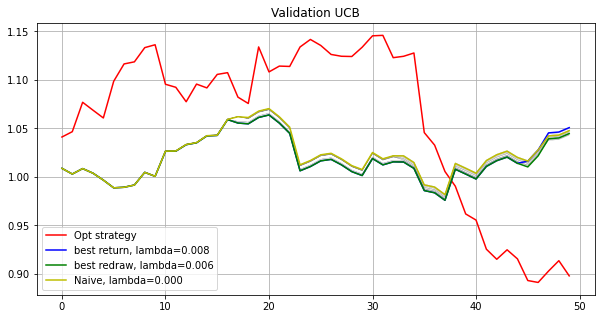

Testing...
./tmp2/res_phase04_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.01449593    Max redraw: 0.04741015
lambda: -0.018   Total log return: 0.01716019    Max redraw: 0.04741015
lambda: -0.016   Total log return: 0.02061541    Max redraw: 0.04741015
lambda: -0.014   Total log return: 0.02000184    Max redraw: 0.04741015
lambda: -0.012   Total log return: 0.01634502    Max redraw: 0.04741015
lambda: -0.010   Total log return: 0.01472589    Max redraw: 0.04741015
lambda: -0.008   Total log return: 0.01082606    Max redraw: 0.04741015
lambda: -0.006   Total log return: 0.01604362    Max redraw: 0.04741015
lambda: -0.004   Total log return: 0.02503168    Max redraw: 0.04741015
lambda: -0.002   Total log return: 0.03747112    Max redraw: 0.04741015
lambda: -0.000   Total log return: 0.03954515    Max redraw: 0.04741015
lambda: 0.002   Total log return: 0.04020998    Max redraw: 0.04741015
lambda: 0.004   Total log return: 0.03820739    Max redraw: 0.0474101

[ 0.     -0.     -0.      0.      0.     -0.      0.     -0.     -0.
  0.     -0.      0.     -0.     -0.     -0.     -0.      0.      0.093
 -0.     -0.      0.     -0.     -0.      0.     -0.     -0.     -0.
 -0.     -0.      0.     -0.     -0.      0.      0.     -0.     -0.
 -0.      0.      0.3    -0.      0.     -0.     -0.     -0.      0.
  0.1064  0.199  -0.     -0.     -0.      0.     -0.      0.      0.
 -0.     -0.     -0.      0.      0.     -0.      0.      0.3     0.
  0.      0.     -0.     -0.      0.      0.      0.     -0.      0.
  0.     -0.      0.      0.      0.     -0.     -0.     -0.      0.
  0.     -0.     -0.      0.     -0.     -0.      0.     -0.      0.
  0.     -0.     -0.     -0.      0.     -0.     -0.      0.     -0.
 -0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.2087 0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.189

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.3    0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.3    0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.3    0.     0.     0.     0.     0.     0.     0.     0.0957
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0907
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.3    0.     0.0049 0.     0.     0.     0.     0.3    0.
 0.     0.     0.     0.     0.     0.     0.    

[-0.     -0.      0.     -0.      0.      0.      0.      0.      0.
  0.     -0.     -0.      0.      0.     -0.     -0.      0.     -0.
 -0.      0.      0.3     0.0843  0.      0.      0.     -0.      0.
 -0.     -0.      0.      0.0101 -0.      0.     -0.     -0.      0.
 -0.     -0.     -0.     -0.      0.      0.      0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.3     0.     -0.     -0.      0.
  0.      0.      0.     -0.      0.      0.      0.     -0.      0.
  0.     -0.      0.      0.      0.      0.3     0.      0.     -0.
 -0.     -0.      0.     -0.      0.     -0.      0.      0.     -0.
 -0.      0.     -0.     -0.     -0.      0.     -0.      0.     -0.
  0.      0.      0.     -0.     -0.      0.     -0.     -0.     -0.
 -0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.082  0.     0.     0

[ 0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.     -0.      0.      0.      0.
  0.      0.      0.     -0.      0.      0.      0.      0.      0.
  0.3     0.      0.      0.      0.3     0.     -0.      0.      0.
  0.      0.     -0.      0.     -0.      0.      0.      0.      0.
  0.     -0.      0.      0.     -0.      0.      0.3     0.      0.
  0.      0.      0.      0.      0.      0.      0.     -0.      0.
  0.      0.      0.0923  0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.     -0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.    ]
[-0.     -0.     -0.     -0.      0.3    -0.     -0.     -0.     -0.
  0.0923 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.    

[0.     0.     0.     0.     0.1858 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.202  0.     0.
 0.3    0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.0017 0.     0.     0.3
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0509
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0396
 -0.     -0.     -0.     -0.      0.3    -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.3   

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.1935 -0.
 -0.     -0.      0.1078 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.3    -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.3    -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.0874 -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.2535 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.1288 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.3    0.     0.     0.     0.     0.
 0.     0.2572 0.     0.     0.     0.     0.     0.     0.     0.3
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[ 0.      0.     -0.     -0.     -0.      0.      0.     -0.     -0.
 -0.      0.     -0.      0.     -0.     -0.     -0.     -0.      0.
 -0.     -0.      0.      0.2794  0.     -0.      0.     -0.      0.
  0.      0.     -0.      0.     -0.     -0.      0.0354 -0.     -0.
 -0.     -0.      0.      0.      0.      0.    

[-0.     -0.     -0.     -0.     -0.     -0.      0.      0.     -0.
  0.     -0.     -0.     -0.     -0.     -0.     -0.      0.      0.0667
 -0.     -0.      0.      0.     -0.     -0.     -0.      0.      0.0585
  0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.     -0.
 -0.     -0.      0.2066 -0.     -0.     -0.     -0.     -0.      0.
 -0.     -0.      0.     -0.     -0.     -0.      0.     -0.     -0.
  0.      0.0586 -0.     -0.     -0.     -0.     -0.      0.     -0.
 -0.     -0.      0.0222 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.      0.2717 -0.      0.     -0.
 -0.      0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.     -0.     -0.     -0.      0.0873 -0.      0.      0.2248 -0.
  0.032  -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.      0.     -0.     -0.     -0.     -0.     -0.
  0.     -0.    

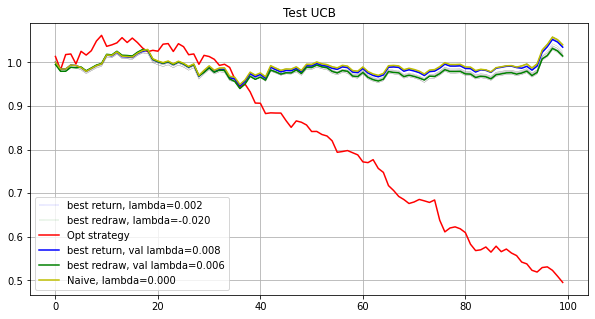

Phase 5
Validating...
./tmp2/res_phase05_iter8000_subn100_lb5.npz
Opt strategy
[-0.     -0.      0.01   -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.127  -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.01   -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.01   -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.
 -0.     -0.     -0.      0.0657 -0.     -0.     -0.     -0.     -0.
 -0.      0.2263 -0.     -0.     -0.      0.0027 -0.     -0.     -0.
  0.0964 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.1426 -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.01  ]
[0.     0.     0.3    0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.1836 0.
 0.     0.     0. 

[ 0.      0.      0.0466  0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.3     0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.0173  0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.3
  0.      0.3     0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.0145  0.0191  0.      0.      0.      0.      0.
  0.      0.      0.      0.     -0.      0.      0.      0.      0.
  0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.1872 0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     

[ 0.      0.      0.2844  0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.0208 -0.      0.      0.
  0.      0.      0.     -0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.     -0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.2125  0.1782  0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.3     0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.     -0.
  0.     -0.      0.      0.      0.      0.      0.     -0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.3    0.
 0.     0.     0.     0.     0.3    0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.033  0.     0.     0.     0

[-0.     -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.024  -0.      0.3    -0.     -0.     -0.
 -0.     -0.      0.0705 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[ 0.0683 -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.1688
 -0.     -0.     -0.     -0.      0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.

[0.     0.     0.3    0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.1735 0.
 0.1612 0.     0.     0.     0.     0.     0.     0.0741 0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.2831 0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[ 0.      0.     -0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
 -0.      0.     -0.      0.0119  0.      0.      0.      0.      0.
 -0.      0.      0.3     0.      0.3     0.      0.      0.      0.
  0.      0.      0.      0.      0.3     0.     

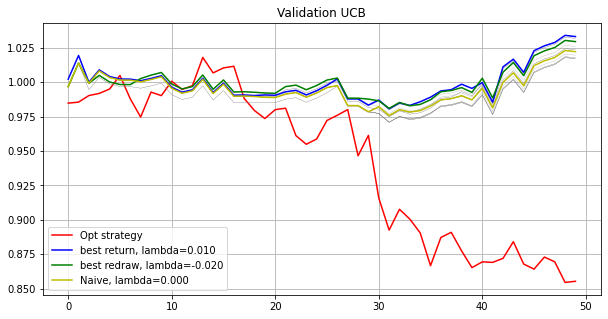

Testing...
./tmp2/res_phase05_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.09457053    Max redraw: 0.05127117
lambda: -0.018   Total log return: 0.09657663    Max redraw: 0.05127117
lambda: -0.016   Total log return: 0.07670235    Max redraw: 0.05127117
lambda: -0.014   Total log return: 0.06304404    Max redraw: 0.05127117
lambda: -0.012   Total log return: 0.06297960    Max redraw: 0.05127117
lambda: -0.010   Total log return: 0.07044942    Max redraw: 0.05127117
lambda: -0.008   Total log return: 0.07622245    Max redraw: 0.05127117
lambda: -0.006   Total log return: 0.07791816    Max redraw: 0.05127117
lambda: -0.004   Total log return: 0.07111208    Max redraw: 0.05129385
lambda: -0.002   Total log return: 0.07111208    Max redraw: 0.05129385
lambda: -0.000   Total log return: 0.06776157    Max redraw: 0.05129385
lambda: 0.002   Total log return: 0.07697366    Max redraw: 0.05129385
lambda: 0.004   Total log return: 0.07856000    Max redraw: 0.0497349

[0.     0.     0.     0.0274 0.     0.     0.     0.     0.2374 0.
 0.     0.     0.     0.     0.     0.     0.     0.3    0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.3
 0.     0.     0.     0.     0.1329 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.2599 -0.     -0.     -0.
 -0.     -0.     -0.      0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.2636 -0.    

[ 0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.3     0.
  0.      0.      0.     -0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.1579  0.      0.      0.2383  0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.3     0.      0.      0.      0.
  0.     -0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.     -0.      0.      0.
  0.    ]
[ 0.      0.      0.     -0.      0.      0.      0.      0.     -0.
  0.      0.      0.      0.      0.      0.3     0.      0.      0.
  0.      0.      0.      0.2871  0.      0.      0.      0.      0.
  0.      0.      0.    

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.1862  0.3     0.3     0.      0.
 -0.     -0.     -0.     -0.      0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.      0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.
  0.2082 -0.     -0.     -0.     -0.      0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.3     0.3    -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.    

[-0.     -0.     -0.     -0.     -0.      0.     -0.     -0.     -0.
 -0.      0.     -0.      0.     -0.     -0.      0.3    -0.     -0.
 -0.     -0.      0.     -0.      0.      0.     -0.      0.      0.
 -0.     -0.      0.0245  0.     -0.     -0.     -0.      0.     -0.
 -0.     -0.      0.      0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.     -0.     -0.     -0.     -0.      0.0063  0.
  0.     -0.     -0.     -0.     -0.      0.      0.     -0.     -0.
 -0.      0.     -0.     -0.      0.     -0.     -0.     -0.      0.2115
 -0.      0.     -0.     -0.      0.     -0.      0.      0.3     0.
 -0.     -0.     -0.      0.1505 -0.     -0.      0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.     -0.
 -0.    ]
[ 0.      0.      0.      0.      0.      0.      0.      0.      0.1084
  0.      0.      0.      0.      0.     -0.      0.1125  0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.    

[-0.    -0.     0.    -0.    -0.    -0.    -0.    -0.     0.3   -0.
 -0.    -0.    -0.    -0.     0.093 -0.    -0.    -0.    -0.    -0.
 -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.
 -0.     0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.
 -0.     0.298 -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.
 -0.    -0.    -0.    -0.     0.    -0.    -0.    -0.    -0.    -0.
 -0.    -0.    -0.    -0.     0.    -0.    -0.    -0.    -0.    -0.
 -0.    -0.     0.3    0.    -0.    -0.    -0.    -0.    -0.    -0.
 -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.
 -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.   ]
[-0.      0.      0.     -0.     -0.     -0.     -0.     -0.      0.
 -0.     -0.     -0.      0.     -0.      0.     -0.     -0.     -0.
  0.     -0.     -0.      0.      0.     -0.     -0.     -0.     -0.
  0.     -0.      0.     -0.      0.     -0.      0.      0.1412  0.3
 -0.      0.      0.      0.      0.   

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.2423
 -0.     -0.     -0.     -0.     -0.      0.2301 -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.1203 -0.
 -0.     -0.     -0.     -0.     -0.      0.0963 -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.
 -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.
 -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.
 -0.     0.116 -0.    -

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.1803
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.0157 -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.0151 -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.1757  0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.0653 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0. 

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.2087 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.3    0.     0.     0.     0.     0.     0.     0.
 0.1708 0.     0.     0.     0.     0.     0.     0.3    0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.0045 0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[ 0.      0.      0.      0.      0.      0.      0.      0.      0.0888
 -0.     -0.      0.      0.      0.     -0.      0.     -0.      0.
  0.     -0.      0.      0.      0.     -0.     -0.      0.      0.
  0.      0.     -0.     -0.      0.26   -0.     -0.      0.      0.
 -0.      0.      0.      0.3    -0.      0. 

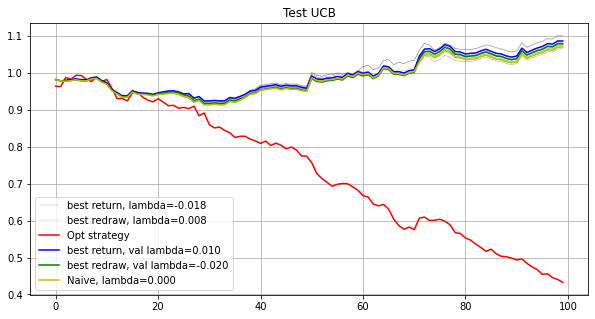

Phase 6
Validating...
./tmp2/res_phase06_iter8000_subn100_lb5.npz
Opt strategy
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.3     0.2247 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0034
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0001 -0.
 -0.      0.2719 -0.     -0.     -0.     -0.     -0.     -0.      0.0031
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0172
 -0.     -0.      0.086  -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.0942 -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0003
 -0.    ]
[ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.


[ 0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.0584 -0.      0.      0.      0.      0.      0.      0.
  0.273   0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.2359  0.     -0.      0.      0.053   0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.3     0.      0.0772  0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.     -0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.    ]
[-0.     -0.      0.     -0.     -0.      0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.     -0.      0.     -0.     -0.     -0.
  0.2792 -0.      0.     -0.      0.      0.      0.     -0.     -0.
 -0.     -0.     -0.    

[-0.      0.003  -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.3    -0.      0.1168 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.2763 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.3    0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0952
 0.     0.     0.     0.  

[-0.      0.0551 -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0389
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[ 0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.0544  0.     -0.      0.      0.      0.      0.      0.      0.
 -0.      0.      0.

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.0891 -0.     -0.     -0.     -0.     -0.     -0.
  0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0031
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.     -0.     -0.      0.2901 -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.1248 -0.     -0.     -0.     -0.      0.2244 -0.
 -0.     -0.      0.2607 -0.      0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[ 0.0617 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.3    -0.      0.1344  0.1065 -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.

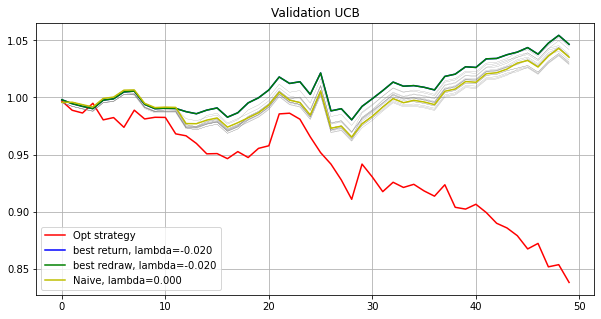

Testing...
./tmp2/res_phase06_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.20825661    Max redraw: 0.04421898
lambda: -0.018   Total log return: 0.20924816    Max redraw: 0.04421898
lambda: -0.016   Total log return: 0.21651083    Max redraw: 0.04421898
lambda: -0.014   Total log return: 0.21232723    Max redraw: 0.04421898
lambda: -0.012   Total log return: 0.21022755    Max redraw: 0.04421898
lambda: -0.010   Total log return: 0.20631076    Max redraw: 0.04421898
lambda: -0.008   Total log return: 0.20639946    Max redraw: 0.04421898
lambda: -0.006   Total log return: 0.20400683    Max redraw: 0.04421898
lambda: -0.004   Total log return: 0.19399370    Max redraw: 0.04421898
lambda: -0.002   Total log return: 0.20301120    Max redraw: 0.04421898
lambda: -0.000   Total log return: 0.20169129    Max redraw: 0.04421898
lambda: 0.002   Total log return: 0.19245404    Max redraw: 0.04421898
lambda: 0.004   Total log return: 0.18825244    Max redraw: 0.0442189

[ 0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.067   0.266  -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.     -0.     -0.     -0.      0.     -0.      0.0654
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3
 -0.      0.3    -0.     -0.     -0.     -0.     -0.      0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.      0.     -0.     -0.     -0.     -0.      0.
 -0.    ]
[ 0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.0678 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0

[ 0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.0092  0.0154  0.
  0.      0.      0.148   0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.3     0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.     -0.      0.1956  0.      0.      0.      0.      0.      0.
  0.      0.      0.2205  0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.0005
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.0211  0.      0.      0.0588  0.0269
  0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.0649  0.     -0.      0.2095 -0.
  0.3    -0.    

[ 0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.2734  0.      0.      0.     -0.      0.      0.3     0.
  0.      0.      0.     -0.      0.      0.      0.1422  0.      0.
  0.     -0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.2787  0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.     -0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.    ]
[ 0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.3     0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.1488  0.      0.1018  0.      0.      0.
  0.      0.      0.    

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.3    -0.     -0.     -0.     -0.      0.0435 -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.0496 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.3    -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3
 -0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.3    0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.2324
 0.     0.     0.     0.2

[-0.      0.      0.     -0.      0.      0.      0.     -0.      0.
  0.     -0.     -0.     -0.     -0.     -0.      0.     -0.     -0.
 -0.     -0.      0.2201 -0.     -0.      0.     -0.     -0.     -0.
  0.1704 -0.      0.     -0.      0.      0.      0.     -0.      0.
 -0.     -0.      0.     -0.     -0.     -0.     -0.     -0.      0.
 -0.     -0.     -0.     -0.     -0.      0.      0.     -0.      0.
 -0.     -0.     -0.      0.     -0.     -0.      0.3    -0.     -0.
  0.      0.     -0.     -0.      0.     -0.     -0.      0.     -0.
 -0.     -0.     -0.      0.      0.      0.      0.      0.3    -0.
 -0.      0.     -0.     -0.      0.      0.      0.      0.     -0.
  0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.      0.     -0.     -0.     -0.     -0.     -0.     -0.      0.
  0.     -0.     -0.      0.0156 -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.    

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.1122  0.1873 -0.      0.3    -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.0803 -0.     -0.     -0.     -0.     -0.      0.009  -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.     -0.     -0.     -0.      0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.      0.1398 -0.
  0.3    -0.      0.0502 -0.      0.      0.     -0.      0.     -0.
 -0.     -0.      0.0653

[-0.      0.      0.     -0.      0.     -0.      0.      0.      0.
  0.     -0.     -0.      0.     -0.      0.      0.     -0.      0.
 -0.      0.      0.2639  0.      0.      0.      0.     -0.     -0.
 -0.      0.      0.3    -0.     -0.     -0.      0.2171 -0.     -0.
 -0.     -0.     -0.      0.      0.     -0.      0.     -0.     -0.
 -0.      0.     -0.     -0.      0.     -0.     -0.      0.     -0.
  0.     -0.      0.     -0.     -0.      0.     -0.     -0.     -0.
  0.     -0.     -0.     -0.     -0.      0.      0.     -0.      0.
  0.     -0.      0.     -0.      0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.     -0.     -0.      0.      0.2055 -0.
  0.     -0.      0.      0.     -0.      0.      0.     -0.     -0.
 -0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.2027 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.3   

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.     -0.
  0.158  -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.2275 -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.3     0.1211 -0.     -0.     -0.
  0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.    

[0.     0.     0.     0.     0.0059 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.1404 0.     0.     0.     0.
 0.2849 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.1827 0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.1531 0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.2154 0.     0.     0.     0.     0.    ]
Opt strategy   Total log return: -0.64935841    Max redraw: 0.04421898
Total return: 0.52238082
Mean return: 0.99352745
best return val lambda: -0.016   Total log return: 0.20825661
Total return: 1.23152915
Mean return: 1.00208474
best redraw val lambda: -0.020   Total log return: 0.20825661
Total return: 1.23152915
Mean re

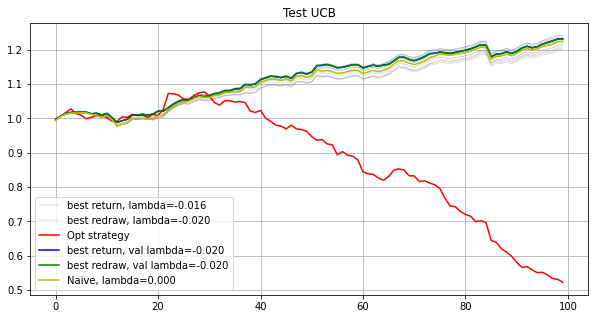

Phase 7
Validating...
./tmp2/res_phase07_iter8000_subn100_lb5.npz
Opt strategy
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.3    -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.0017 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0996  0.3
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[ 0.0129  0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.1389  0.      0.      0.      0.      0.
  0.      0. 

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.1583
 0.0799 0.     0.     0.     0.     0.     0.     0.     0.     0.1095
 0.     0.     0.     0.     0.     0.     0.     0.0502 0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.3    0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.3    0.     0.     0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.2283 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.1652 0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.    

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.     -0.      0.     -0.      0.0998 -0.     -0.
 -0.      0.     -0.      0.0564 -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.1165 -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.0958 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.     -0.     -0.
 -0.      0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.2759  0.0514  0.
  0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.     -0.
 -0.    ]
[-0.     -0.     -0.     -0.      0.1403 -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.1405

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.3    0.     0.     0.     0.     0.     0.1046 0.
 0.     0.     0.     0.     0.1712 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.3    0.     0.     0.     0.     0.1176 0.     0.     0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.0722 0.0212 0.3    0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     

[ 0.0982 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.1398 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.2735 -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.181  -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.3    -0.     -0.     -0.
 -0.    ]
[ 0.0787  0.3    -0.     -0.      0.      0.     -0.      0.      0.
  0.     -0.     -0.     -0.      0.     -0.     -0.      0.     -0.
 -0.     -0.      0.0216 -0.     -0.     -0.     -0.      0.     -0.
 -0.      0.     -0.    

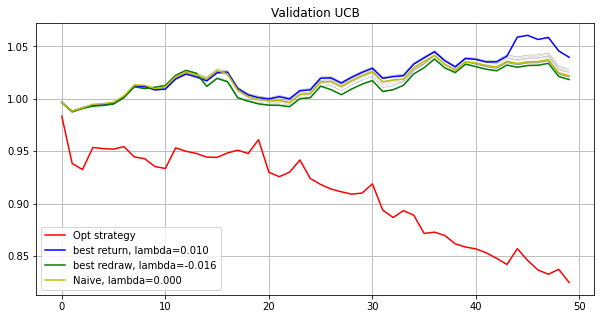

Testing...
./tmp2/res_phase07_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.09307256    Max redraw: 0.04027295
lambda: -0.018   Total log return: 0.09204683    Max redraw: 0.04117268
lambda: -0.016   Total log return: 0.09059912    Max redraw: 0.04117268
lambda: -0.014   Total log return: 0.09027487    Max redraw: 0.04117268
lambda: -0.012   Total log return: 0.09337694    Max redraw: 0.04117268
lambda: -0.010   Total log return: 0.09945863    Max redraw: 0.04027295
lambda: -0.008   Total log return: 0.10300035    Max redraw: 0.04027295
lambda: -0.006   Total log return: 0.10895820    Max redraw: 0.04027295
lambda: -0.004   Total log return: 0.10850160    Max redraw: 0.04027295
lambda: -0.002   Total log return: 0.10397950    Max redraw: 0.04027295
lambda: -0.000   Total log return: 0.09492290    Max redraw: 0.03980353
lambda: 0.002   Total log return: 0.09419810    Max redraw: 0.03980353
lambda: 0.004   Total log return: 0.07958077    Max redraw: 0.0398035

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.1677 -0.     -0.      0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.     -0.     -0.
 -0.     -0.      0.2326 -0.      0.      0.     -0.     -0.     -0.
 -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.      0.1935 -0.     -0.
 -0.     -0.     -0.      0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.1045 -0.     -0.      0.     -0.     -0.
  0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.
 -0.      0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.     -0.
 -0.     -0.      0.0001

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.0034 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.1883 -0.     -0.     -0.     -0.     -0.      0.0605 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3
 -0.     -0.     -0.     -0.     -0.     -0.      0.062   0.3    -0.
 -0.     -0.     -0.      0.0821 -0.     -0.     -0.     -0.     -0.
 -0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0361
 0.     0.     0.     0.     0.     0.3    0.     0.     0.246  0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.2402 0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.1718 0.     0.     0.     0.     0.     0.     0.     0.    ]
[ 0.      0.     -0.     -0.      0.      0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.1529  0.3    -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0. 

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.3     0.0764 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.0162 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[ 0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.177   0.      0.      0.      0.      0.      0.      0.      0.003
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0. 

[ 0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.     -0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.3     0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.3     0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.0899  0.      0.      0.      0.      0.
  0.      0.3     0.      0.      0.      0.      0.      0.      0.
  0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.3    0.     0.     0.3    0

[ 0.      0.     -0.      0.     -0.     -0.     -0.     -0.      0.
  0.     -0.      0.      0.      0.     -0.      0.      0.     -0.
  0.     -0.     -0.      0.     -0.      0.      0.0441 -0.     -0.
 -0.      0.      0.      0.     -0.      0.      0.117   0.     -0.
  0.     -0.      0.     -0.     -0.      0.      0.     -0.      0.
 -0.      0.      0.      0.      0.     -0.      0.     -0.     -0.
  0.     -0.      0.     -0.     -0.     -0.      0.      0.      0.
  0.     -0.     -0.     -0.      0.     -0.     -0.     -0.     -0.
  0.      0.      0.      0.2269  0.     -0.     -0.      0.3    -0.
 -0.     -0.     -0.     -0.      0.      0.      0.     -0.     -0.
 -0.      0.      0.     -0.     -0.     -0.      0.3     0.     -0.
 -0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0027
 0.     0.     0.3    0.     0.     0.     0.     0.     0.0682 0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.0055 0.     0.     0.  

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.2487 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.0671 -0.     -0.      0.3    -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0704
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.0857 0. 

[-0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.     -0.     -0.     -0.      0.      0.     -0.      0.      0.
  0.1549 -0.      0.      0.      0.     -0.     -0.      0.     -0.
 -0.     -0.      0.      0.      0.      0.      0.     -0.      0.
  0.      0.      0.     -0.     -0.     -0.      0.0424 -0.      0.
 -0.     -0.      0.      0.     -0.      0.      0.2637  0.      0.
  0.      0.      0.      0.     -0.     -0.     -0.      0.      0.
 -0.     -0.      0.     -0.     -0.      0.     -0.      0.      0.
  0.0558 -0.      0.1669  0.      0.      0.     -0.      0.     -0.
  0.      0.     -0.      0.      0.      0.     -0.      0.     -0.
  0.      0.3     0.      0.     -0.      0.      0.      0.      0.
  0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0

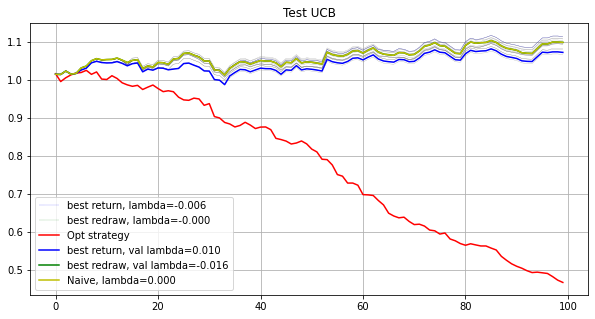

Phase 8
Validating...
./tmp2/res_phase08_iter8000_subn100_lb5.npz
Opt strategy
[0.     0.     0.1403 0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.0205 0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.3    0.     0.     0.     0.     0.3
 0.     0.2381 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.2771 -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.  

[ 0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.     -0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.     -0.      0.
  0.      0.      0.      0.      0.      0.3     0.      0.     -0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.3     0.1724  0.     -0.     -0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.0537  0.1713  0.      0.
  0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.    

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0105
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.2732 0.     0.     0.     0.     0.3    0.     0.3    0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.1113 0.     0.     0.     0.     0.    ]
[-0.     -0.      0.0341 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.     -0.      0.1327 -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0. 

[-0.     -0.     -0.      0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.3     0.      0.     -0.     -0.     -0.     -0.
 -0.      0.      0.     -0.      0.     -0.      0.      0.     -0.
 -0.      0.      0.3    -0.     -0.     -0.     -0.     -0.      0.3
 -0.     -0.     -0.      0.     -0.      0.     -0.     -0.     -0.
 -0.      0.      0.     -0.     -0.      0.      0.     -0.      0.
  0.0165  0.     -0.      0.     -0.     -0.      0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.     -0.      0.      0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.     -0.     -0.
 -0.      0.     -0.     -0.      0.      0.      0.0776 -0.     -0.
  0.    ]
[ 0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.3     0.      0.      0.      0.0076  0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.3  

[-0.      0.     -0.      0.      0.      0.      0.     -0.     -0.
  0.      0.     -0.      0.      0.      0.      0.      0.     -0.
 -0.     -0.      0.      0.     -0.      0.      0.      0.      0.
  0.      0.     -0.      0.      0.     -0.     -0.      0.      0.
  0.      0.      0.      0.     -0.      0.      0.      0.3     0.
  0.     -0.      0.     -0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.     -0.     -0.     -0.
 -0.     -0.      0.     -0.     -0.      0.     -0.      0.1843 -0.
  0.     -0.      0.2754  0.      0.     -0.      0.     -0.     -0.
  0.     -0.      0.      0.      0.     -0.      0.1405  0.     -0.
  0.     -0.      0.      0.     -0.     -0.      0.0913  0.     -0.
 -0.    ]
[ 0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.1251  0.      0.      0.      0.
  0.     -0.      0.      0.      0.      0.      0.0355  0.      0.
  0.      0.     -0.    

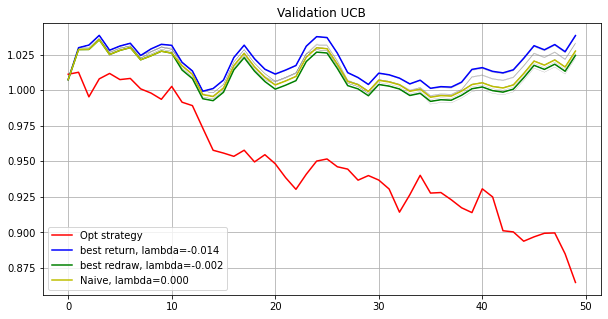

Testing...
./tmp2/res_phase08_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.04178553    Max redraw: 0.04154353
lambda: -0.018   Total log return: 0.04178553    Max redraw: 0.04154353
lambda: -0.016   Total log return: 0.04548496    Max redraw: 0.04154353
lambda: -0.014   Total log return: 0.04087616    Max redraw: 0.04154353
lambda: -0.012   Total log return: 0.03717725    Max redraw: 0.04154353
lambda: -0.010   Total log return: 0.04226571    Max redraw: 0.04154353
lambda: -0.008   Total log return: 0.04410808    Max redraw: 0.04154353
lambda: -0.006   Total log return: 0.04088311    Max redraw: 0.04154353
lambda: -0.004   Total log return: 0.04586607    Max redraw: 0.04154353
lambda: -0.002   Total log return: 0.04682497    Max redraw: 0.04154353
lambda: -0.000   Total log return: 0.04745435    Max redraw: 0.04154353
lambda: 0.002   Total log return: 0.04386840    Max redraw: 0.04154353
lambda: 0.004   Total log return: 0.05685098    Max redraw: 0.0415435

[ 0.      0.      0.      0.     -0.      0.     -0.      0.      0.
  0.     -0.      0.      0.      0.1985  0.     -0.      0.     -0.
  0.      0.     -0.      0.      0.      0.      0.2618  0.     -0.
 -0.      0.      0.3     0.     -0.      0.      0.      0.      0.
  0.      0.     -0.      0.      0.      0.      0.      0.     -0.
  0.      0.      0.      0.      0.      0.      0.     -0.     -0.
  0.      0.      0.      0.      0.     -0.      0.      0.     -0.
  0.     -0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.     -0.     -0.     -0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.     -0.      0.      0.2379  0.      0.      0.      0.     -0.
 -0.    ]
[ 0.      0.      0.      0.     -0.      0.      0.      0.      0.
  0.     -0.      0.      0.      0.0979  0.     -0.      0.      0.
  0.      0.     -0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.3   

[ 0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.     -0.      0.      0.      0.      0.3     0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.3     0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.3     0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.0959  0.      0.      0.
  0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.3
 0.     0.     0.     0.     

[0.     0.     0.0128 0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.3    0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.2669 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.1141
 0.     0.     0.     0.     0.     0.     0.3    0.     0.     0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.3
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.3
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.3
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.096
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.     -0.
 -0.     -0.     -0.      0.2966 -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0. 

[0.     0.     0.1075 0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.1198
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.3    0.     0.     0.     0.     0.1628 0.     0.     0.     0.3
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[-0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.
 -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.
 -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.
 -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.
 -0.   -0.   -0.   -0.   -0.   -0.  

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.0311 -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.3     0.2261 -0.     -0.      0.0019  0.1292 -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.      0.      0.      0.      0.      0.      0.      0.      0.
 -0.      0.      0.      0.     -0.      0.      0.      0.      0.
  0.063   0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.0242

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.2373 -0.     -0.
 -0.     -0.      0.2539 -0.     -0.     -0.     -0.     -0.      0.0385
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.      0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.     -0.      0.      0.0205
 -0.     -0.      0.1362  0.      0.      0.      0.     -0.     -0.
 -0.      0.3     0.     -0.     -0.      0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.2987 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.1988 -0.     -0.     -0.     -0.     -0.
 -0.     -0.    

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.0069 -0.     -0.     -0.     -0.      0.1493 -0.     -0.
 -0.     -0.      0.0153  0.     -0.     -0.     -0.     -0.      0.0898
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.     -0.     -0.     -0.     -0.     -0.
  0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.2366 -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.0951 -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.     -0.      0.0919 -0.     -0.
 -0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.0352 -0.     -0.     -0.     -0.      0.1351 -0.     -0.
 -0.     -0.     -0.

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.3
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.3    0.     0.1214 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.2608
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
Opt strategy   Total log return: -0.93897060    Max redraw: 0.04306732
Total return: 0.39103016
Mean return: 0.99065424
best return val lambda: 0.008   Total log return: 0.04087616
Total return: 1.04172309
Mean return: 1.00040885
best redraw val lambda: -0.002   Total log return: 0.04178553
Total return: 1.04267083
Mea

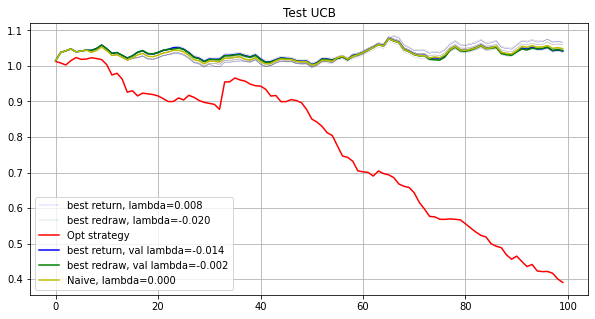

Phase 9
Validating...
./tmp2/res_phase09_iter8000_subn100_lb5.npz
Opt strategy
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.3    0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.3    0.     0.     0.     0.     0.
 0.     0.0926 0.     0.     0.     0.     0.0072 0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.3    0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[-0.      0.1465 -0.     -0.     -0.     -0.      0.2873 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.   

[-0.      0.1449 -0.     -0.     -0.     -0.     -0.      0.3    -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.2534
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[ 0.      0.      0.      0.3     0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.1646 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.2326 -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.      0.2275 -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.039
 -0.     -0.     -0. 

[0.     0.3    0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.1145 0.     0.     0.     0.0612 0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.015  0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.3    0.     0.2028 0.    ]
[ 0.     -0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.3     0.2347  0.
  0.      0.      0.      0.      0.      0.      0.     -0.      0.
  0.      0.     -0.      0.      0.      0.0299 

[-0.      0.2595 -0.     -0.     -0.     -0.      0.2794 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.1538 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[ 0.      0.      0.     -0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.     -0.      0.      0.      0.      0.2452  0.      0.
  0.      0.      0.    

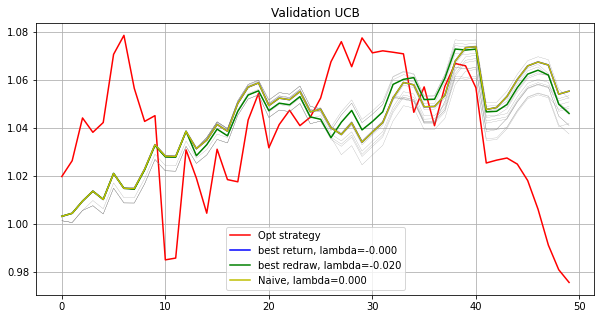

Testing...
./tmp2/res_phase09_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.09169513    Max redraw: 0.03340976
lambda: -0.018   Total log return: 0.09705971    Max redraw: 0.03340976
lambda: -0.016   Total log return: 0.08685545    Max redraw: 0.03340976
lambda: -0.014   Total log return: 0.09649924    Max redraw: 0.03340976
lambda: -0.012   Total log return: 0.09522997    Max redraw: 0.03340976
lambda: -0.010   Total log return: 0.10101991    Max redraw: 0.03267943
lambda: -0.008   Total log return: 0.10152567    Max redraw: 0.03267943
lambda: -0.006   Total log return: 0.10408528    Max redraw: 0.03267943
lambda: -0.004   Total log return: 0.10237535    Max redraw: 0.03267943
lambda: -0.002   Total log return: 0.10357638    Max redraw: 0.03267943
lambda: -0.000   Total log return: 0.10357638    Max redraw: 0.03267943
lambda: 0.002   Total log return: 0.10785830    Max redraw: 0.03267943
lambda: 0.004   Total log return: 0.10442110    Max redraw: 0.0326794

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.0985 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.      0.1024 -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.2958 -0.     -0.
 -0.     -0.     -0.    

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.3     0.3    -0.
 -0.     -0.     -0.     -0.     -0.      0.0816 -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.0682 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.2467
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.      0.     -0.      0.      0.     -0.     -0.      0.     -0.
 -0.      0.0342 -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.0748 -0.      0.      0.      0.     -0.
 -0.     -0.     -0.

[-0.      0.0266 -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.3     0.3    -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.068  -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.      0.     -0.     -0.      0.     -0.     -0.     -0.      0.
  0.     -0.     -0.     -0.     -0.      0.      0.      0.     -0.
  0.      0.      0.      0.      0.     -0.      0.      0.1088  0.089
 -0.     -0.      0. 

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.2557 -0.     -0.     -0.      0.3    -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.1372 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.    

[-0.      0.2049 -0.     -0.     -0.     -0.      0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.1787 -0.     -0.
 -0.     -0.      0.0067 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.      0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.     -0.
 -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.
  0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[ 0.      0.     -0.      0.      0.      0.      0.      0.      0.
  0.     -0.      0.     -0.     -0.      0.      0.      0.     -0.
  0.      0.      0.3     0.     -0.     -0.      0.      0.      0.
  0.      0.      0.    

[ 0.      0.3     0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.3     0.      0.
  0.0878  0.      0.      0.      0.      0.      0.3     0.     -0.
  0.      0.      0.      0.      0.      0.      0.     -0.      0.
  0.      0.      0.      0.      0.     -0.      0.      0.      0.
  0.      0.      0.     -0.      0.      0.      0.     -0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.     -0.     -0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.     -0.      0.      0.      0.     -0.      0.      0.
  0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.      0.2722 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.    

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.0666 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.3     0.3    -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.1135 -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.2063
 -0.    ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.  

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.2532 -0.
 -0.     -0.     -0.     -0.     -0.      0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.     -0.     -0.     -0.     -0.      0.1952
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.2361 -0.      0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.
  0.3    -0.     -0.     -0.     -0.     -0.      0.     -0.     -0.
 -0.     -0.      0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.     -0.
 -0.     -0.      0.0546 -0.     -0.     -0.      0.     -0.     -0.
 -0.     -0.     -0.

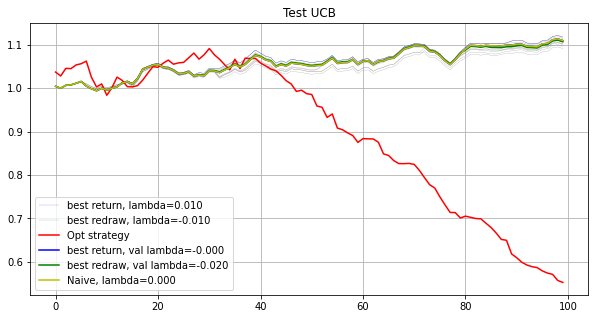

Phase 10
Validating...
./tmp2/res_phase10_iter8000_subn100_lb5.npz
Opt strategy
[ 0.      0.      0.0804  0.      0.      0.      0.      0.      0.
  0.     -0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.3     0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
 -0.      0.1116  0.      0.      0.      0.      0.3     0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.2078  0.      0.      0.      0.      0.      0.     -0.     -0.
  0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0. 

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.3    0.     0.     0.     0.     0.     0.
 0.3    0.     0.     0.     0.     0.0565 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.3    0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0408
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.0654 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0. 

[-0.     -0.      0.1789 -0.     -0.     -0.     -0.      0.     -0.
  0.     -0.     -0.     -0.     -0.      0.1809  0.0464 -0.     -0.
 -0.     -0.      0.2897 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.     -0.     -0.     -0.      0.3    -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.    

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.0941 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[ 0.      0.     -0.      0.     -0.      0.      0.      0.      0.
  0.      0.      0.      0.     -0.     -0.      0.2219  0.      0.
  0.      0.      0.0729  0.      0.      0.      0.      0.      0.
  0.      0.      0.    

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.2499 -0.      0.     -0.
 -0.     -0.      0.3    -0.     -0.     -0.     -0.      0.1131 -0.
 -0.     -0.     -0.     -0.      0.3    -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.0291 -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.0024 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.2751 -0.
 -0.     -0.     -0.    

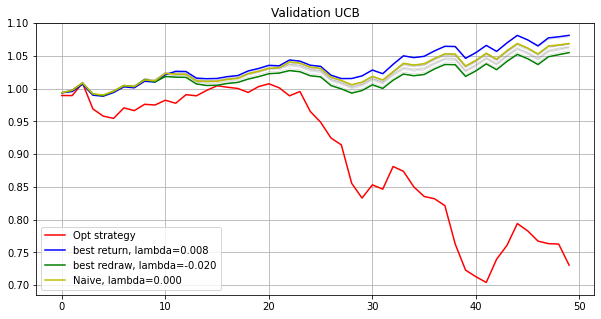

Testing...
./tmp2/res_phase10_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.08116028    Max redraw: 0.04229200
lambda: -0.018   Total log return: 0.08348685    Max redraw: 0.04229200
lambda: -0.016   Total log return: 0.06238050    Max redraw: 0.04229200
lambda: -0.014   Total log return: 0.06048604    Max redraw: 0.04229200
lambda: -0.012   Total log return: 0.06024048    Max redraw: 0.04229200
lambda: -0.010   Total log return: 0.05893089    Max redraw: 0.04229200
lambda: -0.008   Total log return: 0.07108065    Max redraw: 0.04229200
lambda: -0.006   Total log return: 0.07304868    Max redraw: 0.04229200
lambda: -0.004   Total log return: 0.07828324    Max redraw: 0.04229200
lambda: -0.002   Total log return: 0.08972199    Max redraw: 0.04229200
lambda: -0.000   Total log return: 0.09715899    Max redraw: 0.04229200
lambda: 0.002   Total log return: 0.09687345    Max redraw: 0.04229200
lambda: 0.004   Total log return: 0.10057098    Max redraw: 0.0422920

[-0.     -0.      0.175  -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.1717 -0.     -0.     -0.     -0.      0.0514 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.3    0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.2655 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.1311
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.     -0.      0.2264 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.     -0.     -0.      0.     -0.     -0.
 -0.     -0.      0.     -0.     -0.     -0.     -0.      0.3    -0.
 -0.     -0.     -0.

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.0948 -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.     -0.      0.0952 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.
 -0.     -0.     -0.    

[0.     0.     0.0416 0.     0.0365 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.3    0.     0.     0.     0.     0.2057 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.1087 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.3    0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[-0.     -0.      0.     -0.      0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.1646 -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.     -0.     -0.     -0.     -0.      0.0591 -0.
 -0.     -0.     -0.     -0.      0.1691 -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.0912 -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.0001 -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.      0.3
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.0907 0.     

[-0.     -0.      0.1799 -0.      0.3    -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.     -0.     -0.     -0.     -0.      0.1108 -0.
 -0.     -0.     -0.      0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.     -0.     -0.     -0.      0.     -0.      0.     -0.     -0.
 -0.     -0.      0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.
 -0.      0.0984 -0.     -0.      0.3    -0.      0.     -0.     -0.
 -0.     -0.      0.     -0.     -0.     -0.     -0.     -0.      0.
 -0.     -0.      0.     -0.     -0.     -0.     -0.     -0.      0.
 -0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.3    -0.     -0.     -0.     -0.      0.0442 -0.
 -0.     -0.     -0.    

[ 0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.     -0.     -0.      0.      0.      0.
  0.      0.      0.3     0.      0.      0.      0.      0.1532  0.
  0.      0.      0.      0.     -0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.2341  0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.3
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.3    0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     

[ 0.      0.      0.     -0.      0.     -0.      0.     -0.     -0.
 -0.     -0.      0.      0.     -0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.     -0.     -0.      0.      0.
  0.     -0.     -0.      0.      0.3     0.     -0.      0.     -0.
 -0.      0.      0.      0.     -0.      0.      0.     -0.      0.
  0.     -0.      0.0854  0.     -0.      0.      0.      0.      0.
  0.     -0.      0.      0.     -0.     -0.     -0.      0.      0.
 -0.     -0.      0.      0.     -0.      0.      0.3    -0.      0.
  0.      0.3    -0.      0.     -0.      0.      0.      0.      0.
 -0.      0.     -0.      0.      0.      0.      0.      0.     -0.
  0.     -0.      0.      0.     -0.      0.      0.      0.     -0.
 -0.    ]
[0.1531 0.     0.     0.     0.2317 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.3    0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0

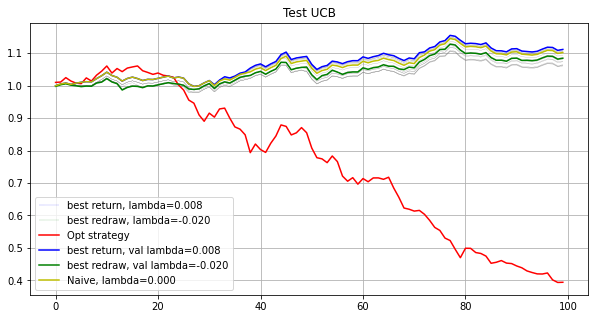

Phase 11
Validating...
./tmp2/res_phase11_iter8000_subn100_lb5.npz
Opt strategy
[0.3    0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.0898 0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.01   0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.3    0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.3    0.     0.     0.     0.    ]
[ 0.2795 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.  

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.3    -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.2554 -0.
 -0.     -0.      0.1428 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[ 0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.     -0.      0.      0.      0.
  0.      0.      0.    

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.1922 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.3    0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.2036 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.3    0.     0.     0.     0.    ]
[ 0.1404 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.2556 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     

[ 0.     -0.     -0.      0.      0.      0.     -0.     -0.     -0.
  0.      0.     -0.     -0.     -0.     -0.      0.      0.      0.
 -0.      0.      0.3    -0.     -0.      0.      0.      0.      0.
 -0.     -0.     -0.      0.      0.      0.     -0.     -0.     -0.
  0.      0.      0.     -0.     -0.      0.     -0.      0.      0.
  0.      0.     -0.     -0.     -0.     -0.     -0.      0.     -0.
  0.     -0.     -0.      0.     -0.     -0.      0.      0.0943 -0.
 -0.      0.      0.      0.     -0.      0.      0.      0.      0.
  0.      0.     -0.      0.     -0.      0.     -0.     -0.      0.
  0.3     0.     -0.      0.      0.      0.      0.     -0.     -0.
 -0.     -0.      0.     -0.      0.      0.      0.      0.      0.3
 -0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.   

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.1843 0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.2073 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.3    0.     0.     0.     0.3    0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[-0.     -0.     -0.     -0.     -0.      0.     -0.     -0.     -0.
 -0.      0.1742 -0.      0.     -0.     -0.     -0.      0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.1165 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     

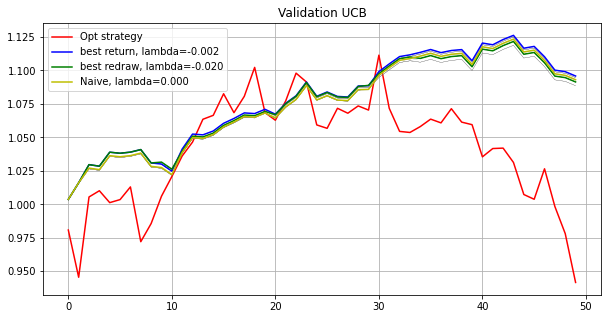

Testing...
./tmp2/res_phase11_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.00655404    Max redraw: 0.03963933
lambda: -0.018   Total log return: 0.00334525    Max redraw: 0.04059558
lambda: -0.016   Total log return: 0.00335113    Max redraw: 0.04059558
lambda: -0.014   Total log return: 0.00373069    Max redraw: 0.04059558
lambda: -0.012   Total log return: 0.00750634    Max redraw: 0.04059558
lambda: -0.010   Total log return: 0.00599503    Max redraw: 0.04059558
lambda: -0.008   Total log return: 0.00500325    Max redraw: 0.04059558
lambda: -0.006   Total log return: 0.00408816    Max redraw: 0.04059558
lambda: -0.004   Total log return: 0.00354523    Max redraw: 0.04059558
lambda: -0.002   Total log return: 0.00347971    Max redraw: 0.04059558
lambda: -0.000   Total log return: 0.00521187    Max redraw: 0.04059558
lambda: 0.002   Total log return: 0.00314349    Max redraw: 0.04059558
lambda: 0.004   Total log return: 0.00588208    Max redraw: 0.0408738

[ 0.     -0.     -0.      0.      0.      0.     -0.      0.     -0.
  0.     -0.      0.     -0.      0.      0.      0.      0.3     0.
  0.      0.     -0.     -0.      0.     -0.      0.      0.      0.
 -0.     -0.     -0.     -0.      0.     -0.      0.      0.     -0.
  0.     -0.      0.     -0.      0.      0.     -0.      0.      0.
  0.     -0.      0.      0.     -0.     -0.     -0.     -0.      0.
  0.3    -0.     -0.      0.     -0.      0.      0.      0.     -0.
 -0.     -0.      0.      0.      0.     -0.      0.     -0.      0.
 -0.      0.     -0.      0.      0.      0.      0.      0.     -0.
  0.0979 -0.      0.      0.3     0.      0.     -0.     -0.      0.
  0.     -0.      0.     -0.      0.     -0.     -0.     -0.      0.
 -0.    ]
[ 0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.     -0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.117   0.      0.     -0.      0.      0.      0.
  0.      0.      0.    

[ 0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.3    -0.     -0.      0.0589 -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.0133 -0.     -0.     -0.      0.     -0.      0.024  -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[ 0.0963 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.    

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.     -0.
 -0.     -0.     -0.     -0.      0.     -0.     -0.     -0.     -0.
  0.3    -0.     -0.     -0.      0.3    -0.     -0.     -0.     -0.
  0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.0943 -0.     -0.     -0.     -0.     -0.
 -0.    ]
[ 0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.    

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.3    0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.0684 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0235
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.3    0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.3    0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[-0.     -0.     -0.      0.     -0.     -0.     -0.     -0.      0.
 -0.     -0.      0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.      0.1884 -0.     -0.     -0.
 -0.      0.     -0.      0.     -0.      0.     -0.      0.     -0.
  0.     -0.     -0.     -0.     -0.     -0. 

[-0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.     -0.      0.
  0.      0.      0.3     0.      0.      0.      0.      0.0345  0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.3     0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.3     0.      0.      0.     -0.      0.      0.
  0.      0.      0.      0.      0.      0.0326  0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.0228  0.      0.     -0.      0.      0.
  0.    ]
[ 0.1591  0.     -0.      0.      0.     -0.      0.      0.      0.
 -0.      0.      0.      0.      0.      0.      0.     -0.      0.
  0.      0.      0.      0.      0.     -0.      0.      0.      0.
  0.      0.      0.    

[ 0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.0271 -0.     -0.     -0.      0.3    -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.0613 -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[ 0.1635 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3
 -0.     -0.     -0.   

[ 0.067  -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.0192 -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0573
 -0.     -0.     -0.     -0.      0.2435 -0.     -0.     -0.     -0.
  0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[ 0.0504 -0.     -0.     -0.     -0.      0.3    -0.     -0.     -0.
 -0.      0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.

[ 0.0674 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.0172 -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3
 -0.     -0.     -0.     -0.      0.3    -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[0.3    0.     0.     0.     0.     0.0071 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.    

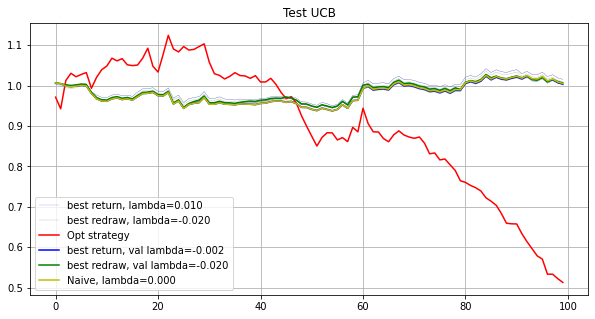

-----------------------------Final result-----------------------------
Opt strategy
Total return: 0.00228151
Mean return: 0.99242519
best return strategy
Total return: 1.91440952
Mean return: 1.00081209
best redraw strategy
Total return: 1.86537551
Mean return: 1.00077963
Naive strategy
Total return: 1.92961887
Mean return: 1.00082199


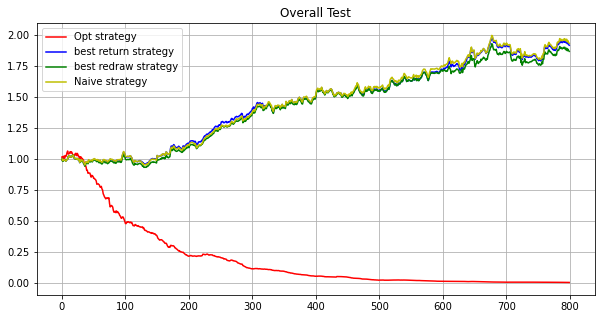

In [3]:
lb = 5
maxiter = 8000
subn = 100
path ='./tmp2/res_phase%02d_iter%d_subn%d_lb%d.npz'
gamma = 3
c = 0.0001
run(path, maxiter, subn, lb, testv=np.arange(-0.02, 0.0100001, 0.002), gamma=gamma, c=c)

Phase 4
Validating...
./tmp2/res_phase04_iter8000_subn100_lb5.npz
Opt strategy
[0.     0.     0.     0.     0.0459 0.0028 0.     0.     0.     0.025
 0.     0.     0.     0.     0.0007 0.     0.     0.0002 0.     0.
 0.     0.158  0.     0.     0.     0.0059 0.     0.     0.     0.
 0.     0.0039 0.     0.     0.036  0.     0.     0.0547 0.     0.
 0.01   0.     0.0745 0.     0.0574 0.     0.0262 0.     0.     0.2076
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.1113 0.075  0.     0.     0.     0.     0.     0.     0.0537
 0.01   0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.01   0.     0.     0.0211 0.     0.     0.01  ]
[ 0.0007 -0.     -0.     -0.      0.0015 -0.      0.0268 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.0927  0.0099 -0.     -0.     -0.     -0.     -0.
  0.0307  0.0467 -0.     -0.

[ 0.      0.      0.      0.      0.0102  0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.0371  0.      0.      0.
  0.      0.      0.      0.      0.0013  0.      0.     -0.      0.
  0.      0.      0.      0.      0.1098  0.      0.0268  0.      0.
  0.      0.      0.0626  0.1075  0.129   0.      0.      0.1254  0.
  0.     -0.      0.      0.0334  0.      0.     -0.      0.     -0.
  0.      0.      0.      0.      0.      0.0633  0.      0.      0.0635
  0.      0.      0.0418 -0.      0.      0.043   0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.0158
  0.1279  0.      0.      0.      0.      0.      0.      0.      0.
  0.    ]
[ 0.      0.      0.      0.1259  0.096   0.      0.      0.      0.
  0.0054  0.      0.      0.      0.      0.      0.      0.0398  0.
  0.      0.      0.      0.      0.      0.      0.     -0.      0.
  0.      0.    

[0.     0.     0.     0.     0.     0.0122 0.0216 0.     0.     0.0147
 0.     0.     0.     0.0194 0.0186 0.     0.     0.     0.     0.
 0.0824 0.0279 0.     0.     0.     0.     0.     0.1635 0.0013 0.
 0.     0.     0.     0.0928 0.     0.     0.     0.     0.0624 0.
 0.0454 0.     0.022  0.     0.004  0.     0.     0.     0.     0.
 0.     0.0063 0.     0.     0.0026 0.     0.     0.     0.     0.0631
 0.     0.0396 0.     0.     0.     0.     0.     0.     0.0321 0.0065
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.1664
 0.     0.     0.0475 0.     0.     0.     0.     0.     0.0001 0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0442]
[ 0.      0.      0.      0.      0.     -0.     -0.      0.      0.
  0.0089  0.      0.      0.     -0.      0.029   0.      0.     -0.
  0.      0.     -0.     -0.      0.0386  0.      0.      0.0234  0.
  0.      0.      0.      0.      0.     -0.     -0.      0.      0.
  0.      0.0054 -0.      0.1307 

[ 0.      0.      0.      0.     -0.      0.0039  0.      0.025   0.
  0.003   0.      0.      0.      0.      0.0447  0.      0.0095  0.0238
  0.      0.      0.      0.0012  0.0357  0.     -0.      0.      0.0351
 -0.      0.      0.     -0.      0.1343  0.      0.0769  0.1692 -0.
  0.      0.      0.0405  0.      0.      0.      0.0322  0.      0.0009
  0.1483 -0.     -0.      0.      0.      0.     -0.     -0.      0.
  0.      0.0196  0.      0.      0.      0.1166  0.      0.      0.
  0.      0.     -0.      0.0747  0.     -0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.     -0.
  0.     -0.      0.      0.      0.      0.      0.      0.     -0.
 -0.      0.      0.      0.      0.      0.      0.      0.      0.
 -0.    ]
[ 0.0009  0.      0.      0.      0.      0.0182  0.      0.      0.
  0.      0.      0.      0.      0.      0.0304  0.      0.      0.0377
  0.      0.      0.0223  0.      0.      0.      0.011   0.      0.
  0.0754

[-0.     -0.     -0.     -0.     -0.      0.0179  0.0047  0.0075 -0.
  0.0126 -0.      0.0007 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.0273  0.0918 -0.     -0.      0.0268  0.0215 -0.
  0.0241 -0.      0.     -0.      0.      0.0139  0.0009  0.      0.003
 -0.      0.0695 -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.     -0.     -0.     -0.      0.0272  0.1829 -0.     -0.
  0.0698 -0.     -0.     -0.      0.0378 -0.      0.0277  0.0468 -0.
  0.     -0.      0.0575 -0.      0.     -0.      0.      0.0083 -0.
  0.     -0.     -0.     -0.      0.1014 -0.     -0.      0.0596 -0.
 -0.      0.002  -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.0054 -0.      0.0451 -0.     -0.      0.     -0.     -0.
 -0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.      0.0077 -0.      0.0017
  0.      0.0014  0.0145 -0.     -0.     -0.     -0.     -0.      0.0327
 -0.     -0.      0.      0.1476 -0.     -0.      0.0071  0.     -0.
  0.     -0. 

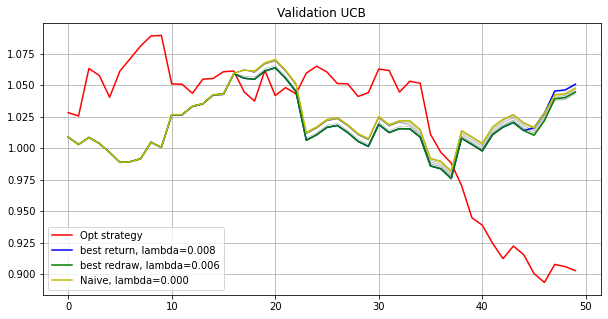

Testing...
./tmp2/res_phase04_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.01449593    Max redraw: 0.04741015
lambda: -0.018   Total log return: 0.01716019    Max redraw: 0.04741015
lambda: -0.016   Total log return: 0.02061541    Max redraw: 0.04741015
lambda: -0.014   Total log return: 0.02000184    Max redraw: 0.04741015
lambda: -0.012   Total log return: 0.01634502    Max redraw: 0.04741015
lambda: -0.010   Total log return: 0.01472589    Max redraw: 0.04741015
lambda: -0.008   Total log return: 0.01082606    Max redraw: 0.04741015
lambda: -0.006   Total log return: 0.01604362    Max redraw: 0.04741015
lambda: -0.004   Total log return: 0.02503168    Max redraw: 0.04741015
lambda: -0.002   Total log return: 0.03747112    Max redraw: 0.04741015
lambda: -0.000   Total log return: 0.03954515    Max redraw: 0.04741015
lambda: 0.002   Total log return: 0.04020998    Max redraw: 0.04741015
lambda: 0.004   Total log return: 0.03820739    Max redraw: 0.0474101

[ 0.0011 -0.     -0.     -0.      0.0609  0.0093  0.     -0.     -0.
  0.0657  0.0051 -0.     -0.     -0.      0.     -0.     -0.      0.0692
 -0.     -0.      0.0436 -0.     -0.     -0.     -0.      0.0031 -0.
 -0.      0.0318  0.057  -0.     -0.      0.004   0.021  -0.      0.
  0.0399 -0.     -0.     -0.     -0.     -0.      0.0142 -0.     -0.
 -0.     -0.      0.     -0.     -0.      0.0124  0.0045 -0.     -0.
  0.0102 -0.     -0.     -0.     -0.     -0.     -0.      0.0296 -0.
 -0.     -0.      0.0138  0.     -0.     -0.      0.0052  0.029  -0.
  0.     -0.     -0.      0.0402  0.     -0.     -0.      0.0969 -0.
 -0.     -0.     -0.      0.0265 -0.     -0.     -0.      0.0095  0.2533
 -0.     -0.     -0.      0.0282 -0.     -0.      0.0132 -0.     -0.
  0.    ]
[ 0.      0.      0.     -0.      0.0104  0.024   0.0264  0.      0.
  0.      0.      0.0082  0.      0.0204  0.      0.      0.      0.0804
  0.      0.      0.     -0.      0.      0.      0.      0.0171  0.
 -0.      0.

[ 0.     -0.      0.      0.     -0.      0.     -0.      0.0115  0.0006
  0.     -0.      0.     -0.     -0.      0.0403  0.      0.0823  0.
 -0.      0.      0.0153  0.1255  0.     -0.      0.     -0.      0.
  0.0084  0.     -0.     -0.     -0.      0.      0.     -0.     -0.
  0.      0.      0.0108  0.      0.     -0.     -0.     -0.      0.
  0.      0.      0.     -0.      0.1515  0.      0.      0.      0.
 -0.     -0.     -0.     -0.     -0.      0.1082  0.      0.     -0.
 -0.      0.      0.      0.0434 -0.      0.1665  0.     -0.     -0.
  0.     -0.      0.     -0.      0.0058 -0.      0.      0.191   0.0071
  0.     -0.     -0.      0.     -0.     -0.     -0.      0.      0.
  0.     -0.     -0.     -0.      0.     -0.      0.0241  0.0047 -0.
 -0.    ]
[-0.     -0.     -0.      0.066  -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.0134 -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.0914 -0.      0.0012  0.0519  0.0067  0.0777
  0.0084 -0.

[-0.     -0.     -0.      0.0085 -0.     -0.     -0.     -0.      0.0104
 -0.     -0.     -0.     -0.      0.0077 -0.     -0.     -0.      0.0058
 -0.     -0.     -0.      0.0958 -0.     -0.      0.0023  0.0076 -0.
 -0.      0.0058 -0.     -0.      0.1397  0.0002  0.1034 -0.      0.0039
  0.035  -0.      0.0316 -0.     -0.      0.0005  0.022  -0.     -0.
 -0.     -0.     -0.      0.0072 -0.      0.0167  0.011  -0.     -0.
  0.0058 -0.     -0.     -0.      0.0026 -0.     -0.      0.0558 -0.
 -0.     -0.      0.0208 -0.     -0.      0.0931  0.0496  0.0042 -0.
 -0.     -0.     -0.      0.037   0.0959 -0.     -0.      0.0508 -0.
 -0.      0.0292  0.0164 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.0087 -0.     -0.      0.0106 -0.     -0.
 -0.    ]
[-0.     -0.     -0.      0.      0.0349  0.0182  0.0052 -0.      0.
  0.0291 -0.      0.     -0.      0.     -0.     -0.      0.      0.0274
 -0.     -0.     -0.      0.     -0.      0.      0.      0.0043 -0.
 -0.    

[-0.     -0.     -0.     -0.      0.0436 -0.     -0.      0.      0.
  0.001  -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.0364 -0.      0.     -0.     -0.      0.0024 -0.
  0.0028  0.0376  0.0222 -0.      0.0354 -0.      0.0559  0.1546 -0.
 -0.     -0.      0.0212  0.      0.0053 -0.     -0.     -0.      0.
 -0.     -0.     -0.      0.0607 -0.     -0.      0.     -0.      0.
  0.0267 -0.     -0.     -0.      0.0083  0.0041 -0.      0.0758 -0.
 -0.     -0.      0.0261 -0.     -0.      0.1299 -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.0365 -0.     -0.      0.1742 -0.
 -0.      0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0332
  0.     -0.     -0.      0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.     -0.     -0.     -0.      0.0953  0.002  -0.     -0.     -0.
  0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0571  0.0302
 -0.     -0.      0.0364 -0.      0.0387 -0.     -0.      0.0146 -0.
  0.0064 -0.    

[ 0.0012  0.      0.      0.      0.      0.0096  0.0528  0.0168  0.0122
  0.0378  0.0001  0.0086  0.      0.      0.      0.      0.      0.0408
  0.      0.      0.0383  0.0637  0.      0.      0.      0.0357  0.0053
  0.0173  0.      0.0272  0.      0.      0.0076  0.      0.      0.
  0.      0.      0.0277  0.      0.      0.      0.0096  0.      0.
  0.      0.      0.0613  0.      0.      0.0136  0.0045  0.      0.
  0.0308  0.      0.      0.      0.      0.      0.0071  0.      0.
  0.      0.      0.0067  0.      0.      0.1019  0.      0.0253  0.
  0.0684  0.      0.      0.      0.      0.     -0.      0.      0.
  0.      0.0237  0.      0.0473  0.      0.      0.0455  0.0077  0.
  0.      0.      0.      0.      0.      0.      0.0745  0.     -0.
  0.0617]
[ 0.0002 -0.      0.      0.      0.0304  0.022  -0.     -0.     -0.
 -0.     -0.     -0.      0.      0.      0.0055  0.      0.0398  0.0547
  0.      0.      0.0129 -0.      0.0087  0.      0.0584  0.0482 -0.
  0.0074

[-0.     -0.     -0.     -0.      0.0872  0.0065  0.0153 -0.     -0.
  0.0343  0.      0.     -0.     -0.     -0.     -0.      0.0046 -0.
 -0.     -0.      0.0571 -0.     -0.     -0.     -0.      0.059  -0.
 -0.     -0.      0.      0.1489  0.0286  0.0055  0.0861  0.028   0.
 -0.      0.0589  0.     -0.     -0.     -0.     -0.      0.0264  0.
  0.0025  0.0608 -0.     -0.      0.      0.0111 -0.      0.0328  0.
  0.0036 -0.     -0.     -0.     -0.      0.0332 -0.     -0.      0.
 -0.     -0.      0.      0.     -0.      0.0423  0.      0.0198 -0.
 -0.     -0.     -0.     -0.      0.0992  0.0233 -0.      0.016  -0.
  0.      0.      0.      0.     -0.     -0.      0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.      0.     -0.
 -0.    ]
[-0.     -0.     -0.     -0.      0.      0.0234  0.      0.0118  0.0044
  0.      0.      0.      0.      0.0173  0.      0.      0.      0.0691
  0.      0.      0.0073  0.      0.      0.      0.      0.0211  0.
  0.1007  0.0196

[ 0.002   0.      0.      0.      0.      0.      0.0265 -0.      0.0109
  0.      0.      0.0128  0.      0.      0.      0.     -0.      0.0286
  0.0126  0.      0.0951  0.1822  0.      0.      0.     -0.      0.
  0.      0.     -0.      0.      0.      0.0032  0.      0.0455  0.006
  0.      0.      0.      0.      0.0425  0.     -0.      0.      0.
  0.      0.0268  0.0195  0.      0.      0.0274  0.      0.     -0.
  0.0221  0.      0.      0.0043  0.      0.      0.      0.0541  0.
  0.      0.      0.0241  0.001   0.      0.0138  0.      0.0377  0.
  0.0121  0.0113  0.      0.     -0.      0.      0.      0.0404  0.
  0.      0.0023  0.     -0.      0.      0.      0.      0.03    0.0291
  0.      0.      0.      0.0044  0.      0.      0.0337  0.1276  0.
  0.    ]
[ 0.0032 -0.     -0.      0.      0.0142  0.0128 -0.     -0.     -0.
  0.      0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0162
 -0.      0.0037  0.0051  0.0566  0.     -0.     -0.      0.0347  0.
  0.0

[ 0.0027 -0.     -0.      0.0042  0.      0.03    0.0253  0.      0.
  0.     -0.     -0.     -0.     -0.     -0.     -0.      0.034   0.0049
 -0.     -0.      0.0177  0.0143 -0.     -0.      0.0365  0.0376 -0.
  0.009  -0.      0.002  -0.     -0.      0.0074  0.      0.0029  0.
  0.0361  0.     -0.      0.     -0.     -0.      0.      0.0479  0.0608
 -0.      0.     -0.      0.     -0.      0.     -0.     -0.     -0.
  0.0042 -0.     -0.      0.      0.0495 -0.     -0.      0.119   0.
  0.     -0.      0.     -0.      0.0001 -0.      0.0654  0.0472 -0.
  0.     -0.     -0.     -0.      0.093  -0.     -0.      0.064  -0.
 -0.      0.      0.021  -0.     -0.     -0.     -0.      0.0144 -0.
 -0.      0.0082  0.0078  0.0199  0.0248 -0.      0.0676 -0.     -0.
  0.0088]
[ 0.0018 -0.     -0.      0.      0.      0.0137  0.0514  0.0216  0.
  0.0311 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.021
 -0.     -0.      0.      0.0914  0.0917 -0.      0.      0.0069 -0.
  0.     -0. 

[ 0.0036  0.     -0.     -0.      0.      0.0108  0.      0.      0.
  0.0309  0.0033  0.      0.      0.      0.      0.      0.0764  0.0105
  0.      0.1156  0.      0.0561  0.      0.      0.0086  0.0467  0.
  0.0103  0.      0.      0.      0.      0.0162  0.      0.      0.013
  0.      0.054   0.0226  0.      0.      0.      0.      0.     -0.
  0.      0.0206  0.      0.0257  0.      0.018   0.     -0.      0.
  0.0271  0.      0.0015  0.0319  0.      0.1173  0.      0.      0.
  0.      0.      0.      0.      0.      0.     -0.      0.0392  0.
  0.0395  0.      0.      0.      0.      0.      0.      0.0582  0.0065
 -0.      0.      0.0008  0.      0.      0.      0.0446  0.0425  0.
  0.      0.      0.      0.      0.      0.      0.0256  0.      0.
  0.0089]
[ 0.      0.      0.      0.      0.0271  0.      0.      0.      0.
 -0.     -0.      0.      0.      0.      0.      0.     -0.      0.
  0.      0.0209  0.013  -0.      0.      0.      0.0086 -0.      0.077
  0.      

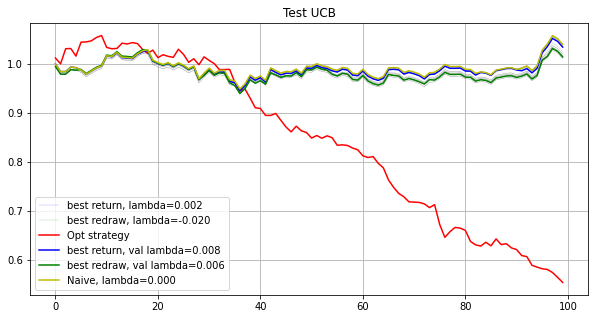

Phase 5
Validating...
./tmp2/res_phase05_iter8000_subn100_lb5.npz
Opt strategy
[-0.      0.0065  0.0151 -0.     -0.      0.0051 -0.      0.0123 -0.
 -0.     -0.     -0.     -0.      0.0039  0.0197  0.0352  0.002  -0.
  0.0103 -0.      0.0444  0.01    0.0026  0.0265  0.0326 -0.     -0.
  0.01   -0.     -0.     -0.      0.0341 -0.     -0.     -0.     -0.
 -0.     -0.      0.0393 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.0044  0.0043 -0.     -0.      0.1025  0.0331
 -0.     -0.     -0.      0.0454 -0.      0.0032  0.0221 -0.     -0.
  0.0279  0.09    0.0043 -0.     -0.      0.0524 -0.     -0.      0.0135
  0.0454 -0.     -0.     -0.     -0.      0.0567  0.0342 -0.      0.0281
  0.01   -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.0406  0.0133 -0.     -0.     -0.     -0.      0.0061 -0.
  0.0527]
[0.     0.0064 0.0542 0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.0446 0.0159 0.     0.     0.0691 0.
 0.004

[-0.      0.0067  0.0184 -0.     -0.     -0.     -0.      0.0169 -0.
 -0.     -0.     -0.      0.0082 -0.      0.0045 -0.     -0.     -0.
 -0.     -0.      0.0377  0.0263 -0.     -0.     -0.     -0.     -0.
  0.0407 -0.     -0.     -0.      0.0032 -0.     -0.     -0.     -0.
 -0.     -0.      0.0339  0.0774 -0.      0.     -0.     -0.     -0.
 -0.      0.035  -0.      0.0034 -0.     -0.     -0.      0.0349  0.0515
 -0.     -0.     -0.      0.0287  0.0003 -0.      0.0103 -0.     -0.
 -0.      0.0355 -0.     -0.      0.0269  0.0298 -0.     -0.      0.1043
 -0.      0.158  -0.     -0.     -0.      0.0456  0.0076 -0.     -0.
  0.0069 -0.      0.0859  0.0505 -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.0096 -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.      0.0084  0.0176 -0.     -0.      0.0128 -0.      0.0013  0.0432
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.0142 -0.     -0.     -0.     -0.     -0.
 -0.     -0.

[ 0.0044  0.006   0.0154 -0.     -0.      0.01   -0.     -0.      0.0079
 -0.     -0.     -0.     -0.     -0.      0.0321  0.0897 -0.      0.0431
 -0.     -0.     -0.      0.015  -0.     -0.      0.021  -0.     -0.
 -0.     -0.     -0.     -0.      0.0975 -0.     -0.     -0.      0.0094
  0.0173 -0.      0.0032 -0.      0.0076  0.1009 -0.      0.0023 -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0745  0.0447
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.0537  0.0416 -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.0129  0.0256  0.1721 -0.
 -0.     -0.      0.0563  0.0249 -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.0079 -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[ 0.0033  0.0056  0.0425 -0.     -0.      0.0231 -0.     -0.     -0.
 -0.     -0.     -0.      0.0033 -0.      0.0596  0.0268 -0.      0.0103
  0.0152 -0.     -0.      0.0185 -0.      0.0228  0.0269 -0.     -0.
 -0.

[-0.      0.0055 -0.      0.0189  0.      0.021   0.      0.0111  0.0087
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.0591
  0.      0.      0.      0.      0.0058  0.0472  0.2207  0.      0.0092
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.0201  0.      0.      0.      0.      0.0805  0.0315
  0.      0.      0.      0.      0.0203  0.0549  0.      0.      0.
  0.0385  0.0632  0.     -0.      0.      0.01    0.      0.      0.0088
  0.      0.0875  0.      0.      0.      0.0103  0.      0.      0.0131
  0.0105 -0.      0.0242 -0.      0.      0.      0.      0.      0.
  0.      0.0734  0.      0.      0.      0.0416  0.      0.      0.
  0.    ]
[-0.      0.0103 -0.      0.      0.      0.0324  0.      0.0027  0.
  0.      0.      0.      0.      0.      0.0397  0.0634  0.      0.
  0.      0.      0.0608  0.0332  0.0106  0.0026  0.0025  0.      0.


[ 0.0005  0.0066  0.     -0.      0.      0.0133  0.      0.      0.
  0.      0.0042  0.      0.      0.      0.0469 -0.      0.      0.0159
  0.0617  0.      0.0134  0.028  -0.      0.0292  0.0288 -0.     -0.
  0.0177  0.      0.     -0.      0.0173  0.      0.      0.      0.
 -0.     -0.      0.0123 -0.      0.      0.0215  0.     -0.     -0.
  0.0012  0.      0.0224  0.012   0.      0.056   0.0346  0.116   0.045
  0.      0.0428  0.      0.0529  0.0166 -0.      0.0284  0.      0.0201
 -0.      0.0418  0.     -0.     -0.      0.0358  0.      0.      0.0326
  0.     -0.      0.      0.     -0.      0.0099  0.0105 -0.      0.0044
  0.      0.      0.      0.0926  0.      0.      0.      0.     -0.
 -0.     -0.      0.0011 -0.      0.      0.     -0.      0.      0.
  0.    ]
[ 0.      0.0094  0.      0.      0.      0.0015  0.0015  0.0318  0.
  0.      0.      0.      0.      0.      0.0462  0.      0.      0.
  0.      0.      0.      0.0442  0.0038  0.0426  0.      0.     -0.
  0. 

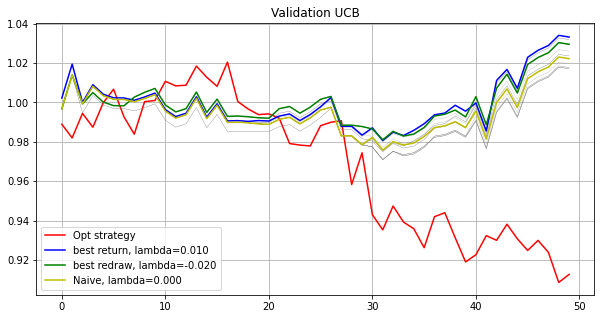

Testing...
./tmp2/res_phase05_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.09457053    Max redraw: 0.05127117
lambda: -0.018   Total log return: 0.09657663    Max redraw: 0.05127117
lambda: -0.016   Total log return: 0.07670235    Max redraw: 0.05127117
lambda: -0.014   Total log return: 0.06304404    Max redraw: 0.05127117
lambda: -0.012   Total log return: 0.06297960    Max redraw: 0.05127117
lambda: -0.010   Total log return: 0.07044942    Max redraw: 0.05127117
lambda: -0.008   Total log return: 0.07622245    Max redraw: 0.05127117
lambda: -0.006   Total log return: 0.07791816    Max redraw: 0.05127117
lambda: -0.004   Total log return: 0.07111208    Max redraw: 0.05129385
lambda: -0.002   Total log return: 0.07111208    Max redraw: 0.05129385
lambda: -0.000   Total log return: 0.06776157    Max redraw: 0.05129385
lambda: 0.002   Total log return: 0.07697366    Max redraw: 0.05129385
lambda: 0.004   Total log return: 0.07856000    Max redraw: 0.0497349

[ 0.0033  0.0089 -0.      0.0206 -0.     -0.      0.002   0.0148  0.0539
 -0.     -0.      0.      0.0037  0.0035  0.0047 -0.      0.      0.0668
 -0.     -0.      0.      0.0174  0.0029  0.     -0.      0.     -0.
 -0.     -0.      0.0077  0.      0.      0.0305 -0.      0.0073  0.0374
 -0.      0.      0.0224  0.      0.      0.     -0.      0.     -0.
  0.      0.      0.0205  0.0207 -0.      0.0549  0.      0.      0.0572
  0.     -0.     -0.      0.0215  0.0379  0.      0.      0.0217 -0.
  0.      0.0891 -0.      0.     -0.      0.0475 -0.     -0.      0.
 -0.      0.0258  0.     -0.      0.     -0.      0.0272  0.1052 -0.
  0.0092 -0.      0.029   0.0961  0.0001 -0.     -0.     -0.     -0.
 -0.      0.0205  0.0068 -0.     -0.     -0.     -0.      0.      0.
 -0.    ]
[ 0.0015  0.0089  0.      0.      0.      0.0138  0.      0.      0.
 -0.      0.      0.      0.0046  0.0002  0.0604  0.0229  0.      0.013
 -0.      0.      0.      0.0342  0.0021  0.0223 -0.      0.     -0.
 -0. 

[0.0079 0.0055 0.0047 0.     0.     0.0118 0.     0.     0.     0.
 0.     0.     0.     0.     0.053  0.     0.1017 0.     0.     0.
 0.     0.014  0.     0.     0.0178 0.0015 0.     0.0314 0.     0.
 0.     0.0166 0.     0.0186 0.     0.0782 0.     0.     0.0762 0.
 0.     0.0912 0.     0.     0.     0.     0.     0.     0.0166 0.
 0.     0.0114 0.0582 0.0292 0.     0.0255 0.     0.     0.1207 0.0219
 0.     0.0142 0.     0.     0.     0.     0.02   0.     0.0244 0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.01   0.0273
 0.     0.     0.     0.0143 0.0604 0.     0.     0.     0.     0.
 0.013  0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[0.     0.0047 0.     0.     0.     0.0041 0.     0.0127 0.     0.
 0.     0.     0.     0.     0.0778 0.     0.     0.     0.0055 0.
 0.     0.0722 0.     0.0081 0.0037 0.     0.     0.0314 0.     0.
 0.     0.     0.     0.     0.0125 0.0462 0.0579 0.     0.0336 0.
 0.0444 0.0702 0.     0.     0.     0.     0.    

[ 0.0222  0.0028 -0.      0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.     -0.      0.0253 -0.      0.      0.0149
 -0.     -0.      0.0329  0.0135 -0.      0.0409 -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.0119 -0.      0.0022 -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.0576 -0.     -0.     -0.
 -0.      0.     -0.     -0.     -0.     -0.     -0.      0.0152  0.0635
 -0.      0.0438 -0.     -0.      0.1227  0.0017  0.      0.0197 -0.
  0.      0.0849 -0.      0.     -0.      0.0083 -0.     -0.      0.
 -0.      0.0846 -0.     -0.     -0.      0.0904  0.0052 -0.     -0.
 -0.      0.0252  0.0603  0.0216 -0.     -0.     -0.     -0.     -0.
  0.034  -0.     -0.      0.0904 -0.     -0.     -0.     -0.     -0.
  0.    ]
[ 0.      0.      0.      0.      0.      0.      0.     -0.      0.0493
  0.      0.      0.      0.      0.     -0.      0.      0.     -0.
  0.0229  0.     -0.     -0.      0.      0.0245  0.      0.      0.
  0.      0.

[-0.      0.0052 -0.      0.0048 -0.      0.     -0.      0.0181  0.0368
 -0.     -0.     -0.     -0.     -0.      0.0745  0.0912 -0.      0.0196
  0.0167 -0.      0.0183  0.017   0.0008 -0.     -0.     -0.     -0.
  0.0174  0.     -0.     -0.      0.0313  0.0449 -0.      0.0407  0.0308
  0.019   0.      0.0006  0.      0.0432  0.0432  0.      0.      0.
 -0.      0.      0.0173  0.      0.     -0.      0.      0.0085  0.03
 -0.     -0.     -0.     -0.      0.0027 -0.      0.0028 -0.     -0.
  0.0239  0.     -0.      0.      0.0287  0.008   0.0173 -0.      0.
 -0.      0.0258  0.     -0.     -0.      0.0203  0.0229 -0.      0.0062
  0.0123  0.0553  0.0482  0.0902 -0.      0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.      0.0049  0.0082  0.     -0.      0.     -0.      0.      0.
 -0.     -0.     -0.     -0.      0.      0.      0.0981  0.0114  0.0315
  0.     -0.      0.      0.0367  0.      0.0242  0.      0.     -0.
  

[-0.      0.0071 -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.0562 -0.     -0.     -0.
 -0.     -0.      0.0177 -0.     -0.      0.0734  0.0051 -0.      0.0013
  0.0506 -0.     -0.     -0.      0.001  -0.     -0.      0.0491 -0.
 -0.     -0.      0.0049 -0.     -0.      0.0603 -0.     -0.      0.0259
 -0.     -0.      0.0336  0.015  -0.     -0.     -0.      0.     -0.
 -0.     -0.     -0.      0.0057  0.0285 -0.      0.0209  0.0489 -0.
  0.0046  0.0732 -0.      0.0524  0.0996  0.0458 -0.     -0.      0.
 -0.     -0.     -0.      0.0113 -0.      0.0287 -0.     -0.     -0.
 -0.     -0.     -0.      0.0843 -0.     -0.     -0.     -0.     -0.
 -0.      0.0877 -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.      0.0003 -0.     -0.     -0.     -0.     -0.      0.0136  0.1432
 -0.     -0.     -0.     -0.     -0.      0.0562  0.0353 -0.     -0.
 -0.     -0.      0.0179 -0.     -0.      0.      0.      0.      0.
  0.     -0.

[ 0.      0.0048  0.      0.      0.      0.      0.      0.0106  0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.0699
  0.0493  0.      0.0491  0.0387  0.      0.0307  0.      0.0188  0.0368
  0.0282  0.     -0.      0.      0.0271  0.      0.      0.0673  0.
  0.      0.      0.0651  0.      0.0724  0.      0.      0.      0.
  0.      0.      0.0847  0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.0163  0.0088  0.0255  0.
  0.      0.0301  0.      0.      0.0499  0.0148  0.      0.      0.0223
  0.      0.      0.      0.      0.      0.0932  0.0254  0.      0.
  0.      0.      0.0249  0.      0.0183  0.      0.      0.      0.
  0.      0.      0.0084  0.      0.      0.      0.      0.      0.
  0.    ]
[0.     0.0039 0.     0.     0.     0.     0.     0.0106 0.     0.
 0.     0.     0.     0.     0.0418 0.     0.0553 0.0221 0.     0.
 0.038  0.     0.     0.0057 0.0096 0.0108 0.     0.     0.     0.0129
 0.     0.    

[-0.      0.0038  0.0404  0.     -0.      0.0265 -0.      0.0293 -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.     -0.      0.0443
  0.0361 -0.     -0.      0.0006  0.      0.0107  0.0192 -0.      0.0318
 -0.     -0.     -0.      0.0579  0.1193 -0.      0.0028  0.0252 -0.
 -0.      0.0413  0.002  -0.      0.0733  0.     -0.      0.     -0.
  0.      0.      0.0617 -0.      0.      0.0482 -0.      0.0951  0.0454
  0.0019 -0.     -0.      0.     -0.     -0.      0.0292 -0.     -0.
  0.     -0.     -0.     -0.     -0.      0.0403  0.     -0.      0.0041
 -0.     -0.     -0.     -0.     -0.     -0.      0.0185  0.0344 -0.
 -0.     -0.     -0.      0.0059 -0.     -0.      0.     -0.     -0.
 -0.     -0.      0.0058  0.     -0.      0.001  -0.     -0.      0.
  0.0338]
[-0.      0.0033  0.0218  0.0092 -0.      0.0159 -0.      0.0045 -0.
 -0.     -0.     -0.     -0.     -0.      0.0469  0.      0.0524 -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.0051 -0.      0.0263
 -0.

[ 0.      0.0056  0.      0.0715 -0.     -0.     -0.      0.     -0.
 -0.      0.     -0.      0.     -0.      0.      0.1817  0.0082  0.
  0.0001 -0.      0.0083  0.0181  0.0059  0.      0.0228  0.      0.
  0.0024 -0.     -0.      0.      0.      0.0712  0.      0.0527  0.0507
  0.     -0.      0.0255 -0.      0.0227  0.081  -0.      0.     -0.
 -0.     -0.      0.0176  0.0077  0.     -0.     -0.      0.      0.0416
  0.      0.      0.      0.0025  0.     -0.      0.0077  0.     -0.
 -0.      0.0439 -0.      0.      0.0091  0.0163 -0.     -0.      0.
 -0.     -0.      0.      0.      0.      0.      0.0078 -0.      0.
  0.      0.0558  0.0679  0.0818 -0.     -0.      0.     -0.     -0.
 -0.      0.      0.     -0.     -0.      0.      0.     -0.     -0.
 -0.    ]
[ 0.0108  0.0056  0.      0.      0.      0.0132  0.      0.0135  0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.0051
  0.0366  0.      0.0126  0.0065  0.      0.0409  0.      0.      0.
  0.      0.

[ 0.      0.0054  0.      0.      0.      0.0159  0.      0.      0.0134
 -0.     -0.     -0.      0.      0.0027  0.0419  0.      0.      0.
  0.057   0.      0.      0.0004  0.      0.0169  0.0198  0.0155  0.
  0.     -0.      0.0668  0.      0.1212  0.0545  0.      0.     -0.
  0.     -0.      0.0765  0.      0.0122  0.0283 -0.      0.005  -0.
  0.001   0.      0.     -0.      0.      0.      0.      0.      0.0315
 -0.      0.     -0.      0.0194  0.      0.      0.      0.      0.0086
  0.0461  0.0894 -0.      0.      0.0243  0.0282 -0.     -0.      0.
 -0.      0.     -0.      0.     -0.      0.      0.0354  0.0483 -0.
  0.0017  0.0428  0.      0.      0.0054  0.038   0.     -0.     -0.
  0.      0.      0.0088  0.     -0.     -0.      0.     -0.      0.
  0.0046]
[ 0.      0.0054  0.      0.0735  0.      0.0012  0.      0.0134  0.
  0.      0.      0.      0.      0.      0.0034  0.      0.      0.0446
  0.0079  0.      0.0162  0.018   0.      0.0235  0.      0.      0.
  0.    

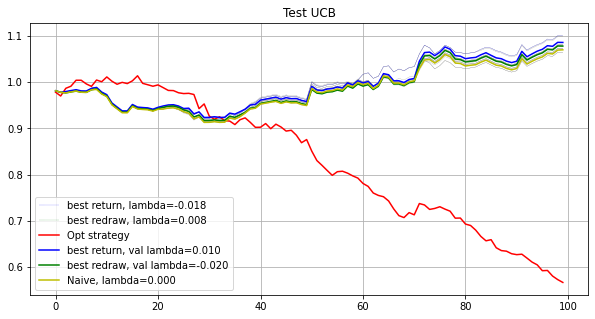

Phase 6
Validating...
./tmp2/res_phase06_iter8000_subn100_lb5.npz
Opt strategy
[0.     0.0005 0.     0.0086 0.0017 0.     0.     0.     0.     0.
 0.     0.0119 0.0093 0.     0.     0.     0.005  0.0022 0.     0.0896
 0.048  0.     0.     0.     0.     0.01   0.     0.     0.     0.0451
 0.     0.     0.     0.01   0.0012 0.0199 0.     0.0222 0.0179 0.
 0.     0.     0.     0.03   0.     0.     0.0571 0.     0.     0.
 0.     0.     0.     0.023  0.     0.     0.     0.     0.     0.
 0.     0.029  0.0386 0.0303 0.0432 0.0539 0.     0.0253 0.     0.
 0.     0.0549 0.     0.     0.     0.     0.     0.084  0.0077 0.0266
 0.     0.     0.     0.     0.     0.01   0.     0.     0.     0.
 0.     0.0128 0.     0.0015 0.006  0.     0.     0.0483 0.0628 0.0518]
[-0.     -0.     -0.     -0.     -0.      0.0008 -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.0122  0.0076 -0.     -0.      0.076  -0.
 -0.     -0.      0.0693 -0

[ 0.0025 -0.      0.      0.0038 -0.      0.0132  0.     -0.      0.
  0.      0.0276  0.0684 -0.     -0.     -0.      0.     -0.     -0.
 -0.     -0.      0.0183  0.036   0.0261  0.0035  0.      0.0429  0.
 -0.      0.      0.0313 -0.      0.0587 -0.     -0.     -0.     -0.
  0.0261  0.0075 -0.     -0.      0.057  -0.     -0.     -0.     -0.
 -0.      0.0273 -0.      0.      0.     -0.      0.0352  0.0093 -0.
 -0.     -0.      0.     -0.     -0.     -0.     -0.     -0.      0.0005
  0.0197 -0.      0.0946 -0.     -0.     -0.     -0.      0.      0.0074
  0.      0.0751  0.0221 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.      0.     -0.      0.      0.      0.2323 -0.
  0.     -0.      0.0273 -0.     -0.     -0.     -0.      0.      0.0059
  0.0189]
[-0.     -0.     -0.      0.0038  0.      0.0039 -0.     -0.     -0.
 -0.      0.0277 -0.     -0.     -0.      0.0242  0.      0.0265 -0.
  0.0485 -0.      0.0339 -0.     -0.      0.0285 -0.     -0.     -0.
 -0.     -0.

[-0.     -0.     -0.      0.0031  0.0022  0.0041 -0.     -0.      0.
 -0.     -0.      0.     -0.      0.     -0.     -0.     -0.      0.
 -0.      0.0095  0.0139  0.0243 -0.     -0.     -0.      0.0097  0.
  0.002  -0.      0.0389 -0.      0.0412 -0.     -0.      0.     -0.
 -0.     -0.      0.0175 -0.     -0.     -0.     -0.      0.     -0.
  0.0002 -0.     -0.      0.      0.     -0.      0.0951  0.0122 -0.
  0.     -0.      0.0879  0.0657  0.      0.      0.      0.0108  0.
  0.0972  0.0408  0.      0.1013  0.0323 -0.     -0.     -0.      0.1253
 -0.     -0.     -0.     -0.      0.      0.      0.0732 -0.     -0.
  0.0639 -0.      0.      0.     -0.      0.      0.0033 -0.      0.
  0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0215 -0.
 -0.    ]
[0.0074 0.0203 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.0236 0.     0.     0.     0.     0.     0.     0.1308 0.
 0.0633 0.0149 0.     0.     0.     0.0035 0.     0.     0.     0.0876
 0.     0.     0.     

[-0.      0.0041 -0.     -0.     -0.      0.0051 -0.     -0.     -0.
 -0.     -0.      0.0543 -0.      0.0488  0.1462  0.      0.0027 -0.
  0.1053 -0.      0.0354  0.0604 -0.     -0.     -0.      0.     -0.
  0.     -0.      0.0921 -0.     -0.     -0.     -0.      0.0233 -0.
  0.028   0.     -0.     -0.      0.0203 -0.      0.0192  0.0012 -0.
 -0.     -0.     -0.      0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.      0.      0.0003  0.0113
  0.0311  0.0121  0.0439 -0.      0.0373  0.     -0.     -0.      0.0065
 -0.     -0.     -0.     -0.      0.0242  0.     -0.      0.0153 -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.0528  0.     -0.      0.0324 -0.      0.0711  0.009
  0.0018]
[-0.      0.0265 -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.0306  0.098  -0.     -0.      0.0137  0.      0.0121 -0.
 -0.      0.0294  0.0151  0.0504  0.0002  0.0052 -0.      0.0319 -0.
  0.0306 -0. 

[ 0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.0255  0.0208  0.
  0.0258  0.      0.0232  0.0042  0.0029  0.      0.      0.0167  0.
  0.      0.      0.0701  0.      0.      0.      0.0786  0.      0.0557
  0.      0.      0.      0.0272  0.0475  0.      0.      0.      0.2096
  0.      0.0064  0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.0625  0.      0.0021  0.0049  0.      0.     -0.
  0.      0.      0.0258  0.      0.      0.0865  0.0561  0.094   0.
  0.      0.      0.0067  0.      0.      0.      0.      0.0214  0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.0198
  0.    ]
[0.     0.0083 0.     0.0068 0.0127 0.0057 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.0505 0.     0.0075 0.     0.     0.0232 0.     0.0099 0.     0.0073
 0.     0.    

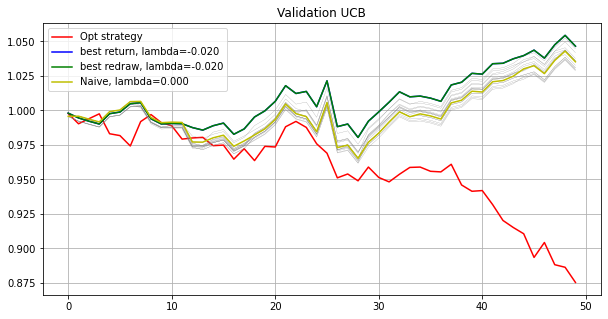

Testing...
./tmp2/res_phase06_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.20825661    Max redraw: 0.04421898
lambda: -0.018   Total log return: 0.20924816    Max redraw: 0.04421898
lambda: -0.016   Total log return: 0.21651083    Max redraw: 0.04421898
lambda: -0.014   Total log return: 0.21232723    Max redraw: 0.04421898
lambda: -0.012   Total log return: 0.21022755    Max redraw: 0.04421898
lambda: -0.010   Total log return: 0.20631076    Max redraw: 0.04421898
lambda: -0.008   Total log return: 0.20639946    Max redraw: 0.04421898
lambda: -0.006   Total log return: 0.20400683    Max redraw: 0.04421898
lambda: -0.004   Total log return: 0.19399370    Max redraw: 0.04421898
lambda: -0.002   Total log return: 0.20301120    Max redraw: 0.04421898
lambda: -0.000   Total log return: 0.20169129    Max redraw: 0.04421898
lambda: 0.002   Total log return: 0.19245404    Max redraw: 0.04421898
lambda: 0.004   Total log return: 0.18825244    Max redraw: 0.0442189

[-0.     -0.     -0.      0.0067 -0.      0.0072  0.      0.     -0.
  0.      0.      0.0154  0.0079  0.     -0.      0.      0.      0.
  0.      0.0367  0.0641  0.0139  0.034  -0.      0.      0.0243 -0.
  0.     -0.      0.0197  0.     -0.      0.      0.     -0.      0.0427
  0.013   0.0332  0.0094  0.     -0.      0.      0.      0.0344  0.1497
  0.0164  0.0921  0.      0.      0.      0.      0.0032  0.0034  0.
  0.      0.      0.      0.01    0.      0.      0.      0.0138  0.0277
  0.0585  0.      0.      0.      0.     -0.      0.      0.      0.0457
  0.      0.      0.      0.      0.      0.      0.0592  0.0504  0.0241
  0.     -0.      0.0108  0.      0.     -0.     -0.      0.      0.
  0.      0.      0.     -0.      0.      0.      0.      0.0018  0.0695
  0.    ]
[-0.      0.0105 -0.      0.0056 -0.     -0.     -0.      0.     -0.
 -0.      0.0018 -0.     -0.     -0.     -0.      0.0363 -0.     -0.
 -0.     -0.      0.0155 -0.      0.0366 -0.     -0.      0.0241 -0.


[-0.     -0.     -0.      0.0091 -0.     -0.     -0.     -0.     -0.
 -0.      0.0145 -0.     -0.     -0.      0.0044  0.0263  0.0284 -0.
 -0.      0.      0.0459 -0.      0.0208 -0.     -0.      0.0249 -0.
 -0.     -0.      0.0334  0.0073  0.0294 -0.     -0.     -0.      0.0078
 -0.      0.0273  0.0159  0.0002  0.0121 -0.     -0.      0.0141 -0.
 -0.      0.0164 -0.     -0.     -0.     -0.     -0.     -0.      0.0304
 -0.      0.      0.043  -0.     -0.      0.0141 -0.      0.0184  0.0201
 -0.      0.      0.0762 -0.      0.014  -0.     -0.     -0.      0.0232
 -0.     -0.     -0.     -0.     -0.      0.0808  0.0314  0.0396  0.0151
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0114 -0.
 -0.     -0.      0.0064 -0.      0.0591  0.     -0.      0.0856  0.0908
  0.    ]
[ 0.0061 -0.     -0.      0.0002 -0.      0.0012 -0.     -0.     -0.
 -0.      0.0076  0.0162 -0.     -0.     -0.      0.      0.     -0.
 -0.      0.      0.0389 -0.      0.054   0.0071 -0.      0.0546 -0.


[-0.     -0.     -0.      0.0024 -0.      0.0014 -0.     -0.     -0.
 -0.     -0.      0.0452 -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.0636  0.0123  0.0057  0.033   0.014  -0.      0.0875 -0.
 -0.     -0.      0.0272 -0.     -0.     -0.      0.0733  0.0084 -0.
  0.0502 -0.     -0.     -0.     -0.     -0.     -0.      0.0043 -0.
 -0.     -0.     -0.      0.0727 -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0154  0.0064
 -0.     -0.      0.0242 -0.      0.0272 -0.     -0.     -0.      0.0572
 -0.      0.     -0.     -0.     -0.      0.0902 -0.      0.0492  0.
 -0.      0.001  -0.     -0.     -0.     -0.     -0.      0.0811 -0.
 -0.     -0.      0.     -0.     -0.      0.07   -0.      0.      0.0734
 -0.    ]
[ 0.      0.     -0.      0.0051  0.      0.0047  0.     -0.      0.
  0.      0.0152  0.076   0.0012 -0.      0.     -0.      0.0089  0.
 -0.      0.0035  0.0441  0.06    0.      0.0439 -0.      0.0041  0.
  0.     -0.

[ 0.      0.      0.      0.0051  0.      0.      0.      0.      0.
  0.     -0.      0.      0.      0.      0.      0.      0.0213  0.
  0.058   0.      0.0328  0.0126  0.0408  0.0256  0.      0.012   0.
  0.      0.      0.0245  0.      0.0051  0.     -0.      0.      0.
  0.0387  0.      0.     -0.     -0.      0.      0.      0.      0.0051
  0.     -0.      0.     -0.      0.      0.      0.      0.0036  0.0186
  0.      0.0085  0.     -0.      0.      0.      0.      0.      0.0266
 -0.      0.      0.0337  0.      0.0505  0.0039  0.     -0.      0.0434
  0.      0.0179  0.0242  0.      0.      0.0585  0.     -0.      0.
  0.      0.     -0.      0.      0.2092  0.      0.      0.027  -0.
  0.      0.      0.      0.      0.008   0.0366  0.      0.      0.1428
 -0.    ]
[ 0.      0.0027  0.      0.0033  0.      0.      0.      0.      0.
  0.0116 -0.      0.      0.      0.      0.      0.      0.0059  0.
  0.058   0.      0.0267  0.      0.0054 -0.     -0.     -0.      0.
  0.

[0.     0.     0.     0.0009 0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.0132 0.     0.     0.0219 0.
 0.     0.     0.     0.     0.     0.0651 0.     0.     0.     0.005
 0.0719 0.     0.     0.     0.     0.     0.0732 0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.055  0.     0.0321 0.     0.0072 0.     0.
 0.0584 0.     0.0115 0.     0.     0.0711 0.0022 0.0281 0.     0.
 0.     0.0481 0.     0.0293 0.     0.     0.     0.0752 0.     0.
 0.     0.     0.     0.0375 0.     0.     0.     0.     0.     0.
 0.     0.     0.042  0.     0.0128 0.0155 0.     0.0742 0.1185 0.0233]
[ 0.      0.      0.      0.0053  0.      0.      0.      0.      0.
  0.      0.      0.      0.0068  0.     -0.      0.      0.009   0.
  0.     -0.      0.0629  0.0162  0.      0.      0.      0.0057  0.
  0.0509  0.      0.0174  0.      0.      0.      0.0102  0.0004  0.
  0.0411  0.0231  0.      0.      0.      0.  

[ 0.      0.      0.      0.0031  0.      0.      0.      0.      0.
  0.      0.001   0.      0.      0.      0.      0.0476  0.0153  0.
  0.      0.      0.0226  0.      0.      0.0136  0.      0.      0.
  0.      0.      0.0136  0.0716  0.      0.      0.      0.      0.
  0.0344  0.      0.      0.      0.      0.      0.      0.01    0.
  0.      0.      0.      0.      0.      0.      0.      0.0006  0.0034
  0.      0.      0.0052  0.      0.      0.      0.      0.      0.0064
  0.      0.      0.0222  0.      0.      0.      0.      0.      0.0445
  0.      0.0744  0.      0.      0.      0.0911  0.      0.0462  0.
  0.      0.0224  0.      0.      0.2371  0.      0.      0.      0.
  0.      0.      0.      0.0312  0.     -0.      0.      0.0801  0.0602
  0.034 ]
[ 0.      0.      0.      0.007   0.      0.0076  0.      0.      0.
  0.      0.      0.0083  0.      0.      0.      0.      0.      0.
  0.      0.0215  0.02    0.      0.0519  0.0362  0.      0.0745  0.
  0.    

[-0.     -0.     -0.      0.007  -0.      0.0125 -0.     -0.     -0.
 -0.      0.0089 -0.     -0.     -0.     -0.     -0.      0.0086 -0.
 -0.     -0.      0.0367 -0.     -0.     -0.     -0.      0.0357 -0.
  0.0054 -0.      0.0835 -0.      0.0291 -0.     -0.     -0.     -0.
  0.0401  0.0358 -0.     -0.     -0.     -0.     -0.      0.025  -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0204
 -0.     -0.     -0.     -0.      0.0169 -0.     -0.      0.0077 -0.
 -0.      0.0067  0.044  -0.      0.0308 -0.     -0.     -0.     -0.
 -0.      0.0498 -0.     -0.     -0.      0.0686 -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.2331 -0.
 -0.      0.0079 -0.     -0.     -0.     -0.     -0.      0.0872  0.0597
  0.0296]
[ 0.0011 -0.     -0.      0.0088 -0.      0.     -0.     -0.     -0.
 -0.      0.      0.0353  0.006  -0.      0.0188 -0.      0.015  -0.
 -0.     -0.      0.06   -0.     -0.     -0.     -0.      0.0357 -0.
  0.      0.0014

[-0.      0.     -0.     -0.     -0.     -0.     -0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.0167  0.
  0.0112  0.      0.      0.0249  0.      0.      0.      0.0281  0.
  0.      0.      0.0983  0.      0.      0.      0.      0.      0.0353
  0.0199  0.0426  0.011   0.      0.0845  0.      0.      0.018   0.
  0.      0.0142  0.      0.      0.      0.      0.0469  0.      0.
  0.      0.0132  0.      0.      0.031   0.      0.      0.0005  0.0062
  0.      0.0224  0.0718  0.      0.003   0.      0.      0.      0.0415
  0.      0.      0.0104  0.      0.      0.0137  0.056   0.1896  0.
  0.0573  0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.     -0.      0.0209
  0.    ]
[-0.      0.0218 -0.      0.0001 -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.0529 -0.      0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.0257  0.0366  0.      0.      0.1229 -0.
  0.    

[ 0.0044 -0.     -0.      0.0038 -0.     -0.     -0.     -0.     -0.
 -0.      0.0146  0.0414 -0.     -0.     -0.      0.      0.0083 -0.
 -0.     -0.      0.0031 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.0441 -0.      0.0162 -0.     -0.     -0.     -0.
 -0.      0.0032  0.0244  0.0127  0.0245 -0.     -0.      0.0171 -0.
 -0.      0.0663 -0.     -0.     -0.     -0.      0.004  -0.      0.0304
 -0.     -0.     -0.     -0.      0.0114 -0.     -0.      0.0015 -0.
 -0.      0.0318  0.0358  0.0105  0.02   -0.     -0.     -0.      0.0831
 -0.      0.0685 -0.     -0.     -0.      0.0984 -0.      0.1038 -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.0724  0.056  -0.     -0.      0.0246
  0.0515]
[ 0.     -0.     -0.      0.0038 -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.0045 -0.     -0.     -0.      0.     -0.     -0.
 -0.     -0.      0.0346 -0.     -0.      0.0418 -0.      0.0468 -0.
 -0.     -0.

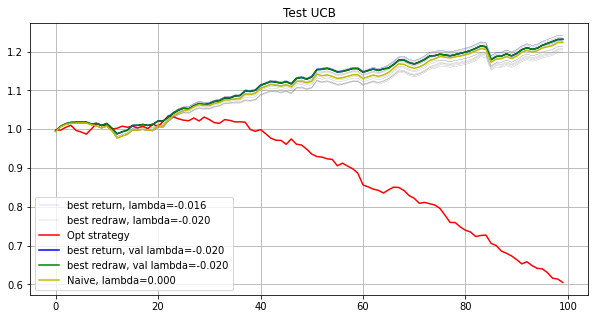

Phase 7
Validating...
./tmp2/res_phase07_iter8000_subn100_lb5.npz
Opt strategy
[0.     0.     0.0066 0.     0.0135 0.0073 0.     0.     0.     0.0197
 0.     0.     0.     0.0659 0.     0.     0.0106 0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0184
 0.     0.     0.0367 0.01   0.1167 0.     0.     0.     0.     0.0172
 0.     0.     0.0501 0.     0.     0.     0.     0.     0.0214 0.
 0.0288 0.0672 0.     0.0853 0.0452 0.     0.     0.     0.     0.
 0.0043 0.     0.02   0.     0.     0.0019 0.01   0.     0.0097 0.
 0.     0.01   0.     0.     0.     0.0018 0.     0.     0.     0.
 0.0139 0.     0.     0.     0.0368 0.     0.     0.0188 0.0973 0.1347
 0.     0.     0.     0.     0.     0.     0.01   0.     0.01   0.    ]
[ 0.0142 -0.      0.0066  0.0007  0.0117  0.0007 -0.     -0.     -0.
 -0.     -0.     -0.      0.0409 -0.     -0.      0.0121 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.007

[-0.     -0.      0.0113  0.0044  0.0016  0.0164  0.0019 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.0334  0.0312 -0.     -0.     -0.     -0.     -0.      0.005
 -0.     -0.      0.0623 -0.     -0.     -0.      0.011  -0.      0.0371
 -0.      0.0408 -0.     -0.     -0.     -0.      0.0396 -0.     -0.
 -0.      0.0443  0.0078  0.0349 -0.      0.0443 -0.      0.0196  0.0623
  0.0004 -0.     -0.     -0.      0.0028 -0.     -0.     -0.     -0.
 -0.      0.0013 -0.      0.0163 -0.     -0.     -0.     -0.      0.0043
 -0.      0.1183 -0.      0.0438  0.      0.0291 -0.      0.039   0.0374
 -0.     -0.     -0.      0.0133 -0.     -0.      0.0541  0.001  -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.1103 -0.      0.0178
 -0.    ]
[ 0.0042 -0.      0.0033  0.      0.0081  0.      0.     -0.     -0.
  0.0162 -0.     -0.     -0.     -0.     -0.      0.0546 -0.     -0.
 -0.      0.      0.     -0.     -0.      0.0209 -0.     -0.      0.
 

[-0.      0.      0.0105  0.      0.0169  0.      0.002   0.      0.
  0.0249  0.      0.      0.      0.      0.      0.      0.      0.
  0.016   0.      0.      0.0051  0.      0.      0.      0.      0.0025
  0.      0.      0.0599  0.      0.      0.0233  0.      0.      0.0252
  0.      0.0269  0.      0.      0.      0.      0.0625  0.      0.
  0.      0.0142  0.0115  0.0043  0.      0.0265  0.      0.      0.0437
  0.      0.      0.      0.0077  0.0082  0.      0.      0.0072  0.0741
  0.     -0.      0.      0.0002  0.      0.      0.      0.016   0.
  0.0261  0.1709  0.      0.0546  0.0102  0.     -0.      0.0292  0.
  0.0465  0.      0.      0.0651  0.      0.      0.015   0.0375  0.
  0.      0.      0.      0.      0.      0.      0.0153  0.      0.0372
  0.    ]
[ 0.      0.      0.0099  0.0011  0.015   0.      0.0013  0.      0.
  0.0265  0.      0.      0.      0.      0.      0.035   0.      0.
  0.0186  0.      0.0076  0.0477  0.      0.0418  0.      0.      0.0025


[-0.      0.      0.0092  0.0065  0.0148  0.0067  0.0025 -0.     -0.
  0.0349 -0.     -0.      0.      0.      0.      0.0169  0.0311  0.005
  0.0009  0.      0.0788  0.     -0.      0.      0.002   0.     -0.
  0.     -0.      0.0645  0.0075  0.     -0.     -0.     -0.      0.
  0.      0.0423  0.1378  0.0387  0.0169  0.      0.04    0.      0.
 -0.      0.021   0.      0.0155  0.      0.0446  0.      0.      0.0575
  0.     -0.      0.      0.     -0.      0.      0.0194  0.     -0.
 -0.      0.0093 -0.     -0.     -0.      0.     -0.     -0.      0.0676
 -0.      0.      0.0076  0.0165  0.      0.0436  0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.      0.0043
 -0.      0.1283 -0.     -0.     -0.     -0.     -0.      0.      0.0035
 -0.    ]
[ 0.0084  0.      0.0099  0.0016  0.013   0.      0.0019  0.      0.
  0.0221  0.      0.0153  0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.0036  0.0045  0.      0.      0.      0.
  0. 

[-0.     -0.      0.009   0.0002  0.0143  0.018   0.0012 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.0216  0.     -0.
  0.0082 -0.      0.0063  0.0116 -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.0191  0.0587 -0.     -0.      0.0393 -0.     -0.
 -0.     -0.      0.0931 -0.     -0.     -0.      0.0509  0.0013 -0.
  0.0092  0.0019 -0.     -0.     -0.      0.0113  0.0333  0.0545  0.0496
 -0.     -0.     -0.     -0.     -0.     -0.      0.0335 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.067   0.0339  0.0377 -0.     -0.     -0.
 -0.      0.0011  0.0484 -0.      0.0766 -0.     -0.      0.0137  0.0642
 -0.      0.0031 -0.     -0.     -0.     -0.      0.0262  0.0073  0.0088
  0.0602]
[ 0.0248 -0.      0.009   0.0037  0.0122  0.0212  0.0003 -0.     -0.
  0.0661 -0.     -0.     -0.      0.0102 -0.     -0.     -0.     -0.
  0.0212 -0.     -0.      0.0042 -0.     -0.     -0.     -0.     -0.
 -0.     -0.

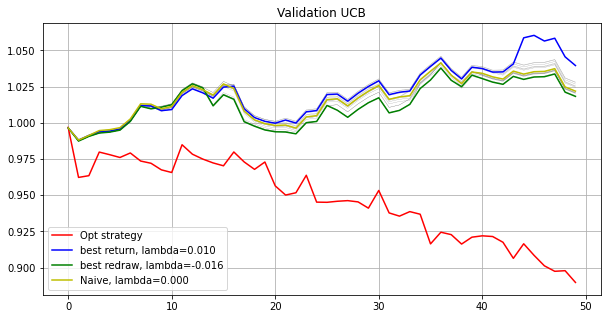

Testing...
./tmp2/res_phase07_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.09307256    Max redraw: 0.04027295
lambda: -0.018   Total log return: 0.09204683    Max redraw: 0.04117268
lambda: -0.016   Total log return: 0.09059912    Max redraw: 0.04117268
lambda: -0.014   Total log return: 0.09027487    Max redraw: 0.04117268
lambda: -0.012   Total log return: 0.09337694    Max redraw: 0.04117268
lambda: -0.010   Total log return: 0.09945863    Max redraw: 0.04027295
lambda: -0.008   Total log return: 0.10300035    Max redraw: 0.04027295
lambda: -0.006   Total log return: 0.10895820    Max redraw: 0.04027295
lambda: -0.004   Total log return: 0.10850160    Max redraw: 0.04027295
lambda: -0.002   Total log return: 0.10397950    Max redraw: 0.04027295
lambda: -0.000   Total log return: 0.09492290    Max redraw: 0.03980353
lambda: 0.002   Total log return: 0.09419810    Max redraw: 0.03980353
lambda: 0.004   Total log return: 0.07958077    Max redraw: 0.0398035

[ 0.0036  0.      0.0128  0.0058  0.0018  0.0004  0.0031  0.      0.
  0.0129 -0.      0.0185  0.      0.0329  0.      0.0193  0.      0.
  0.0043  0.      0.      0.0047  0.      0.      0.0231  0.      0.0047
 -0.      0.      0.0663  0.      0.     -0.      0.0269 -0.      0.0111
  0.      0.      0.1197 -0.      0.      0.      0.031   0.      0.0049
  0.      0.0065  0.      0.0034  0.      0.0525  0.      0.      0.0536
  0.013   0.      0.     -0.      0.0269  0.      0.077  -0.      0.0124
  0.      0.009   0.      0.0149  0.      0.0328  0.      0.0289  0.
 -0.      0.      0.      0.0825  0.      0.      0.      0.      0.0009
  0.      0.      0.0468  0.      0.      0.      0.0004  0.0226  0.0149
  0.      0.      0.0382  0.      0.0125  0.      0.      0.0095  0.0319
  0.    ]
[ 0.0103  0.      0.0101  0.001   0.0018 -0.     -0.      0.      0.
  0.018  -0.      0.0185  0.     -0.      0.     -0.     -0.      0.
  0.0069  0.0057  0.      0.0139  0.0138  0.0308  0.0652  0. 

[ 0.     -0.      0.0108  0.0029  0.0166  0.0082  0.0017  0.      0.
  0.019   0.      0.      0.      0.      0.     -0.     -0.      0.0062
  0.0197  0.      0.027   0.0173  0.     -0.      0.     -0.      0.0087
  0.     -0.      0.0347 -0.      0.     -0.      0.0149  0.     -0.
  0.0516  0.      0.      0.0246  0.     -0.      0.0621 -0.     -0.
  0.      0.0109  0.0034  0.0373  0.      0.0058  0.0507  0.0184  0.0079
  0.      0.     -0.     -0.      0.     -0.      0.0034  0.0074  0.
  0.      0.      0.0176 -0.      0.      0.      0.     -0.      0.
 -0.      0.     -0.      0.0528 -0.     -0.      0.      0.      0.0805
  0.      0.     -0.      0.008  -0.     -0.      0.0785  0.0911  0.
  0.     -0.     -0.      0.0664  0.0117  0.0228  0.018   0.0186  0.0602
 -0.    ]
[ 0.      0.      0.0055  0.      0.      0.      0.      0.      0.
  0.019   0.      0.      0.      0.0081  0.      0.      0.      0.
  0.0068  0.      0.016   0.0433  0.      0.0354  0.      0.      0.
  0.

[-0.     -0.      0.0129  0.0087  0.0117  0.0127  0.0063 -0.     -0.
  0.0428 -0.     -0.     -0.     -0.     -0.      0.0587  0.0228 -0.
  0.0558 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0116
 -0.     -0.      0.0213 -0.     -0.      0.0316  0.0311 -0.     -0.
 -0.     -0.     -0.     -0.      0.0101 -0.      0.0788 -0.     -0.
  0.0241  0.0363 -0.     -0.     -0.      0.0498  0.0391 -0.      0.055
 -0.     -0.     -0.     -0.     -0.     -0.      0.0544 -0.     -0.
 -0.     -0.     -0.      0.0258 -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.0173  0.0041 -0.     -0.     -0.      0.0276
 -0.     -0.      0.0549 -0.     -0.     -0.     -0.      0.0051  0.0501
 -0.      0.0923 -0.     -0.     -0.     -0.     -0.     -0.      0.0431
 -0.    ]
[-0.     -0.      0.0068  0.0013  0.0154  0.      0.     -0.     -0.
  0.0432 -0.      0.0058 -0.     -0.     -0.      0.0369 -0.     -0.
  0.0258 -0.     -0.      0.0443 -0.     -0.     -0.     -0.     -0.
 -0. 

[ 0.      0.      0.0096  0.003   0.0062  0.0098  0.0033  0.      0.
  0.0129  0.      0.      0.      0.      0.      0.      0.      0.
  0.0504  0.     -0.      0.      0.      0.     -0.      0.      0.0056
  0.      0.      0.0571  0.      0.      0.0267  0.008   0.      0.0104
  0.      0.      0.      0.0431  0.      0.      0.0661 -0.      0.
 -0.      0.0061  0.      0.0063 -0.      0.0344  0.0825  0.151   0.0552
  0.      0.      0.      0.      0.     -0.      0.     -0.      0.
  0.      0.      0.      0.0129  0.      0.028   0.      0.      0.
  0.025   0.0003  0.1308  0.0264  0.0037 -0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.0319  0.0227 -0.
  0.      0.      0.      0.      0.      0.     -0.      0.      0.065
  0.    ]
[ 0.      0.      0.0101  0.0045  0.0176  0.005   0.0033  0.      0.
  0.0128  0.      0.      0.      0.      0.      0.0217  0.      0.
  0.0677  0.     -0.      0.0106  0.      0.     -0.      0.      0.0029
  0. 

[ 0.      0.      0.0127  0.0065  0.0196  0.0001  0.0036  0.      0.
  0.045   0.      0.      0.     -0.      0.      0.0163  0.      0.0176
  0.0024  0.      0.      0.      0.      0.0039  0.0087  0.      0.0062
  0.      0.      0.0735  0.      0.     -0.      0.0431  0.      0.0128
  0.      0.      0.      0.0109  0.     -0.      0.0617  0.      0.
  0.0314 -0.      0.      0.0075  0.      0.0367  0.      0.      0.084
  0.      0.      0.      0.0128 -0.      0.0019  0.0195  0.      0.0043
  0.      0.0296  0.      0.     -0.      0.0087  0.0438  0.      0.
  0.      0.      0.      0.1103  0.      0.      0.      0.      0.
  0.     -0.      0.0012  0.0205  0.      0.      0.0239  0.      0.
 -0.      0.0614  0.0179  0.     -0.      0.0232 -0.     -0.      0.0687
  0.0413]
[ 0.      0.      0.0104 -0.     -0.     -0.      0.0025  0.      0.
  0.0459  0.      0.      0.     -0.      0.     -0.      0.     -0.
  0.0134  0.      0.0267  0.037   0.     -0.      0.052   0.      0.00

[-0.     -0.      0.0089 -0.      0.     -0.     -0.      0.     -0.
  0.0574 -0.     -0.      0.      0.0059 -0.      0.0481  0.     -0.
 -0.      0.      0.0274  0.0445 -0.      0.0377  0.0121  0.      0.0011
 -0.     -0.      0.0152 -0.     -0.      0.022   0.0274  0.     -0.
  0.0038 -0.     -0.      0.     -0.     -0.      0.0585 -0.      0.0243
 -0.      0.0072 -0.      0.0559 -0.      0.0367  0.0895  0.      0.0398
 -0.      0.     -0.      0.      0.     -0.     -0.     -0.      0.0186
 -0.     -0.     -0.      0.0086 -0.      0.0041 -0.      0.      0.
 -0.      0.0196  0.0163  0.0754  0.     -0.      0.024  -0.      0.0461
  0.      0.0141  0.0529  0.0432  0.      0.      0.     -0.     -0.
  0.     -0.      0.0262 -0.      0.     -0.     -0.      0.0101  0.009
 -0.    ]
[ 0.0022  0.0041  0.0093  0.0037  0.0194 -0.      0.0048 -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.001   0.0033 -0.     -0.
  0.0081 -0.      0.0333  0.0165 -0.      0.0247 -0.     -0.     -0.
 

[ 0.0092 -0.      0.0117  0.0073  0.0013  0.0058  0.0052 -0.     -0.
  0.0514 -0.     -0.     -0.     -0.     -0.      0.071  -0.     -0.
  0.0038 -0.      0.0125  0.0137 -0.     -0.      0.065  -0.      0.0077
 -0.     -0.      0.0133 -0.     -0.     -0.      0.0076 -0.      0.0522
 -0.     -0.     -0.      0.0212 -0.     -0.      0.0006  0.     -0.
 -0.      0.0204  0.0273  0.0293 -0.      0.046  -0.     -0.      0.0905
 -0.     -0.     -0.     -0.      0.     -0.      0.023  -0.     -0.
 -0.      0.0099 -0.      0.038  -0.      0.     -0.      0.0074 -0.
  0.0017  0.0177  0.0112  0.0085  0.019  -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.      0.189   0.0299
  0.0449 -0.      0.     -0.     -0.     -0.     -0.     -0.      0.0163
 -0.    ]
[-0.     -0.      0.0152  0.0097  0.0002  0.025   0.0087 -0.     -0.
  0.0096  0.     -0.     -0.      0.     -0.     -0.     -0.     -0.
  0.0141 -0.      0.0412 -0.     -0.     -0.     -0.     -0.      0.015
 

[ 0.      0.      0.0126  0.0057  0.      0.      0.0031  0.      0.
  0.0198  0.0025  0.      0.     -0.      0.      0.     -0.      0.
  0.0042  0.      0.0237  0.     -0.      0.      0.      0.      0.0084
  0.      0.      0.0677  0.      0.      0.      0.0193  0.      0.0144
  0.0478 -0.      0.      0.0011  0.      0.      0.023  -0.      0.0144
  0.0061  0.0186  0.      0.      0.      0.0338  0.0002  0.0566  0.045
  0.      0.      0.      0.      0.0023  0.      0.0369  0.0407  0.
  0.      0.      0.      0.0235  0.      0.      0.      0.0128  0.0353
  0.      0.      0.      0.0732  0.0032  0.      0.     -0.      0.
  0.08   -0.      0.      0.0067  0.      0.      0.      0.0829  0.0009
  0.      0.      0.0148  0.0164  0.      0.083   0.      0.      0.0485
  0.    ]
[-0.      0.      0.0119  0.0073  0.      0.0136  0.0033  0.      0.
  0.0198 -0.      0.      0.     -0.      0.      0.     -0.      0.
  0.047   0.     -0.      0.0228 -0.     -0.      0.      0.      

[ 0.      0.      0.0102  0.0016  0.01    0.0053  0.0008  0.      0.
  0.0399  0.      0.      0.     -0.      0.      0.0069 -0.      0.
  0.0166  0.      0.      0.0022  0.     -0.      0.0483  0.      0.0021
  0.      0.      0.0527  0.      0.      0.      0.0103  0.      0.0025
  0.      0.0054  0.      0.0183  0.0041  0.      0.0564  0.      0.
  0.      0.0071  0.0068  0.0365  0.      0.0318  0.      0.      0.0297
  0.      0.      0.0005  0.      0.      0.      0.0664  0.      0.
  0.      0.      0.      0.0165  0.      0.      0.      0.0245  0.017
  0.0708  0.1609  0.0489  0.      0.      0.0102  0.      0.      0.
  0.      0.     -0.      0.      0.      0.      0.      0.083   0.
  0.      0.0676 -0.      0.      0.     -0.      0.     -0.      0.0159
  0.    ]
[-0.     -0.      0.0055  0.0016 -0.      0.0087 -0.     -0.     -0.
  0.036   0.      0.      0.      0.0039  0.     -0.     -0.     -0.
  0.0363  0.      0.     -0.     -0.     -0.      0.0224  0.     -0.
  0. 

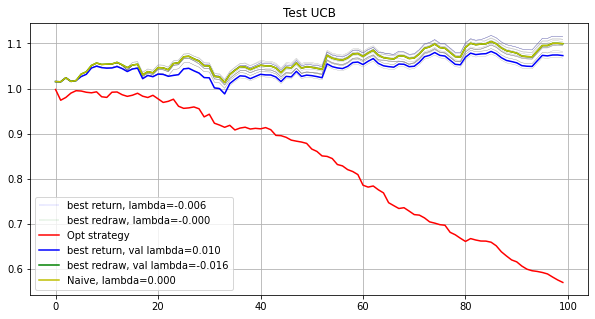

Phase 8
Validating...
./tmp2/res_phase08_iter8000_subn100_lb5.npz
Opt strategy
[0.     0.     0.0314 0.0119 0.01   0.0111 0.0074 0.     0.     0.
 0.008  0.     0.0275 0.0078 0.     0.0107 0.     0.     0.     0.
 0.     0.0544 0.     0.0226 0.0057 0.     0.0059 0.     0.011  0.0371
 0.     0.     0.     0.01   0.     0.     0.     0.     0.01   0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.0267 0.0379 0.     0.0708 0.0394 0.     0.     0.0049 0.     0.0245
 0.     0.     0.     0.     0.0155 0.0053 0.     0.     0.     0.
 0.     0.     0.     0.     0.1144 0.     0.     0.     0.0433 0.1285
 0.     0.0916 0.     0.     0.     0.     0.     0.     0.01   0.
 0.     0.0237 0.     0.     0.     0.     0.0481 0.01   0.01   0.0128]
[ 0.      0.      0.001   0.0119  0.01    0.      0.0079  0.      0.
  0.0037  0.0043  0.      0.0275  0.0009  0.      0.      0.      0.
  0.0009  0.0555  0.      0.0254  0.      0.024   0.0057  0.      0.0034
  0.0018  0.0089  0.016

[-0.     -0.      0.0136  0.0022  0.0003 -0.      0.     -0.     -0.
  0.     -0.      0.      0.0115  0.0084 -0.     -0.     -0.     -0.
  0.      0.0117  0.0018  0.      0.      0.0152  0.0434 -0.     -0.
 -0.      0.      0.0518 -0.     -0.     -0.      0.     -0.      0.
 -0.      0.      0.      0.     -0.      0.      0.      0.0329  0.
 -0.     -0.      0.     -0.     -0.      0.0893  0.     -0.      0.
  0.0206  0.      0.029  -0.     -0.      0.      0.     -0.      0.
  0.0071  0.     -0.      0.      0.      0.      0.      0.0766  0.
 -0.     -0.      0.1147  0.0831 -0.      0.0147  0.0858  0.0332 -0.
  0.     -0.     -0.     -0.     -0.      0.      0.      0.      0.
 -0.      0.     -0.      0.      0.0146  0.1335  0.1033  0.     -0.
  0.    ]
[-0.     -0.      0.0077 -0.      0.0003 -0.     -0.     -0.      0.0062
  0.     -0.      0.      0.0082 -0.     -0.     -0.     -0.     -0.
  0.0231  0.0091 -0.      0.      0.      0.0029  0.0409 -0.     -0.
 -0.      0.      0.

[ 0.      0.      0.0073  0.0048  0.0064  0.      0.0004  0.      0.
  0.      0.      0.      0.0182  0.      0.      0.      0.      0.
  0.001   0.0418  0.      0.0122  0.      0.0107  0.      0.      0.
  0.      0.      0.      0.0339  0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.056   0.      0.0048
  0.      0.0199  0.      0.      0.013   0.0461  0.      0.      0.
  0.0385  0.      0.      0.0341  0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.003   0.      0.1041  0.012
  0.      0.      0.      0.2486  0.      0.0964  0.0613  0.      0.
  0.      0.      0.      0.     -0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.1017 -0.      0.0207  0.      0.
  0.    ]
[ 0.      0.      0.0279  0.0076  0.0088  0.      0.0051  0.      0.
 -0.      0.024   0.0406  0.0205  0.0618  0.      0.      0.      0.
 -0.     -0.      0.      0.04    0.      0.0139  0.      0.      0.
 -0.      0.     

[ 0.     -0.      0.0056  0.0095  0.0075 -0.      0.0051 -0.     -0.
 -0.     -0.      0.0487  0.0229  0.018  -0.     -0.     -0.     -0.
  0.0108  0.0097 -0.     -0.      0.0126  0.0191  0.0234 -0.     -0.
 -0.      0.0286  0.0904  0.     -0.     -0.     -0.     -0.      0.1635
 -0.     -0.      0.0251 -0.     -0.      0.0038 -0.     -0.      0.0107
  0.0205  0.0333 -0.      0.      0.0229  0.0065  0.0382  0.0297  0.0054
  0.0451 -0.     -0.      0.     -0.      0.0102 -0.     -0.     -0.
 -0.      0.0129 -0.     -0.     -0.      0.0148 -0.      0.0382 -0.
 -0.     -0.      0.0172 -0.     -0.      0.0128  0.0211  0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.     -0.
 -0.      0.0171 -0.     -0.     -0.     -0.      0.0838  0.0382  0.0128
 -0.    ]
[ 0.     -0.      0.0104  0.0074  0.0073 -0.      0.     -0.      0.0062
  0.0557 -0.      0.0163  0.0157  0.0562 -0.     -0.     -0.     -0.
  0.0108  0.0566  0.0162 -0.      0.      0.0191  0.     -0.     -0.
 -0.

[-0.      0.0058 -0.      0.      0.0007 -0.     -0.      0.      0.
  0.      0.     -0.      0.0212  0.     -0.      0.      0.      0.
  0.0048  0.      0.      0.      0.      0.      0.     -0.     -0.
  0.     -0.      0.0726  0.032  -0.      0.      0.      0.      0.
  0.      0.0265  0.      0.      0.      0.      0.      0.      0.
  0.0102  0.      0.      0.      0.0121  0.      0.      0.0026  0.
  0.0117  0.     -0.     -0.      0.      0.0247  0.1605  0.      0.
  0.     -0.     -0.      0.     -0.     -0.      0.      0.1105  0.
  0.     -0.      0.0981  0.0273  0.      0.0157 -0.      0.0568  0.
  0.0076  0.      0.     -0.      0.      0.0557  0.      0.      0.0147
  0.      0.      0.      0.      0.0342  0.1877 -0.      0.      0.
  0.    ]
[-0.     -0.      0.0206 -0.      0.0007 -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.0171  0.0413 -0.     -0.     -0.      0.
 -0.     -0.     -0.      0.0264 -0.     -0.      0.025  -0.     -0.
 -0.     -0.      0.

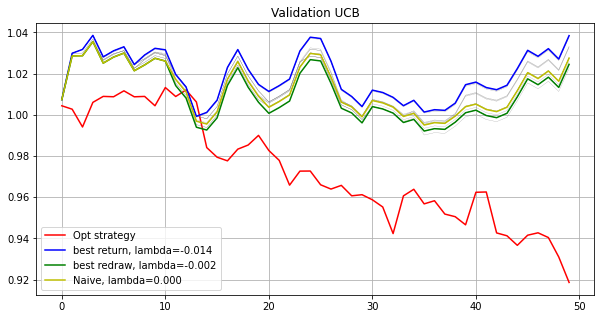

Testing...
./tmp2/res_phase08_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.04178553    Max redraw: 0.04154353
lambda: -0.018   Total log return: 0.04178553    Max redraw: 0.04154353
lambda: -0.016   Total log return: 0.04548496    Max redraw: 0.04154353
lambda: -0.014   Total log return: 0.04087616    Max redraw: 0.04154353
lambda: -0.012   Total log return: 0.03717725    Max redraw: 0.04154353
lambda: -0.010   Total log return: 0.04226571    Max redraw: 0.04154353
lambda: -0.008   Total log return: 0.04410808    Max redraw: 0.04154353
lambda: -0.006   Total log return: 0.04088311    Max redraw: 0.04154353
lambda: -0.004   Total log return: 0.04586607    Max redraw: 0.04154353
lambda: -0.002   Total log return: 0.04682497    Max redraw: 0.04154353
lambda: -0.000   Total log return: 0.04745435    Max redraw: 0.04154353
lambda: 0.002   Total log return: 0.04386840    Max redraw: 0.04154353
lambda: 0.004   Total log return: 0.05685098    Max redraw: 0.0415435

[ 0.      0.      0.007   0.0096  0.0093  0.      0.0059  0.      0.
  0.     -0.      0.      0.0254  0.0571  0.      0.0023  0.      0.
  0.0245  0.0051  0.      0.      0.      0.0134  0.0658  0.      0.
  0.      0.0152  0.0803  0.      0.      0.      0.0314  0.     -0.
 -0.      0.      0.0108  0.      0.     -0.      0.      0.0094 -0.
  0.      0.      0.0139  0.      0.0025  0.      0.      0.      0.
  0.0523  0.0091  0.      0.0376  0.      0.0358  0.      0.     -0.
  0.0005  0.0197  0.      0.      0.      0.0072  0.      0.      0.
  0.      0.0483  0.      0.      0.0004  0.0783  0.0011  0.      0.
  0.      0.      0.      0.      0.      0.0236  0.      0.007   0.0116
  0.078   0.      0.      0.0665  0.0165  0.0574  0.0091  0.0496 -0.
  0.    ]
[ 0.      0.      0.0145  0.0096  0.0093  0.      0.0057  0.      0.
  0.004   0.      0.      0.027   0.0545  0.      0.0077  0.      0.
  0.      0.      0.      0.      0.      0.0239  0.      0.      0.
  0.      0.0044  0.

[-0.     -0.      0.0011  0.0035  0.0056  0.005   0.     -0.     -0.
 -0.      0.0018 -0.      0.0166  0.      0.     -0.     -0.     -0.
  0.0272  0.0029  0.047  -0.     -0.     -0.      0.0883 -0.     -0.
 -0.      0.0184  0.0288 -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.0716 -0.     -0.     -0.     -0.     -0.     -0.      0.
  0.0069 -0.     -0.     -0.     -0.      0.     -0.      0.0132 -0.
  0.0315 -0.      0.      0.0172 -0.      0.0157 -0.     -0.      0.
 -0.     -0.     -0.     -0.      0.1465  0.0185 -0.     -0.      0.0053
 -0.     -0.      0.     -0.     -0.      0.0744 -0.     -0.     -0.
  0.0092 -0.      0.0956  0.     -0.      0.0242 -0.      0.0065  0.0414
 -0.      0.0163 -0.      0.0036 -0.      0.1532 -0.     -0.      0.
 -0.    ]
[-0.     -0.      0.0207  0.0042 -0.     -0.      0.     -0.     -0.
 -0.      0.      0.026   0.0045  0.      0.     -0.      0.0267 -0.
  0.034   0.0046  0.0112 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.    

[-0.     -0.      0.0347  0.0069  0.0082 -0.      0.004  -0.      0.0001
 -0.     -0.      0.0387  0.0298  0.0301 -0.     -0.     -0.     -0.
  0.0103  0.042  -0.     -0.     -0.      0.0121 -0.     -0.     -0.
 -0.      0.0157  0.0043 -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.025  -0.     -0.     -0.      0.0234 -0.     -0.     -0.
 -0.     -0.     -0.      0.0008 -0.     -0.      0.0071 -0.     -0.
  0.0378 -0.     -0.      0.0403 -0.      0.0359 -0.     -0.     -0.
  0.0035  0.005  -0.      0.042  -0.      0.0064 -0.     -0.      0.1034
 -0.      0.0113 -0.      0.0227 -0.      0.0007  0.1063  0.0091 -0.
 -0.     -0.      0.0884 -0.     -0.     -0.      0.      0.0118 -0.
 -0.      0.0291 -0.     -0.     -0.      0.0005  0.1124 -0.      0.
  0.0357]
[ 0.      0.0037  0.0205  0.0064  0.0084 -0.      0.004   0.      0.
  0.     -0.      0.0062  0.0262  0.019  -0.     -0.      0.     -0.
  0.      0.016   0.0067 -0.      0.      0.0135  0.0227  0.     -0.
 -0.      0.    

[ 0.      0.      0.011   0.0116  0.0077  0.      0.0053  0.      0.
  0.0089  0.0053  0.      0.      0.0168  0.0011  0.      0.      0.
 -0.      0.0301 -0.      0.0089  0.      0.0274  0.049   0.      0.
  0.      0.      0.0099  0.033   0.      0.      0.0107  0.      0.
  0.      0.      0.0005  0.048   0.     -0.     -0.     -0.      0.0012
 -0.      0.      0.0306 -0.     -0.      0.0777  0.0257 -0.     -0.
  0.0509  0.      0.0046  0.      0.      0.0474  0.      0.      0.
  0.0099 -0.     -0.      0.      0.      0.      0.      0.      0.
  0.      0.0375  0.0585 -0.      0.      0.0557 -0.     -0.      0.
  0.      0.      0.      0.      0.0168  0.059   0.      0.      0.
  0.      0.0708 -0.      0.      0.      0.0753  0.0027  0.      0.0051
  0.0797]
[ 0.      0.0217  0.      0.0052  0.0043  0.      0.      0.      0.
  0.      0.0053  0.      0.0055  0.     -0.     -0.      0.      0.
 -0.      0.0158 -0.      0.0318  0.     -0.      0.0462  0.      0.
  0.      0.    

[ 0.      0.      0.      0.0021  0.      0.      0.      0.      0.
  0.      0.      0.      0.0163  0.      0.      0.      0.      0.
  0.0177  0.0095  0.035   0.      0.      0.0163  0.0129  0.     -0.
  0.      0.      0.0254  0.      0.      0.      0.      0.      0.0126
  0.     -0.      0.      0.      0.      0.      0.      0.     -0.
  0.      0.      0.0375  0.      0.      0.      0.      0.      0.1033
  0.0167  0.048   0.0214  0.1215  0.      0.      0.023   0.      0.
  0.      0.      0.      0.      0.      0.0022  0.      0.0623  0.0473
  0.      0.0439  0.      0.      0.      0.0919 -0.      0.0688  0.
  0.      0.      0.      0.      0.      0.0381  0.      0.0332  0.
  0.      0.      0.      0.      0.0346  0.0282  0.0231  0.     -0.
  0.    ]
[ 0.0153  0.      0.      0.0057  0.0037  0.      0.      0.      0.027
  0.      0.      0.0176  0.0163  0.      0.      0.      0.0421  0.
 -0.      0.0103 -0.      0.0239  0.      0.0145 -0.      0.     -0.
  0.     

[-0.      0.0377 -0.     -0.      0.0023 -0.      0.0049 -0.     -0.
 -0.      0.0038 -0.      0.0144 -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.0268 -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.0751  0.1516 -0.      0.0312 -0.     -0.      0.0032
 -0.      0.031  -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0117  0.0163
  0.0482 -0.     -0.     -0.     -0.      0.0024 -0.     -0.     -0.
 -0.     -0.     -0.      0.0251 -0.      0.0189 -0.      0.1162  0.0738
 -0.     -0.     -0.      0.0545 -0.     -0.     -0.     -0.     -0.
  0.0587  0.0038 -0.     -0.      0.0092 -0.     -0.     -0.      0.0773
 -0.     -0.     -0.     -0.     -0.      0.0778 -0.      0.0155  0.
 -0.    ]
[-0.     -0.      0.0183  0.0084  0.0066 -0.      0.0032 -0.     -0.
 -0.      0.0038  0.0189  0.0222 -0.     -0.     -0.     -0.      0.0677
  0.     -0.     -0.      0.     -0.      0.0279 -0.     -0.     -0.
 -0.

[-0.     -0.      0.0282  0.0087  0.0042 -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.0175 -0.     -0.      0.0284 -0.      0.0124
 -0.     -0.      0.0068  0.0112 -0.      0.0133  0.0133 -0.     -0.
 -0.     -0.      0.0261 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.0953  0.0015  0.      0.0258
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.0284  0.1119 -0.      0.0143 -0.      0.022   0.0419 -0.     -0.
 -0.      0.0161  0.025  -0.     -0.     -0.     -0.      0.0232  0.0114
 -0.     -0.      0.007   0.0811 -0.     -0.      0.1137 -0.     -0.
  0.028  -0.      0.0329 -0.     -0.      0.0906 -0.      0.     -0.
  0.0156  0.034  -0.     -0.     -0.     -0.      0.     -0.     -0.
 -0.    ]
[-0.     -0.      0.0148 -0.     -0.      0.0033 -0.     -0.     -0.
 -0.     -0.     -0.      0.0045 -0.     -0.      0.0333 -0.      0.
 -0.     -0.      0.      0.002  -0.      0.      0.     -0.     -0.
 -0.     -0.

[-0.     -0.      0.0001  0.0025 -0.     -0.      0.     -0.     -0.
  0.     -0.     -0.      0.0133 -0.      0.     -0.      0.      0.025
  0.0218  0.0227 -0.      0.0113  0.     -0.      0.0756  0.      0.
 -0.      0.0158  0.0513  0.0156  0.      0.     -0.      0.     -0.
 -0.     -0.      0.003  -0.      0.     -0.     -0.     -0.      0.
  0.      0.0119 -0.      0.      0.     -0.      0.0154 -0.     -0.
  0.0036 -0.      0.0299 -0.      0.     -0.      0.0001 -0.     -0.
  0.0088 -0.      0.0058 -0.     -0.     -0.     -0.      0.0151  0.
 -0.      0.0706 -0.     -0.     -0.      0.0435 -0.      0.2173 -0.
 -0.     -0.     -0.      0.     -0.      0.0789  0.      0.0183 -0.
  0.     -0.     -0.     -0.      0.0732  0.0273  0.1108  0.      0.
 -0.    ]
[-0.      0.      0.0102  0.0063  0.0031  0.0448  0.      0.      0.
  0.0278  0.      0.      0.0207  0.      0.      0.      0.      0.
  0.      0.      0.0071  0.0231  0.      0.0204  0.      0.      0.
  0.      0.      0.0

[ 0.      0.      0.0389  0.0018  0.0002  0.      0.      0.      0.0111
  0.      0.      0.0098  0.0132  0.0541  0.      0.      0.0241  0.0091
  0.      0.      0.      0.004   0.      0.0064 -0.      0.      0.
  0.      0.      0.0716  0.0273  0.      0.      0.      0.      0.0201
  0.      0.0028  0.      0.      0.0404  0.0266  0.      0.0006 -0.
  0.     -0.      0.      0.0076  0.      0.0262  0.      0.      0.
  0.003   0.      0.      0.0002  0.      0.      0.      0.      0.
 -0.      0.      0.      0.      0.0036  0.      0.019   0.0239  0.0286
  0.      0.      0.      0.0883  0.     -0.      0.      0.2011  0.
  0.088   0.0295  0.      0.      0.      0.      0.      0.     -0.
  0.      0.      0.      0.      0.     -0.      0.0885  0.0171  0.
  0.    ]
[ 0.      0.0181  0.0111  0.0078  0.0061  0.0065  0.      0.     -0.
  0.      0.     -0.      0.0126  0.0173  0.      0.     -0.     -0.
  0.0052  0.0428  0.      0.0017  0.      0.      0.0993  0.      0.
  0.    

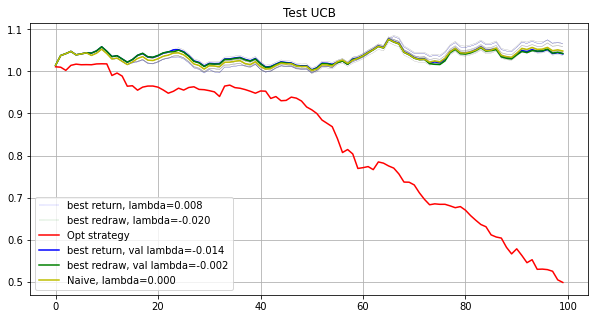

Phase 9
Validating...
./tmp2/res_phase09_iter8000_subn100_lb5.npz
Opt strategy
[0.     0.     0.     0.     0.     0.     0.     0.     0.0215 0.
 0.     0.0094 0.     0.     0.01   0.0186 0.0142 0.     0.1076 0.
 0.     0.     0.     0.     0.01   0.     0.0144 0.     0.     0.
 0.0005 0.0094 0.     0.0003 0.1014 0.     0.     0.     0.     0.
 0.0316 0.0752 0.     0.     0.0327 0.0174 0.0692 0.     0.     0.
 0.     0.0292 0.0014 0.     0.     0.     0.     0.     0.0299 0.
 0.     0.     0.01   0.     0.     0.     0.0266 0.     0.     0.
 0.     0.     0.1787 0.     0.     0.0391 0.     0.     0.     0.0144
 0.0358 0.0472 0.0012 0.     0.0124 0.     0.     0.0173 0.     0.0133
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[-0.      0.0246  0.0041 -0.     -0.      0.0138  0.0443 -0.      0.0215
 -0.      0.0014 -0.     -0.     -0.     -0.      0.0768 -0.     -0.
 -0.     -0.      0.0032 -0.     -0.     -0.      0.0254  0.003   0.0361
 -0.     -0.      0.015

[ 0.     -0.      0.      0.      0.      0.      0.0311  0.      0.
  0.      0.      0.0009  0.      0.      0.      0.1377  0.      0.
  0.      0.      0.0513  0.0117  0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.2792  0.
  0.      0.      0.      0.      0.0786  0.      0.      0.0249  0.
  0.      0.0102  0.      0.      0.      0.1029  0.     -0.      0.
  0.      0.      0.      0.      0.      0.      0.0124  0.      0.
  0.      0.      0.0257  0.0397  0.      0.      0.      0.      0.
  0.      0.      0.      0.     -0.      0.      0.0333  0.      0.
  0.0302  0.0888  0.      0.      0.      0.      0.      0.      0.
  0.      0.     -0.      0.      0.      0.0399  0.      0.      0.
 -0.    ]
[ 0.      0.0378  0.      0.      0.      0.      0.      0.08    0.0035
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.0507  0.      0.      0.      0.      0.      0.0847  0.      0.0084
  0.      0.    

[-0.      0.0019 -0.      0.     -0.     -0.     -0.     -0.      0.007
 -0.     -0.      0.0162 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.0176  0.0054 -0.     -0.      0.0226  0.0001 -0.
 -0.     -0.     -0.     -0.      0.0038  0.0421 -0.      0.1172 -0.
 -0.     -0.     -0.     -0.      0.1368  0.061  -0.      0.0237 -0.
 -0.      0.0019 -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.0556 -0.     -0.
 -0.     -0.      0.0582  0.0064 -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.0917  0.0049 -0.      0.0344 -0.     -0.      0.1287 -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.0214  0.1352 -0.      0.0033
 -0.    ]
[-0.     -0.     -0.      0.     -0.      0.0049 -0.     -0.      0.0126
 -0.     -0.      0.0162 -0.     -0.      0.0212  0.     -0.     -0.
  0.0002  0.     -0.      0.0266  0.      0.      0.0528 -0.      0.
  0.     -0. 

[ 0.      0.0358  0.      0.0037  0.      0.0118 -0.      0.      0.0188
  0.      0.     -0.      0.0028  0.      0.     -0.      0.      0.
  0.0691  0.0023  0.      0.      0.      0.      0.0251  0.0413  0.
  0.0009  0.      0.     -0.     -0.     -0.      0.      0.0298  0.
 -0.     -0.      0.031  -0.     -0.      0.0422  0.      0.      0.
  0.      0.0701  0.     -0.     -0.      0.      0.0357  0.      0.
  0.0105  0.     -0.     -0.      0.031  -0.     -0.      0.      0.
  0.      0.0206  0.      0.      0.      0.008   0.0595  0.      0.
  0.     -0.      0.      0.0156  0.0004  0.      0.0092  0.0606  0.
 -0.      0.0509  0.      0.0631  0.     -0.      0.0053 -0.      0.0163
  0.      0.      0.0676  0.      0.      0.     -0.     -0.      0.0868
  0.0698]
[-0.     -0.     -0.     -0.     -0.     -0.      0.0309 -0.      0.0168
 -0.     -0.      0.0117 -0.     -0.      0.0322  0.0023 -0.     -0.
  0.0222 -0.     -0.     -0.     -0.     -0.      0.0352  0.0533  0.0224
 -0.

[0.     0.0331 0.     0.     0.     0.0081 0.     0.0189 0.0184 0.
 0.     0.     0.     0.     0.     0.0886 0.     0.     0.     0.
 0.     0.     0.     0.     0.0191 0.     0.0285 0.     0.     0.
 0.     0.     0.0143 0.     0.0191 0.     0.     0.0047 0.041  0.
 0.     0.0087 0.     0.     0.     0.021  0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.0381 0.0649 0.     0.03   0.
 0.     0.     0.     0.     0.     0.0439 0.0075 0.     0.0783 0.
 0.     0.1819 0.0548 0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.0091 0.     0.     0.     0.0045 0.0549 0.1025 0.    ]
[0.     0.0331 0.     0.     0.     0.     0.     0.     0.0028 0.
 0.     0.     0.     0.     0.0026 0.083  0.     0.     0.     0.
 0.0786 0.     0.     0.     0.0734 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.0303 0.     0.     0.     0.     0.     0.     

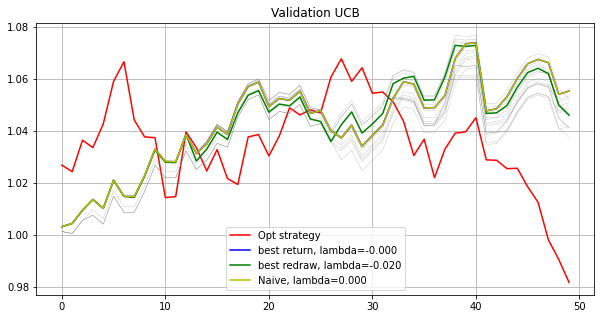

Testing...
./tmp2/res_phase09_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.09169513    Max redraw: 0.03340976
lambda: -0.018   Total log return: 0.09705971    Max redraw: 0.03340976
lambda: -0.016   Total log return: 0.08685545    Max redraw: 0.03340976
lambda: -0.014   Total log return: 0.09649924    Max redraw: 0.03340976
lambda: -0.012   Total log return: 0.09522997    Max redraw: 0.03340976
lambda: -0.010   Total log return: 0.10101991    Max redraw: 0.03267943
lambda: -0.008   Total log return: 0.10152567    Max redraw: 0.03267943
lambda: -0.006   Total log return: 0.10408528    Max redraw: 0.03267943
lambda: -0.004   Total log return: 0.10237535    Max redraw: 0.03267943
lambda: -0.002   Total log return: 0.10357638    Max redraw: 0.03267943
lambda: -0.000   Total log return: 0.10357638    Max redraw: 0.03267943
lambda: 0.002   Total log return: 0.10785830    Max redraw: 0.03267943
lambda: 0.004   Total log return: 0.10442110    Max redraw: 0.0326794

[-0.      0.013  -0.      0.0003 -0.      0.0034 -0.     -0.      0.0279
 -0.     -0.      0.     -0.     -0.      0.0039  0.0281 -0.     -0.
  0.0064 -0.     -0.     -0.     -0.      0.0078  0.0264 -0.     -0.
 -0.     -0.     -0.     -0.      0.0142  0.0189 -0.      0.0871 -0.
  0.     -0.      0.0239  0.0152  0.0289  0.0048  0.     -0.      0.
  0.0195  0.0168 -0.     -0.      0.      0.0162 -0.     -0.      0.
 -0.      0.      0.0046 -0.     -0.     -0.      0.0855  0.     -0.
  0.0003 -0.      0.     -0.      0.0382 -0.      0.0522 -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.      0.      0.0106 -0.
  0.1435  0.0076  0.      0.0726  0.      0.0357 -0.      0.0748 -0.
  0.0203  0.0091  0.0043  0.     -0.      0.      0.      0.0365  0.0401
  0.    ]
[-0.      0.0252 -0.     -0.     -0.     -0.      0.024  -0.      0.0292
 -0.     -0.     -0.     -0.     -0.     -0.      0.0718 -0.     -0.
  0.0102 -0.     -0.     -0.     -0.     -0.      0.0809  0.0254  0.0021
 -0.    

[-0.      0.0267 -0.     -0.     -0.     -0.     -0.      0.0375  0.0153
 -0.      0.     -0.     -0.     -0.      0.0196  0.     -0.     -0.
  0.     -0.      0.0286  0.     -0.     -0.      0.0439 -0.      0.0104
 -0.     -0.     -0.      0.     -0.      0.0153 -0.      0.     -0.
 -0.     -0.     -0.     -0.      0.1036  0.0661 -0.     -0.     -0.
  0.0062  0.0261 -0.      0.1083 -0.     -0.     -0.     -0.      0.
 -0.     -0.      0.0374 -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.054   0.      0.0966 -0.     -0.      0.1157 -0.     -0.
 -0.     -0.      0.0261 -0.     -0.     -0.     -0.     -0.      0.
 -0.     -0.     -0.      0.     -0.     -0.      0.0939  0.0236 -0.
  0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.
  0.0423]
[-0.      0.     -0.     -0.     -0.     -0.     -0.      0.      0.0216
 -0.      0.0229 -0.     -0.     -0.      0.      0.     -0.     -0.
  0.     -0.      0.      0.     -0.     -0.      0.1214  0.1554  0.
 -0.     -0.

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0014
 -0.     -0.     -0.     -0.     -0.     -0.      0.0339  0.0027 -0.
 -0.     -0.      0.0274 -0.     -0.     -0.      0.0233 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.048  -0.
 -0.     -0.     -0.     -0.     -0.      0.0692 -0.      0.0072 -0.
  0.0158  0.0755 -0.     -0.     -0.     -0.     -0.     -0.      0.1307
 -0.     -0.      0.0554 -0.      0.0337 -0.     -0.     -0.     -0.
 -0.     -0.      0.0995 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.0022 -0.     -0.     -0.      0.0337
  0.1092  0.0234 -0.      0.0246 -0.     -0.      0.1102 -0.     -0.
 -0.     -0.      0.0621 -0.     -0.     -0.      0.0005 -0.      0.0063
 -0.    ]
[ 0.      0.0188  0.0022  0.      0.      0.0098  0.0028  0.0055  0.0227
  0.      0.0168  0.      0.     -0.      0.      0.      0.0033  0.
 -0.     -0.      0.     -0.     -0.     -0.      0.0074  0.0111 -0.
 -0.

[ 0.      0.0325  0.      0.      0.      0.      0.     -0.      0.024
  0.      0.      0.      0.      0.      0.      0.     -0.      0.
  0.     -0.     -0.      0.      0.      0.      0.0561  0.0429  0.
  0.036   0.      0.      0.     -0.      0.      0.      0.0237  0.
  0.0153  0.      0.0199  0.0005  0.      0.006  -0.      0.      0.
  0.0057 -0.      0.      0.0126  0.      0.      0.     -0.     -0.
  0.      0.      0.     -0.      0.     -0.      0.0389  0.      0.
  0.      0.1024  0.      0.1146  0.0756  0.      0.     -0.      0.
 -0.      0.0365 -0.      0.0296  0.      0.      0.      0.      0.0006
  0.13    0.0486  0.      0.0586  0.      0.      0.0083  0.      0.
 -0.      0.      0.0467 -0.      0.      0.      0.      0.      0.0285
 -0.    ]
[-0.      0.     -0.     -0.     -0.      0.      0.0593 -0.      0.0173
  0.     -0.     -0.     -0.     -0.      0.      0.0154 -0.      0.
 -0.     -0.      0.0241 -0.     -0.     -0.      0.0249 -0.      0.0592
  0.0

[-0.     -0.     -0.     -0.     -0.     -0.      0.0017 -0.      0.0117
 -0.     -0.     -0.     -0.     -0.      0.      0.     -0.     -0.
 -0.     -0.      0.0702 -0.     -0.     -0.      0.0418  0.0099  0.
  0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0659 -0.
 -0.      0.      0.     -0.      0.0591  0.0202 -0.     -0.     -0.
 -0.      0.0161 -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.0783 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.0549 -0.      0.      0.     -0.      0.     -0.
  0.     -0.      0.      0.0033 -0.     -0.     -0.     -0.      0.0869
  0.108   0.0113  0.      0.1035  0.     -0.      0.0818  0.0183 -0.
 -0.     -0.      0.0036 -0.     -0.      0.      0.1301  0.      0.0163
  0.    ]
[-0.      0.0344 -0.      0.011  -0.     -0.      0.041  -0.      0.0117
 -0.     -0.     -0.     -0.     -0.     -0.      0.0334 -0.     -0.
 -0.     -0.      0.0672 -0.     -0.     -0.      0.0472 -0.     -0.
 -0.    

[ 0.      0.      0.      0.0059  0.      0.      0.      0.      0.0204
  0.      0.0227  0.      0.      0.      0.      0.0378  0.      0.
  0.      0.      0.0261  0.      0.      0.      0.0308  0.0724  0.0895
  0.      0.      0.      0.      0.      0.0409  0.0047  0.      0.
  0.      0.      0.      0.      0.      0.041   0.      0.0177  0.
  0.0249  0.0479  0.      0.0114  0.      0.      0.0002  0.      0.
  0.      0.      0.      0.      0.      0.      0.0002  0.      0.
  0.0191  0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.0103 -0.      0.      0.      0.
  0.0373  0.0132  0.      0.0394  0.      0.      0.      0.0132  0.009
  0.0356  0.      0.1087  0.0147  0.      0.      0.0373  0.0197  0.0563
  0.0829]
[-0.     -0.     -0.      0.0013 -0.     -0.     -0.      0.0186  0.0081
 -0.     -0.      0.0039 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.0835  0.0208 -0.
 -0. 

[ 0.      0.     -0.      0.074  -0.      0.0016  0.0453  0.0164  0.0304
  0.      0.0323  0.      0.      0.      0.      0.0486  0.0015  0.
 -0.     -0.      0.0639 -0.      0.      0.      0.0268  0.      0.0613
  0.0139  0.      0.      0.      0.     -0.      0.      0.0041  0.
 -0.      0.      0.0299  0.     -0.      0.0146  0.      0.      0.
  0.0419 -0.      0.      0.      0.      0.      0.      0.     -0.
  0.0046  0.      0.0224 -0.      0.      0.      0.0241  0.      0.
  0.      0.      0.     -0.      0.0225  0.004   0.      0.      0.
 -0.      0.      0.      0.0511  0.0172  0.      0.0289 -0.      0.1515
  0.      0.0208  0.      0.      0.      0.      0.0003  0.0116 -0.
  0.      0.      0.0717  0.     -0.      0.      0.0378  0.      0.0149
  0.    ]
[ 0.      0.0325  0.      0.      0.      0.0016  0.0166  0.      0.0219
  0.      0.      0.      0.0133  0.      0.      0.0349  0.      0.
 -0.      0.      0.0732 -0.      0.      0.      0.0621  0.      0.0209


[-0.      0.01   -0.      0.     -0.      0.0082  0.      0.      0.0165
  0.      0.      0.0284  0.      0.     -0.      0.      0.0072 -0.
  0.0288  0.0021 -0.      0.      0.     -0.      0.0711  0.      0.
  0.0039 -0.      0.      0.     -0.      0.0212 -0.      0.0431 -0.
 -0.      0.      0.      0.      0.      0.1018  0.      0.      0.
  0.0316  0.      0.      0.0002 -0.      0.      0.      0.0011  0.
  0.     -0.     -0.      0.      0.      0.      0.0247  0.     -0.
 -0.     -0.     -0.      0.      0.      0.     -0.     -0.      0.
  0.      0.     -0.      0.      0.      0.      0.0243  0.      0.021
  0.0999  0.0048 -0.      0.0452 -0.      0.      0.0108  0.0643 -0.
 -0.      0.0715  0.0212  0.      0.0142  0.0774  0.      0.      0.0488
  0.0853]
[-0.      0.0007 -0.      0.0048 -0.     -0.     -0.     -0.      0.0306
 -0.     -0.     -0.     -0.     -0.     -0.      0.0249  0.01   -0.
 -0.      0.0021  0.0203 -0.     -0.     -0.      0.0461 -0.     -0.
 -0.     

[0.     0.0254 0.0036 0.     0.     0.     0.     0.0046 0.0338 0.
 0.     0.     0.     0.     0.0036 0.0162 0.0221 0.     0.0114 0.
 0.0173 0.     0.     0.     0.0694 0.     0.     0.     0.0026 0.0087
 0.     0.     0.     0.     0.0677 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.0338 0.     0.     0.     0.
 0.     0.0499 0.0113 0.     0.     0.     0.0726 0.     0.0554 0.
 0.     0.     0.     0.0427 0.0253 0.     0.     0.0472 0.0207 0.
 0.     0.     0.0017 0.     0.     0.0167 0.0244 0.     0.0219 0.
 0.     0.0545 0.0618 0.     0.0012 0.     0.0231 0.     0.0311 0.0723
 0.0122 0.     0.0096 0.     0.0112 0.     0.     0.     0.     0.    ]
[-0.     -0.     -0.      0.      0.      0.      0.0648  0.0055  0.0268
  0.      0.0412  0.      0.      0.     -0.      0.0162  0.0189  0.
 -0.      0.     -0.      0.      0.      0.      0.0817  0.      0.0125
  0.0504 -0.     -0.      0.      0.     -0.      0.      0.003   0.
  0.0353  0.      0.      0.     

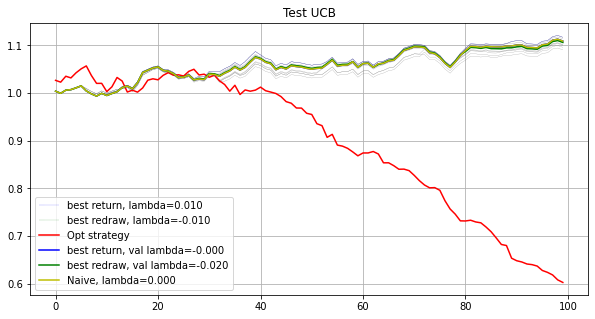

Phase 10
Validating...
./tmp2/res_phase10_iter8000_subn100_lb5.npz
Opt strategy
[0.     0.     0.0259 0.     0.     0.     0.     0.     0.     0.0009
 0.0024 0.     0.     0.     0.     0.0245 0.     0.01   0.     0.
 0.0459 0.     0.     0.0123 0.0074 0.0457 0.0188 0.0047 0.     0.01
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.061  0.     0.     0.
 0.     0.1455 0.     0.0113 0.01   0.0081 0.     0.003  0.0198 0.
 0.0152 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.0754 0.0563 0.     0.0395 0.     0.116  0.
 0.     0.0125 0.0489 0.     0.     0.     0.     0.     0.     0.0022
 0.0959 0.     0.     0.     0.     0.0644 0.     0.     0.0061 0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0009
 0.0024 0.0055 0.0097 0.0027 0.     0.0245 0.0205 0.01   0.     0.
 0.     0.     0.     0.0123 0.     0.     0.     0.0092 0.     0.0106
 0.     0.     0.     0.  

[ 0.      0.0044  0.0212  0.      0.      0.      0.      0.      0.
  0.0009  0.      0.      0.0118  0.0742  0.      0.0008  0.0074  0.0083
  0.0084  0.      0.0933  0.      0.      0.0001  0.      0.0807  0.0037
  0.0113  0.      0.0223  0.      0.018  -0.      0.      0.     -0.
  0.      0.      0.0114  0.      0.      0.0042  0.      0.0021  0.
  0.      0.0081  0.     -0.      0.0694  0.      0.0336  0.      0.
  0.      0.0168 -0.      0.0262  0.     -0.      0.      0.1407  0.
  0.      0.      0.      0.      0.      0.      0.      0.0077  0.
  0.      0.0315  0.      0.      0.1129  0.0063  0.      0.1233  0.
  0.      0.0001  0.0322  0.      0.      0.      0.      0.      0.
  0.      0.0048  0.      0.      0.      0.      0.      0.      0.
  0.    ]
[ 0.      0.      0.004   0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.0213  0.      0.      0.0165  0.      0.
  0.      0.      0.      0.0336  0.      0.0044  0.      0.0623  0.
  0.      0.    

[-0.     -0.      0.0107 -0.      0.     -0.      0.007  -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.0585  0.0442 -0.     -0.
 -0.     -0.      0.0622  0.0262 -0.      0.0062 -0.      0.008  -0.
  0.0017 -0.      0.0175 -0.      0.0396 -0.     -0.     -0.      0.0726
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0491
 -0.     -0.     -0.      0.076   0.0078 -0.      0.0844 -0.     -0.
 -0.      0.0384 -0.     -0.      0.0539 -0.      0.0626 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.0267 -0.     -0.      0.0305  0.0267 -0.      0.1125 -0.
 -0.     -0.      0.0361  0.     -0.     -0.      0.0022 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0289 -0.
  0.0063]
[ 0.     -0.      0.0344  0.0062  0.     -0.      0.     -0.     -0.
 -0.     -0.      0.      0.0072  0.      0.0615  0.0462 -0.      0.0067
 -0.     -0.      0.0774  0.041  -0.      0.0162 -0.      0.0126 -0.
 -0.     -0.

[ 0.      0.0018  0.0278  0.      0.0788  0.      0.      0.     -0.
 -0.     -0.      0.      0.0075  0.0575  0.      0.     -0.      0.0018
  0.      0.      0.0372  0.0082 -0.      0.0206  0.      0.0271  0.0157
  0.0009  0.      0.0116  0.      0.      0.0454  0.      0.      0.0378
 -0.     -0.      0.      0.0478 -0.     -0.     -0.      0.     -0.
 -0.      0.      0.0931 -0.      0.      0.      0.026  -0.     -0.
  0.      0.0283  0.0059  0.      0.0265  0.      0.      0.     -0.
  0.     -0.     -0.     -0.      0.0149  0.049   0.      0.     -0.
 -0.      0.1466  0.0341 -0.     -0.      0.     -0.      0.     -0.
  0.      0.      0.     -0.      0.0217 -0.      0.     -0.      0.0733
  0.      0.      0.0046 -0.     -0.      0.      0.      0.      0.0437
 -0.    ]
[-0.     -0.     -0.     -0.     -0.      0.0098  0.0037 -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.0526  0.0076 -0.      0.
 -0.     -0.      0.0241 -0.     -0.      0.     -0.      0.0378 -0.
 -0.

[-0.      0.0005  0.0101 -0.     -0.     -0.     -0.     -0.     -0.
  0.      0.006  -0.      0.001  -0.     -0.      0.0122 -0.      0.0052
 -0.     -0.     -0.     -0.     -0.      0.0015 -0.      0.0636  0.0203
 -0.     -0.      0.0161 -0.     -0.      0.0054 -0.     -0.      0.0445
  0.     -0.      0.0207  0.0383 -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.0539  0.0442 -0.     -0.     -0.     -0.
  0.     -0.     -0.      0.0213 -0.      0.1217  0.      0.0092 -0.
  0.0051  0.0371 -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.0567  0.     -0.      0.0344  0.0133 -0.     -0.      0.
  0.      0.0104  0.0045  0.     -0.      0.0838 -0.     -0.      0.0888
 -0.     -0.     -0.     -0.      0.0451 -0.      0.1067 -0.      0.0118
 -0.    ]
[ 0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.0015  0.      0.      0.      0.      0.0019  0.      0.
  0.      0.      0.      0.033   0.      0.      0.      0.0995  0.
  0.

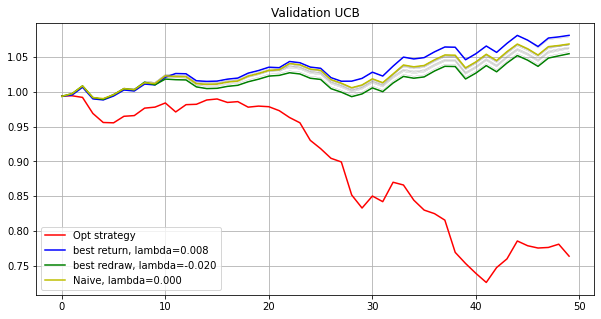

Testing...
./tmp2/res_phase10_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.08116028    Max redraw: 0.04229200
lambda: -0.018   Total log return: 0.08348685    Max redraw: 0.04229200
lambda: -0.016   Total log return: 0.06238050    Max redraw: 0.04229200
lambda: -0.014   Total log return: 0.06048604    Max redraw: 0.04229200
lambda: -0.012   Total log return: 0.06024048    Max redraw: 0.04229200
lambda: -0.010   Total log return: 0.05893089    Max redraw: 0.04229200
lambda: -0.008   Total log return: 0.07108065    Max redraw: 0.04229200
lambda: -0.006   Total log return: 0.07304868    Max redraw: 0.04229200
lambda: -0.004   Total log return: 0.07828324    Max redraw: 0.04229200
lambda: -0.002   Total log return: 0.08972199    Max redraw: 0.04229200
lambda: -0.000   Total log return: 0.09715899    Max redraw: 0.04229200
lambda: 0.002   Total log return: 0.09687345    Max redraw: 0.04229200
lambda: 0.004   Total log return: 0.10057098    Max redraw: 0.0422920

[ 0.     -0.      0.      0.     -0.      0.      0.      0.      0.
  0.      0.0021 -0.      0.0097  0.     -0.      0.0217  0.     -0.
  0.      0.      0.1903  0.0343 -0.      0.0069  0.      0.0314 -0.
 -0.     -0.      0.0173  0.     -0.      0.0987 -0.      0.0015  0.0392
 -0.      0.      0.      0.      0.      0.      0.      0.     -0.
  0.0087 -0.      0.      0.      0.0198  0.      0.1461  0.      0.0333
  0.      0.     -0.      0.0139  0.      0.0856  0.      0.016   0.
  0.     -0.      0.      0.      0.     -0.     -0.      0.0106  0.
 -0.      0.0755  0.0302 -0.      0.      0.      0.      0.      0.
  0.      0.0376  0.      0.     -0.      0.0179 -0.      0.      0.0502
 -0.      0.     -0.      0.      0.      0.      0.      0.     -0.
  0.    ]
[-0.      0.0009  0.0336 -0.      0.0043 -0.     -0.     -0.     -0.
  0.0003 -0.     -0.      0.006   0.0261 -0.      0.0217  0.      0.008
  0.0069 -0.      0.0551  0.0343 -0.     -0.     -0.     -0.     -0.
 -0.     

[-0.     -0.      0.009  -0.     -0.     -0.     -0.      0.0001 -0.
  0.003   0.0003 -0.      0.043  -0.     -0.      0.0746 -0.      0.0108
 -0.     -0.      0.0833  0.0424 -0.      0.0105 -0.      0.0161 -0.
 -0.     -0.      0.0054 -0.     -0.      0.0031 -0.      0.0059 -0.
 -0.      0.0113  0.0101 -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.096  -0.     -0.     -0.     -0.      0.078  -0.     -0.
 -0.      0.1467 -0.      0.0093 -0.     -0.     -0.      0.063  -0.
  0.0533 -0.     -0.     -0.     -0.     -0.     -0.      0.0219 -0.
 -0.      0.0956 -0.     -0.     -0.     -0.      0.     -0.      0.0335
 -0.      0.0116  0.0054 -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.0087 -0.      0.0108 -0.     -0.     -0.     -0.     -0.
  0.0347]
[-0.      0.0048  0.0357 -0.      0.0029 -0.      0.0084  0.     -0.
  0.      0.      0.0126  0.011  -0.      0.0187  0.0085 -0.      0.
 -0.     -0.      0.0412  0.      0.0282  0.0016 -0.      0.0025  0.0235
  0.0064 -0.

[-0.     -0.      0.01   -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.0303 -0.     -0.
 -0.     -0.      0.0354  0.0687  0.0175 -0.     -0.     -0.     -0.
  0.0112 -0.      0.0214 -0.     -0.      0.     -0.     -0.     -0.
 -0.      0.0692 -0.     -0.     -0.     -0.     -0.      0.0023  0.0035
 -0.     -0.      0.0773 -0.     -0.     -0.      0.077  -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0612 -0.
  0.0257 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.2844
 -0.      0.0028 -0.     -0.     -0.      0.0062 -0.     -0.      0.1846
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.0074 -0.      0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.     -0.      0.0091 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.0239  0.0327 -0.     -0.      0.0233 -0.     -0.
 -0.     -0.      0.      0.0122  0.     -0.     -0.      0.0702 -0.
  0.     -0.

[0.     0.     0.     0.     0.0193 0.     0.     0.     0.     0.
 0.     0.     0.006  0.     0.     0.0036 0.     0.     0.     0.
 0.0608 0.     0.     0.     0.     0.094  0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.0875 0.     0.178  0.
 0.     0.0601 0.     0.     0.     0.     0.     0.     0.     0.
 0.0212 0.     0.     0.     0.     0.     0.     0.     0.     0.0047
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.0804 0.     0.     0.     0.     0.     0.     0.     0.0003
 0.     0.     0.3    0.     0.     0.     0.     0.0781 0.     0.    ]
[0.     0.     0.     0.     0.0532 0.     0.     0.     0.     0.
 0.     0.     0.     0.0145 0.     0.     0.     0.     0.     0.
 0.1986 0.0356 0.     0.     0.     0.0008 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.093
 0.     0.     0.     0.     0.     0.     0. 

[ 0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.0469  0.      0.0003  0.      0.      0.0503  0.
  0.      0.      0.      0.      0.      0.      0.      0.0376  0.
  0.      0.      0.0166  0.      0.      0.      0.      0.0123  0.
  0.      0.      0.      0.0158  0.      0.0179  0.      0.      0.
  0.      0.062   0.0816  0.      0.0589  0.      0.      0.      0.0074
  0.      0.0536  0.      0.0429  0.      0.0142  0.      0.0264  0.
  0.      0.0065  0.      0.      0.      0.      0.      0.0071  0.2437
 -0.     -0.      0.0397  0.0023  0.      0.      0.      0.      0.
  0.0489  0.      0.      0.     -0.      0.      0.      0.      0.
  0.0789  0.      0.0206  0.      0.      0.      0.      0.      0.
  0.    ]
[-0.     -0.      0.008  -0.     -0.     -0.      0.0206 -0.     -0.
 -0.     -0.     -0.     -0.      0.      0.011   0.     -0.     -0.
 -0.     -0.      0.0639 -0.      0.002   0.0037 -0.      0.0887 -0.
 -0.     -0.    

[-0.     -0.     -0.     -0.      0.0734 -0.      0.0002 -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.0427  0.0342  0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.0061 -0.      0.0864 -0.
 -0.     -0.     -0.     -0.     -0.      0.0575 -0.      0.     -0.
 -0.      0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.0059 -0.     -0.     -0.     -0.      0.011  -0.     -0.
 -0.     -0.      0.0481 -0.     -0.      0.0604  0.      0.0123 -0.
 -0.      0.     -0.     -0.      0.0492 -0.      0.1124  0.0005  0.
 -0.      0.1227 -0.     -0.      0.      0.0174  0.     -0.      0.
  0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0309
  0.2049 -0.     -0.     -0.     -0.      0.0082 -0.      0.0068 -0.
 -0.    ]
[-0.     -0.     -0.     -0.      0.     -0.      0.     -0.     -0.
 -0.     -0.     -0.      0.0168 -0.      0.0251  0.0017  0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.     -0.
 -0.     -0.      0.

[ 0.0085  0.      0.0302  0.      0.      0.      0.0012  0.      0.
  0.     -0.      0.002  -0.     -0.      0.      0.0728 -0.      0.
 -0.      0.      0.0615  0.0213  0.      0.      0.      0.006  -0.
 -0.      0.     -0.      0.     -0.      0.     -0.      0.0088  0.
  0.      0.     -0.     -0.      0.      0.      0.0073  0.     -0.
 -0.      0.1041  0.034   0.0389 -0.      0.      0.0312  0.      0.
  0.0375  0.0223  0.1403  0.0594  0.     -0.      0.      0.0223  0.
 -0.      0.0025  0.      0.      0.      0.047   0.      0.      0.
  0.      0.1157  0.036  -0.     -0.      0.      0.      0.      0.
  0.0024 -0.     -0.     -0.     -0.      0.      0.      0.      0.
  0.0083  0.0027  0.0154  0.      0.      0.      0.      0.      0.0499
  0.    ]
[ 0.      0.      0.      0.      0.      0.0065  0.      0.      0.
  0.      0.      0.0356  0.      0.0632  0.0714  0.0349 -0.      0.
  0.0061  0.      0.03   -0.      0.      0.009   0.     -0.     -0.
  0.0031  0.      0.

[ 0.      0.      0.0055 -0.      0.     -0.      0.0184 -0.     -0.
 -0.      0.0208 -0.      0.0747  0.      0.      0.0208 -0.     -0.
  0.     -0.      0.     -0.      0.     -0.     -0.      0.0794  0.
  0.     -0.      0.     -0.      0.      0.0312  0.     -0.      0.
  0.      0.0124 -0.     -0.      0.      0.      0.     -0.     -0.
  0.      0.0467  0.      0.      0.     -0.      0.     -0.     -0.
 -0.      0.0225 -0.      0.0264  0.011  -0.     -0.      0.173   0.
  0.     -0.     -0.      0.     -0.     -0.      0.1969  0.      0.
  0.      0.1173 -0.      0.      0.     -0.     -0.     -0.      0.
 -0.     -0.     -0.     -0.      0.      0.     -0.     -0.      0.0291
 -0.     -0.      0.0283  0.     -0.      0.      0.      0.      0.0736
 -0.    ]
[ 0.      0.     -0.     -0.      0.      0.      0.     -0.     -0.
 -0.     -0.      0.0022  0.0029  0.0199  0.     -0.     -0.      0.
  0.     -0.      0.0567  0.     -0.     -0.     -0.      0.0101  0.0007
  0.     -0.

[ 0.      0.0051  0.0317  0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.     -0.     -0.      0.     -0.     -0.     -0.     -0.
 -0.      0.      0.0896  0.068   0.0051  0.0188  0.      0.0488 -0.
  0.0128  0.      0.0121  0.     -0.      0.0382  0.      0.0158  0.
  0.      0.      0.      0.0768 -0.     -0.     -0.      0.      0.
  0.      0.0055  0.      0.0752  0.0049  0.      0.019  -0.     -0.
 -0.     -0.      0.      0.0087  0.      0.0385  0.      0.     -0.
  0.      0.0022  0.     -0.      0.007  -0.      0.      0.0054  0.0345
 -0.      0.0181  0.      0.      0.      0.0251  0.      0.0436  0.1345
 -0.      0.0249 -0.     -0.     -0.      0.023   0.     -0.      0.0455
  0.0479 -0.     -0.     -0.     -0.      0.     -0.     -0.     -0.
  0.    ]
[ 0.      0.      0.0048  0.      0.      0.      0.0182  0.      0.
  0.      0.      0.     -0.      0.     -0.     -0.     -0.     -0.
  0.      0.      0.      0.      0.     -0.      0.      0.0757 -0.
  0.      0.

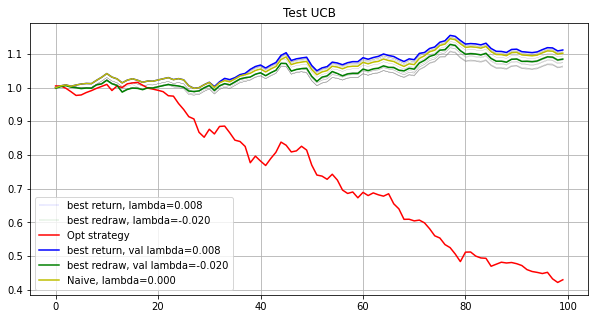

Phase 11
Validating...
./tmp2/res_phase11_iter8000_subn100_lb5.npz
Opt strategy
[0.0516 0.     0.     0.     0.     0.01   0.     0.     0.     0.
 0.     0.0297 0.     0.     0.     0.     0.     0.     0.0151 0.
 0.     0.0217 0.     0.073  0.     0.01   0.0427 0.     0.0032 0.
 0.     0.     0.     0.     0.064  0.012  0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.0432 0.     0.
 0.1005 0.     0.     0.     0.     0.     0.     0.0011 0.     0.
 0.     0.0344 0.     0.0389 0.     0.0648 0.     0.     0.     0.01
 0.     0.     0.     0.     0.     0.     0.     0.     0.083  0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.2495 0.     0.     0.     0.0413]
[ 0.0516 -0.     -0.     -0.     -0.      0.0018 -0.     -0.     -0.
 -0.      0.0081  0.0027  0.0157 -0.     -0.     -0.      0.0109 -0.
 -0.     -0.      0.0474 -0.     -0.      0.0007 -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.0028 0.     0.     0.     0.     0.     0.     0.
 0.0399 0.0254 0.     0.0122 0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.0971 0.     0.0037
 0.     0.     0.     0.     0.     0.     0.     0.0465 0.     0.186
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.1347 0.     0.     0.     0.1105 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.0853 0.
 0.     0.     0.     0.     0.0516 0.0606 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.1417 0.    ]
[0.     0.     0.     0.     0.     0.0465 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.0476 0.     0.     0.
 0.0399 0.0598 0.     0.     0.     0.     0.0329 0.     0.0055 0.
 0.     0.     0.     0.     0.0078 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.0864 0.     

[-0.     -0.     -0.     -0.     -0.     -0.     -0.      0.     -0.
 -0.      0.     -0.     -0.     -0.     -0.     -0.      0.     -0.
 -0.     -0.      0.     -0.      0.      0.0784 -0.      0.0891 -0.
 -0.      0.0048  0.     -0.     -0.     -0.     -0.      0.093   0.0004
 -0.      0.0291 -0.      0.0065  0.0012 -0.     -0.     -0.     -0.
  0.0041  0.     -0.     -0.      0.0998 -0.     -0.     -0.      0.
  0.1324 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.0142  0.0556 -0.     -0.     -0.     -0.     -0.      0.
  0.     -0.     -0.     -0.     -0.      0.02    0.0096  0.     -0.
 -0.     -0.     -0.      0.095  -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.2197 -0.     -0.      0.0438
 -0.    ]
[ 0.0396 -0.     -0.     -0.     -0.      0.0361 -0.      0.     -0.
 -0.      0.0211 -0.      0.008  -0.     -0.     -0.      0.0619 -0.
 -0.     -0.      0.0623 -0.      0.      0.012  -0.      0.     -0.
 -0.      0.    

[-0.     -0.      0.0001 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.0006 -0.      0.0161 -0.      0.0318  0.0068
 -0.     -0.      0.0823  0.0135 -0.      0.0014 -0.      0.0555 -0.
 -0.      0.0082 -0.     -0.     -0.     -0.     -0.     -0.      0.
 -0.      0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.0057 -0.     -0.      0.     -0.     -0.     -0.      0.0124
 -0.     -0.     -0.     -0.     -0.      0.0326 -0.      0.0936 -0.
 -0.     -0.      0.0607 -0.     -0.      0.0059 -0.     -0.      0.0742
 -0.     -0.     -0.     -0.     -0.     -0.      0.0213  0.031  -0.
  0.1785 -0.     -0.      0.0623  0.     -0.     -0.     -0.     -0.
  0.0243 -0.     -0.     -0.     -0.     -0.      0.     -0.      0.1636
  0.0129]
[ 0.      0.      0.      0.      0.      0.0088  0.      0.      0.
  0.      0.      0.      0.      0.      0.     -0.      0.      0.
  0.      0.      0.      0.      0.      0.0482 -0.      0.      0.
  0.    

[0.0384 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.1042 0.0777 0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.0344 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.1234 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.0612 0.     0.     0.     0.     0.
 0.     0.1757 0.     0.     0.     0.2392 0.     0.     0.     0.
 0.     0.0775 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.0614 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[0.     0.     0.0035 0.     0.     0.0361 0.     0.0064 0.     0.
 0.0491 0.     0.0042 0.     0.0081 0.     0.     0.     0.     0.
 0.     0.     0.     0.0376 0.     0.     0.     0.     0.     0.0639
 0.     0.     0.     0.     0.0322 0.     0.0191 0.     0.     0.0034
 0.     0.     0.     0.     0.0207 0.0704 0.0522

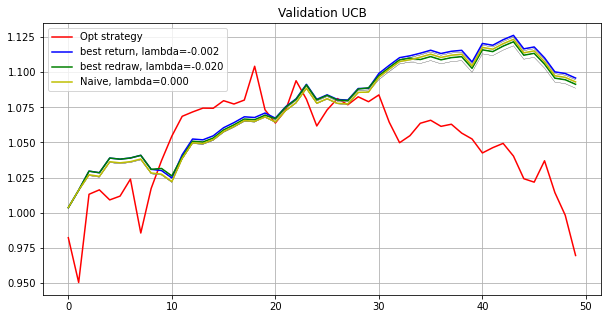

Testing...
./tmp2/res_phase11_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.00655404    Max redraw: 0.03963933
lambda: -0.018   Total log return: 0.00334525    Max redraw: 0.04059558
lambda: -0.016   Total log return: 0.00335113    Max redraw: 0.04059558
lambda: -0.014   Total log return: 0.00373069    Max redraw: 0.04059558
lambda: -0.012   Total log return: 0.00750634    Max redraw: 0.04059558
lambda: -0.010   Total log return: 0.00599503    Max redraw: 0.04059558
lambda: -0.008   Total log return: 0.00500325    Max redraw: 0.04059558
lambda: -0.006   Total log return: 0.00408816    Max redraw: 0.04059558
lambda: -0.004   Total log return: 0.00354523    Max redraw: 0.04059558
lambda: -0.002   Total log return: 0.00347971    Max redraw: 0.04059558
lambda: -0.000   Total log return: 0.00521187    Max redraw: 0.04059558
lambda: 0.002   Total log return: 0.00314349    Max redraw: 0.04059558
lambda: 0.004   Total log return: 0.00588208    Max redraw: 0.0408738

[-0.      0.     -0.      0.      0.      0.0193  0.      0.      0.
  0.      0.0166  0.0516 -0.      0.     -0.      0.     -0.      0.
  0.0259  0.     -0.      0.0438 -0.     -0.      0.     -0.      0.0568
 -0.      0.      0.      0.      0.      0.      0.      0.1171  0.0122
  0.     -0.      0.     -0.      0.      0.      0.      0.     -0.
  0.0529 -0.      0.081   0.     -0.      0.0152  0.      0.      0.0094
  0.0565 -0.      0.     -0.      0.      0.      0.     -0.     -0.
  0.009   0.      0.038   0.      0.     -0.      0.      0.     -0.
  0.0004  0.0653  0.      0.      0.      0.0668  0.0001  0.0474  0.
 -0.      0.0418  0.      0.1714 -0.      0.      0.      0.      0.
  0.      0.     -0.      0.      0.      0.      0.      0.     -0.
 -0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.1389 -0.
 -0.     -0.      0.0483 -0.     -0.      0.0438 -0.     -0.     -0.
 -0.     -0.

[ 0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0018 -0.
 -0.     -0.     -0.      0.     -0.     -0.     -0.      0.     -0.
 -0.      0.      0.0642  0.      0.      0.0162 -0.     -0.      0.
 -0.      0.     -0.     -0.      0.     -0.     -0.     -0.     -0.
 -0.      0.     -0.      0.002  -0.     -0.     -0.     -0.     -0.
  0.0436  0.1595  0.083  -0.      0.0924 -0.     -0.      0.0048 -0.
 -0.      0.     -0.     -0.     -0.      0.     -0.      0.     -0.
 -0.      0.      0.0805  0.002  -0.      0.     -0.     -0.      0.
 -0.      0.      0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.0901 -0.      0.      0.      0.0935 -0.     -0.     -0.      0.0214
  0.017  -0.      0.0435 -0.     -0.      0.     -0.     -0.      0.1815
 -0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.0495  0.0139  0.0014  0.0212 -0.     -0.      0.0512
 -0.      0.

[ 0.0402 -0.      0.0026 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.0097  0.0044 -0.     -0.     -0.      0.0992 -0.
  0.0338  0.0023 -0.     -0.      0.018   0.0074 -0.     -0.      0.0079
 -0.      0.0062 -0.     -0.     -0.     -0.     -0.      0.0886  0.0142
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0581
 -0.      0.018   0.0563 -0.      0.0059  0.0137 -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.0345 -0.     -0.     -0.
 -0.     -0.      0.0398  0.0069 -0.     -0.     -0.      0.0121  0.0162
 -0.     -0.     -0.     -0.     -0.     -0.      0.0862 -0.      0.0572
 -0.     -0.     -0.     -0.     -0.      0.0708 -0.     -0.     -0.
  0.0073 -0.      0.0763 -0.     -0.      0.1016 -0.     -0.     -0.
 -0.    ]
[ 0.0519 -0.      0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.      0.0044  0.     -0.     -0.      0.     -0.
  0.      0.      0.032   0.0228  0.      0.0151  0.     -0.      0.0229


[ 0.0396 -0.      0.      0.     -0.      0.0357 -0.      0.     -0.
 -0.      0.0344  0.      0.0022 -0.      0.      0.      0.      0.1148
  0.      0.      0.      0.0233  0.      0.     -0.      0.      0.0693
 -0.      0.0015  0.0171  0.      0.     -0.     -0.      0.0187  0.0415
  0.0328  0.     -0.      0.     -0.     -0.      0.0041 -0.      0.
  0.      0.      0.0313  0.      0.0027  0.0753  0.0117  0.      0.
  0.      0.     -0.      0.      0.      0.0424 -0.      0.0081  0.
 -0.      0.0007  0.037  -0.      0.      0.     -0.      0.      0.1178
  0.      0.      0.      0.     -0.      0.      0.      0.0493  0.
  0.      0.      0.     -0.      0.     -0.      0.      0.      0.1404
  0.     -0.     -0.      0.     -0.      0.0305 -0.      0.      0.
  0.0114]
[ 0.041  -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.0061 -0.      0.0259 -0.      0.0325 -0.
  0.0306 -0.      0.0256  0.0057 -0.     -0.     -0.     -0.      0.0431


[ 0.0565  0.0017 -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.     -0.      0.0152 -0.
  0.0074 -0.     -0.      0.019  -0.     -0.     -0.     -0.     -0.
 -0.      0.0002  0.0668 -0.     -0.     -0.     -0.      0.1005 -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.      0.0047 -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.1402 -0.     -0.      0.0065 -0.     -0.     -0.      0.134  -0.
  0.0059 -0.      0.3    -0.     -0.     -0.     -0.      0.      0.1246
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.      0.0092 -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[ 0.0626 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.0087 -0.     -0.      0.     -0.      0.0841 -0.
  0.0246  0.0004  0.0711 -0.     -0.      0.0513 -0.     -0.     -0.
 -0.      0.0018 -0.

[ 0.0149 -0.      0.0114 -0.     -0.      0.0009 -0.     -0.     -0.
 -0.      0.0256 -0.     -0.     -0.     -0.     -0.      0.1411 -0.
 -0.     -0.     -0.      0.0024 -0.      0.0322 -0.     -0.     -0.
 -0.      0.0029 -0.     -0.     -0.     -0.     -0.     -0.      0.0148
 -0.     -0.     -0.     -0.     -0.     -0.      0.0141 -0.     -0.
  0.0847 -0.     -0.     -0.     -0.     -0.      0.0154 -0.      0.0014
  0.183  -0.     -0.     -0.     -0.     -0.     -0.      0.026   0.
 -0.     -0.      0.0236 -0.     -0.     -0.     -0.      0.0041  0.
 -0.      0.0613 -0.     -0.     -0.     -0.      0.1579 -0.     -0.
  0.0899 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0143
 -0.     -0.     -0.      0.0637 -0.      0.0051  0.     -0.      0.
 -0.    ]
[ 0.0302 -0.      0.0002 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0688 -0.
  0.0241 -0.     -0.      0.0024 -0.      0.0221 -0.     -0.      0.009
 -0.     

[ 0.0418 -0.      0.0018 -0.     -0.      0.0355 -0.     -0.     -0.
 -0.     -0.     -0.      0.0144 -0.     -0.     -0.      0.0631  0.0435
  0.0165  0.     -0.     -0.      0.0055 -0.     -0.     -0.     -0.
 -0.      0.0114  0.0837 -0.      0.014  -0.     -0.     -0.      0.0316
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0008
 -0.     -0.      0.0111 -0.     -0.     -0.     -0.     -0.      0.019
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0398 -0.
 -0.     -0.      0.0743  0.0398 -0.     -0.      0.0074 -0.      0.0707
 -0.      0.1593 -0.     -0.     -0.     -0.     -0.      0.0145 -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0375
 -0.     -0.     -0.      0.152  -0.     -0.     -0.     -0.     -0.
 -0.    ]
[ 0.0519  0.      0.0129  0.      0.      0.0022  0.      0.0038  0.
  0.      0.     -0.      0.0234  0.      0.      0.      0.0015  0.0412
  0.      0.      0.0303  0.0188  0.      0.0011  0.      0.      

[ 0.      0.      0.      0.      0.      0.0403  0.      0.0029  0.
  0.      0.      0.      0.0034  0.      0.      0.      0.      0.0198
  0.      0.      0.068   0.0036  0.0075  0.0217  0.      0.      0.
  0.      0.0017  0.      0.      0.      0.      0.0048  0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.0945
  0.      0.      0.0593  0.      0.      0.      0.      0.      0.
 -0.      0.      0.      0.      0.      0.      0.      0.0258  0.
  0.      0.      0.      0.      0.      0.0197  0.      0.      0.104
  0.      0.203   0.      0.      0.      0.0043  0.      0.      0.
  0.      0.      0.      0.03    0.0115  0.      0.      0.      0.0015
  0.      0.      0.      0.26    0.      0.      0.      0.      0.
  0.    ]
[ 0.0665  0.      0.      0.      0.      0.      0.      0.0029  0.
  0.      0.      0.      0.0034  0.      0.      0.      0.0314  0.
  0.      0.      0.0348  0.0036  0.      0.0104  0.      0.      0.
  0.     

[ 0.0186 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0829 -0.
 -0.     -0.      0.0396 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.     -0.     -0.     -0.     -0.      0.0871  0.
  0.0423  0.0337 -0.     -0.     -0.     -0.     -0.     -0.      0.0415
  0.     -0.     -0.     -0.      0.1698 -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.1164 -0.
 -0.     -0.      0.0766 -0.     -0.      0.0114 -0.     -0.     -0.
  0.     -0.     -0.     -0.     -0.     -0.      0.0501 -0.     -0.
 -0.     -0.      0.      0.0942 -0.     -0.     -0.     -0.     -0.
 -0.      0.     -0.      0.0987 -0.      0.0228 -0.     -0.     -0.
 -0.    ]
[ 0.      0.     -0.     -0.      0.     -0.     -0.      0.      0.
  0.     -0.     -0.     -0.      0.     -0.     -0.      0.0074  0.
  0.002  -0.      0.0369 -0.     -0.     -0.     -0.      0.0657 -0.
 -0.     -0.      0.

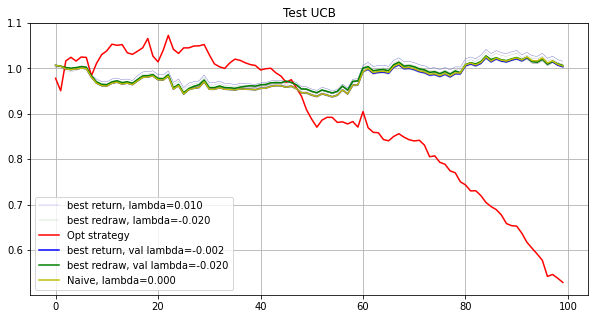

-----------------------------Final result-----------------------------
Opt strategy
Total return: 0.00738860
Mean return: 0.99388401
best return strategy
Total return: 1.91440952
Mean return: 1.00081209
best redraw strategy
Total return: 1.86537551
Mean return: 1.00077963
Naive strategy
Total return: 1.92961887
Mean return: 1.00082199


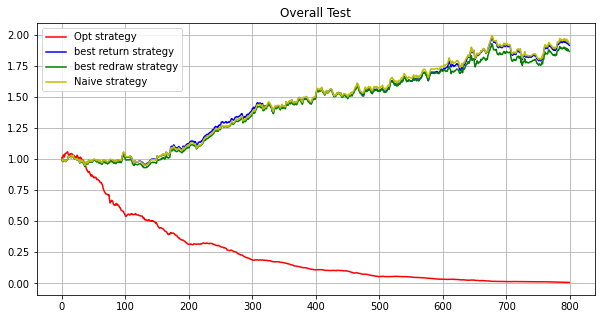

In [6]:
lb = 5
maxiter = 8000
subn = 100
path ='./tmp2/res_phase%02d_iter%d_subn%d_lb%d.npz'
gamma = 50
c = 0.0001
run(path, maxiter, subn, lb, testv=np.arange(-0.02, 0.0100001, 0.002), gamma=gamma, c=c)

Phase 4
Validating...
./tmp2/res_phase04_iter8000_subn100_lb5.npz
Opt strategy
[0.     0.     0.     0.     0.1284 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.3    0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.3
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.2704 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.  

[0.     0.     0.     0.3    0.3    0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.0999 0.     0.     0.     0.     0.
 0.3    0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[-0.     -0.     -0.      0.0698 -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.232  -0.     -0.     -0.     -0.      0.0294
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.2608 -0.     -0.     -0. 

[0.     0.     0.     0.     0.2431 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.1557 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.3
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.3    0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.
 -0.     -0.     -0.     -0.     -0.     -0.    

[-0.     -0.     -0.     -0.      0.3    -0.     -0.      0.07   -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0132 -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.0175 -0.     -0.
 -0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.3     0.0247 -0.     -0.     -0.      0.3
 -0.     -0.     -0.   

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.3    -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.1015 -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.     -0.     -0.     -0.      0.0536 -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.1573  0.217  -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.    

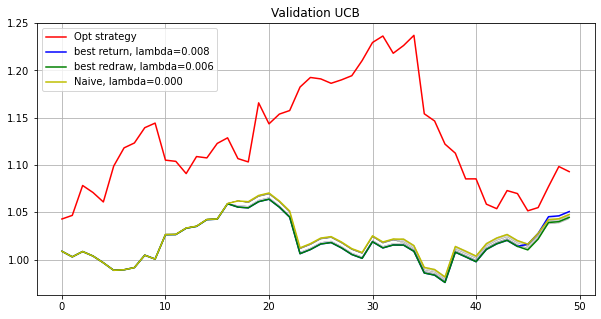

Testing...
./tmp2/res_phase04_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.01449593    Max redraw: 0.04741015
lambda: -0.018   Total log return: 0.01716019    Max redraw: 0.04741015
lambda: -0.016   Total log return: 0.02061541    Max redraw: 0.04741015
lambda: -0.014   Total log return: 0.02000184    Max redraw: 0.04741015
lambda: -0.012   Total log return: 0.01634502    Max redraw: 0.04741015
lambda: -0.010   Total log return: 0.01472589    Max redraw: 0.04741015
lambda: -0.008   Total log return: 0.01082606    Max redraw: 0.04741015
lambda: -0.006   Total log return: 0.01604362    Max redraw: 0.04741015
lambda: -0.004   Total log return: 0.02503168    Max redraw: 0.04741015
lambda: -0.002   Total log return: 0.03747112    Max redraw: 0.04741015
lambda: -0.000   Total log return: 0.03954515    Max redraw: 0.04741015
lambda: 0.002   Total log return: 0.04020998    Max redraw: 0.04741015
lambda: 0.004   Total log return: 0.03820739    Max redraw: 0.0474101

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.0972 0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.2907 0.0153
 0.     0.     0.     0.     0.     0.1097 0.1868 0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.3    0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.2
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.2002 -0.     -0.
 -0.     -0.      0.3    -0.     -0.     -0.

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.3    -0.     -0.     -0.
 -0.     -0.      0.0103 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.0903 -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0947
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.2719 0.     0.03

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.0358 -0.     -0.     -0.
 -0.     -0.      0.1756 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.0907  0.3    -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0991 -0.
 -0.     -0.     -0.     -0.     -0.      0.3    -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.3    0.0743 0.     0.     0.     0.     0.     0.     0.     0.
 0.0241 0.     0.     0.     0

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.2185 -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.0548 -0.     -0.
 -0.     -0.      0.0386 -0.      0.3    -0.     -0.     -0.     -0.
 -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0893 -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.3    -0.     -0.    

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.2774 0.3    0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.3    0.
 0.     0.     0.     0.     0.     0.     0.     0.1093 0.     0.
 0.     0.0119 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.1546 0.     0.
 0.     0.3    0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.0033 

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.0196 -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.0821 -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.3    -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.3    -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.     -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0088 -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.    

[0.     0.     0.     0.3    0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.1124 0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.1981 0.     0.0626
 0.     0.     0.     0.0336 0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.2923 0.     0.     0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.0745 0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.3    0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0. 

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0907
 -0.     -0.      0.1278 -0.     -0.     -0.     -0.     -0.      0.2163
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.1241 -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.1413 -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.0504 0.     0.
 0.     0.     0.     0.     0.     0.     0.0306 0.     0.     0.
 0.     0.     0.    

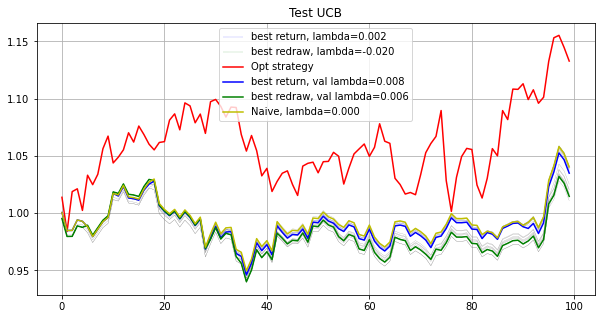

Phase 5
Validating...
./tmp2/res_phase05_iter8000_subn100_lb5.npz
Opt strategy
[0.     0.     0.0069 0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.0994 0.     0.     0.     0.
 0.     0.     0.     0.     0.0287 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.0322 0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.3    0.     0.     0.     0.     0.0784 0.     0.
 0.     0.     0.     0.     0.1877 0.     0.     0.     0.     0.
 0.     0.     0.103  0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.1421 0.     0.     0.     0.     0.     0.     0.     0.0207]
[0.     0.     0.3    0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.1867 0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.3    0.     0.     0.

[0.     0.     0.     0.     0.     0.     0.     0.     0.1458 0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.0203 0.     0.0059 0.     0.     0.     0.     0.
 0.0518 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.0536 0.     0.
 0.     0.     0.     0.     0.2266 0.     0.     0.     0.     0.
 0.     0.     0.     0.3    0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.1944 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[0.079  0.     0.1193 0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.0643 0.3    0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.3    0.     0.     0.
 0.     0.     0.0227 0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3
 -0.     -0.     -0.     -0.     -0.      0.2521 -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.0559 -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.2999 -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0936 -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.     -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.   

[ 0.0577 -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.1539
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.2955 -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.0141  0.1795 -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[0.     0.     0.3    0.1581 0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.1871 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.  

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.0387 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.3    0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.3    0.     0.     0.     0.     0.0256 0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.0347 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.3    0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0096
 0.     0.     0.     0.     0.     0.     0.     0.     0.3    0.
 0.     0.     0.     0.     0.     0.     0.     0.0

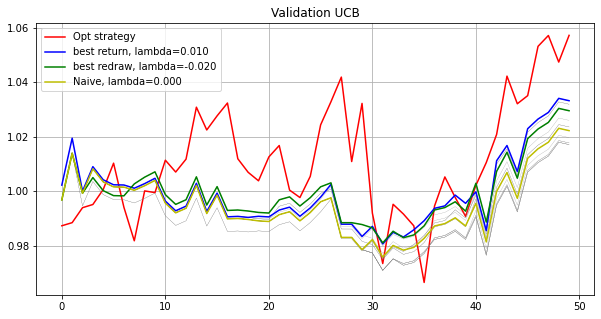

Testing...
./tmp2/res_phase05_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.09457053    Max redraw: 0.05127117
lambda: -0.018   Total log return: 0.09657663    Max redraw: 0.05127117
lambda: -0.016   Total log return: 0.07670235    Max redraw: 0.05127117
lambda: -0.014   Total log return: 0.06304404    Max redraw: 0.05127117
lambda: -0.012   Total log return: 0.06297960    Max redraw: 0.05127117
lambda: -0.010   Total log return: 0.07044942    Max redraw: 0.05127117
lambda: -0.008   Total log return: 0.07622245    Max redraw: 0.05127117
lambda: -0.006   Total log return: 0.07791816    Max redraw: 0.05127117
lambda: -0.004   Total log return: 0.07111208    Max redraw: 0.05129385
lambda: -0.002   Total log return: 0.07111208    Max redraw: 0.05129385
lambda: -0.000   Total log return: 0.06776157    Max redraw: 0.05129385
lambda: 0.002   Total log return: 0.07697366    Max redraw: 0.05129385
lambda: 0.004   Total log return: 0.07856000    Max redraw: 0.0497349

[ 0.      0.     -0.      0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.2046 -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.2271 -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.1591 -0.     -0.     -0.      0.2711 -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.0174 -0.     -0.     -0.      0.0901
 -0.     -0.     -0.     -0.     -0.      0.0306 -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3
 -0.     -0.     -0.     -0.     -0.      0.1416 -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0

[-0.     -0.      0.2119 -0.     -0.      0.      0.      0.     -0.
 -0.     -0.     -0.     -0.      0.     -0.      0.     -0.      0.0495
 -0.     -0.      0.      0.      0.      0.     -0.     -0.     -0.
 -0.      0.      0.     -0.      0.     -0.     -0.      0.      0.
 -0.      0.     -0.     -0.     -0.     -0.      0.      0.      0.
  0.      0.     -0.      0.      0.     -0.     -0.      0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.1386  0.     -0.      0.     -0.     -0.      0.     -0.
 -0.      0.     -0.     -0.      0.     -0.      0.      0.3    -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.     -0.     -0.     -0.     -0.      0.0522 -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.2971 -0.      0.0362 -0.     -0.     -0.     -0.      0.0834 -0.
 -0.     -0.     -0.

[0.     0.     0.     0.     0.     0.0052 0.     0.     0.     0.
 0.     0.     0.     0.     0.3    0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.1882
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.039  0.     0.1403 0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.3    0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.0264 0.     0.     0.     0.     0.     0.    ]
[0.0957 0.     0.3    0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.3    0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.3    0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0. 

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.0105 0.3    0.3    0.     0.     0.
 0.     0.0886 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.3    0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[ 0.167  -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.2374 -0.     

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.1008  0.1916 -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.2152 -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.3    -0.     -0.     -0.      0.0429 -0.     -0.      0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.1506 -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.0002 0.     0.     0.     0.     0.2309 0.     0.     0.     0.
 0.     0.3    0.     0.     0

[0.     0.     0.     0.0561 0.     0.     0.     0.     0.3    0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.3    0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.0619 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.1939 0.     0.087  0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[-0.     -0.      0.2812 -0.     -0.     -0.     -0.     -0.      0.3
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.    

[-0.     -0.      0.0016 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0968
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0763
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.1304 -0.      0.0343 -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.3    -0.      0.0611 -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.     -0.      0.0039 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.1157 -0.     -0.     -0.     -0.     -0.
 -0.     -0.    

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.0989 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.0006 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.3    0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.3    0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.3    0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.2399 -0.     -0.    

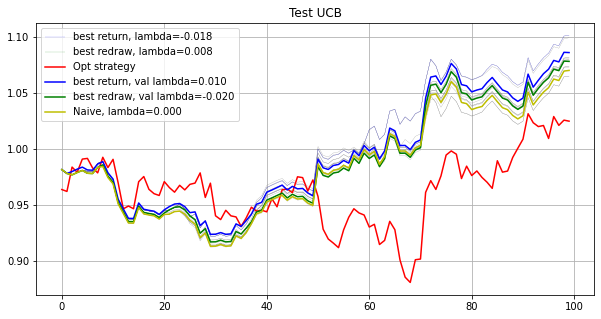

Phase 6
Validating...
./tmp2/res_phase06_iter8000_subn100_lb5.npz
Opt strategy
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.3     0.1725 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.0024 -0.     -0.     -0.     -0.     -0.      0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.2149 -0.     -0.     -0.     -0.     -0.     -0.      0.0001
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0568
 -0.     -0.      0.1113 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.1293 -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0131
 -0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.      0.     -0.
 -0.      0.      0.     -0.      0.     -0.      0.      0.     -0.
 -

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.0658 0.     0.     0.     0.0271 0.     0.     0.     0.2112 0.
 0.     0.     0.     0.0283 0.     0.     0.     0.     0.     0.1962
 0.     0.     0.     0.0722 0.     0.     0.0354 0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.3    0.     0.0625 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[-0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.1876  0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0. 

[-0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.
 -0.     0.3   -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.
 -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.     0.101
 -0.    -0.    -0.    -0.    -0.    -0.     0.3   -0.    -0.    -0.
 -0.    -0.    -0.    -0.     0.3   -0.    -0.    -0.    -0.    -0.
 -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.
 -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.
 -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.
 -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.
 -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.   ]
[-0.      0.205  -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.3    -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.3    -0.     -0.     -0.     -0. 

[0.     0.     0.     0.     0.1478 0.     0.     0.     0.     0.
 0.     0.3    0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.2518 0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.3    0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.2585 -0.     -0.     -0.
  0.2671 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     

[ 0.0029 -0.     -0.     -0.      0.2288 -0.     -0.     -0.     -0.
  0.15   -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.205  -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.0488 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.
 -0.     -0.      0.0659 -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.1414 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.2642 -0.     -0.    

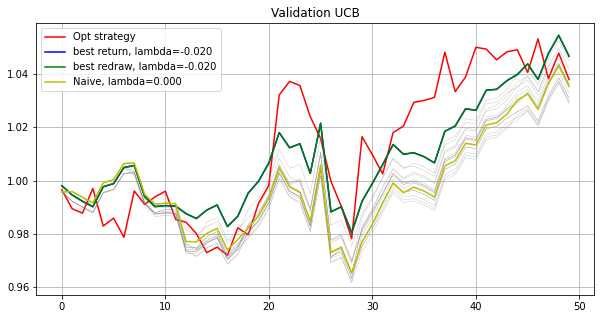

Testing...
./tmp2/res_phase06_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.20825661    Max redraw: 0.04421898
lambda: -0.018   Total log return: 0.20924816    Max redraw: 0.04421898
lambda: -0.016   Total log return: 0.21651083    Max redraw: 0.04421898
lambda: -0.014   Total log return: 0.21232723    Max redraw: 0.04421898
lambda: -0.012   Total log return: 0.21022755    Max redraw: 0.04421898
lambda: -0.010   Total log return: 0.20631076    Max redraw: 0.04421898
lambda: -0.008   Total log return: 0.20639946    Max redraw: 0.04421898
lambda: -0.006   Total log return: 0.20400683    Max redraw: 0.04421898
lambda: -0.004   Total log return: 0.19399370    Max redraw: 0.04421898
lambda: -0.002   Total log return: 0.20301120    Max redraw: 0.04421898
lambda: -0.000   Total log return: 0.20169129    Max redraw: 0.04421898
lambda: 0.002   Total log return: 0.19245404    Max redraw: 0.04421898
lambda: 0.004   Total log return: 0.18825244    Max redraw: 0.0442189

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.0605 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.0867 -0.     -0.     -0.     -0.     -0.     -0.
  0.0512  0.0279 -0.     -0.      0.1608 -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.1161 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.3     0.0475 -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.017  -0.     -0.     -0.      0.1338 -0.     -0.     -0.
 -0.    ]
[-0.      0.0901 -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.1932 -0.
 -0.     -0.     -0.    

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.083  0.     0.     0.1706 0.     0.3    0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.0065 0.     0.
 0.     0.     0.     0.     0.3    0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.1392 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.0548 0.     0.     0.
 0.236  0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.2989 0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.2155 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.2608 -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.1816 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.0109 -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.0326 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[0.     0.1086 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     

[0.     0.0505 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.3    0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.1783 0.     0.     0.     0.     0.     0.2541
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.2158 0.     0.     0.     0.     0.     0.     0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.0561 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0. 

[-0.     -0.     -0.     -0.      0.0392 -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.2425 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.0925 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.1109 -0.     -0.      0.106  -0.
 -0.      0.1435 -0.     -0.     -0.     -0.     -0.     -0.      0.0427
 -0.     -0.     -0.     -0.      0.0716 -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.1036 -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.0489 -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.3    -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.

[-0.      0.2247 -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.1019 -0.     -0.
 -0.      0.189  -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.1852 -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.1111 0.3    0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0731
 0.     0.     0.     0.2

[-0.      0.2031 -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.     -0.     -0.      0.1738 -0.      0.0124 -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.0109 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.0461 -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.
 -0.     -0.     -0.   

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.1006 0.     0.     0.     0.     0.     0.     0.3    0.     0.
 0.1509 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.3    0.     0.     0.     0.     0.     0.
 0.     0.0918 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.0557 0.     0.     0.     0.     0.     0.     0.     0.    ]
[0.1241 0.     0.     0.     0.018  0.     0.     0.     0.     0.
 0.1304 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.1641 0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     

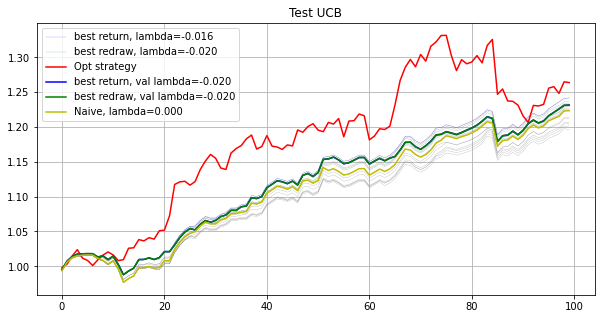

Phase 7
Validating...
./tmp2/res_phase07_iter8000_subn100_lb5.npz
Opt strategy
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.3    0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.3    0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.0996 0.3
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[ 0.0178 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.1109 -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.  

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.166  -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.1288 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0584 -0.
 -0.      0.0469 -0.     -0.     -0.     -0.      0.3    -0.     -0.
 -0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.0762 0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.2035 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0

[0.     0.     0.     0.     0.0929 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.1142
 0.     0.     0.     0.     0.     0.     0.     0.3    0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.0449 0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.037  0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.3    0.     0.     0.     0.     0.     0.     0.
 0.018  0.     0.     0.     0.     0.0923 0.     0.     0.     0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0696
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.2194 0.     0.     0.     0.     0.     0.     0.     0.     0.1462
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.1698 0.     0.     0.     0.

[-0.     -0.     -0.     -0.     -0.      0.0412 -0.     -0.     -0.
  0.0603 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.139  -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.2604  0.118  -0.     -0.
 -0.     -0.     -0.      0.0505 -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.1692
 -0.     -0.      0.1622 -0.     -0.     -0.     -0.      0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.1004 -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.1341
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.0164 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.0211 0.     0.     0.     0.     0.1032 0.     0.
 0.     0.     0.0238 0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.3    0.     0.     0.     0.     0.0864 0.0001
 0.     0.     0.     0.     0.     0.     0.     0.     0.3    0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0144]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.0385 0.     0.     0.     0.     0.1657
 0.     0.     0.     0.     0.3    0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.

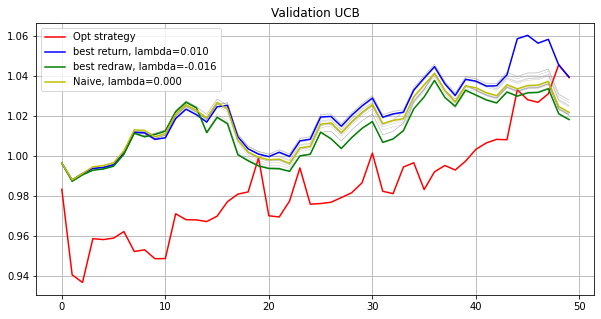

Testing...
./tmp2/res_phase07_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.09307256    Max redraw: 0.04027295
lambda: -0.018   Total log return: 0.09204683    Max redraw: 0.04117268
lambda: -0.016   Total log return: 0.09059912    Max redraw: 0.04117268
lambda: -0.014   Total log return: 0.09027487    Max redraw: 0.04117268
lambda: -0.012   Total log return: 0.09337694    Max redraw: 0.04117268
lambda: -0.010   Total log return: 0.09945863    Max redraw: 0.04027295
lambda: -0.008   Total log return: 0.10300035    Max redraw: 0.04027295
lambda: -0.006   Total log return: 0.10895820    Max redraw: 0.04027295
lambda: -0.004   Total log return: 0.10850160    Max redraw: 0.04027295
lambda: -0.002   Total log return: 0.10397950    Max redraw: 0.04027295
lambda: -0.000   Total log return: 0.09492290    Max redraw: 0.03980353
lambda: 0.002   Total log return: 0.09419810    Max redraw: 0.03980353
lambda: 0.004   Total log return: 0.07958077    Max redraw: 0.0398035

[0.0009 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.266  0.     0.     0.     0.     0.0075
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.1256
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.3    0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.3    0.     0.     0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.0042 0.
 0.1375 0.     0.     0.     0.     0.     0.     0.     0.     0.025
 0.     0.     0.3    0.     0.     0.     0.     0.     0.3    0.
 0.     0.     0.     0.     0.     0.     0. 

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.3    -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.0702 -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0314 -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3     0.3
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[0.0739 0.     0.     0.     0.     0.0789 0.     0.     0.     0.
 0.     0.0471 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.0141 0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.1921
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.0258 0.     0.175  0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.3    0.     0.     0.022  0.     0.     0.
 0.     0.     0.     0.     0.     0.2847 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.1213
 0.     0.     0.     0.     0.     0.1763 0.     0.     0.     0.
 0.     0.0953 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.1576 0.     0.     0.     0.    

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.0767 -0.     -0.     -0.     -0.     -0.      0.2106 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0793
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0685 -0.
 -0.     -0.      0.0631  0.0533 -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.1491 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0262
 0.     0.     0.     

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.3    -0.     -0.     -0.      0.0487 -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.1763 -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.176  -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.3    

[ 0.0339  0.1889  0.      0.      0.      0.      0.      0.      0.
  0.074   0.      0.      0.      0.0672  0.      0.      0.      0.
  0.      0.      0.2347  0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.0722  0.      0.
  0.      0.      0.0249  0.      0.      0.      0.      0.      0.1334
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.0001  0.      0.      0.      0.      0.
  0.      0.     -0.      0.      0.1694  0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0477
 0.     0.     0.     0.     0.     0.     0.     0.     0.2734 0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.2544 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.0445 -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.3     0.1011 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[ 0.1384 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.2123 -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.    

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.0452 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.2661
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.278  0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.3    0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.1093 0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.1863 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.1898 -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0. 

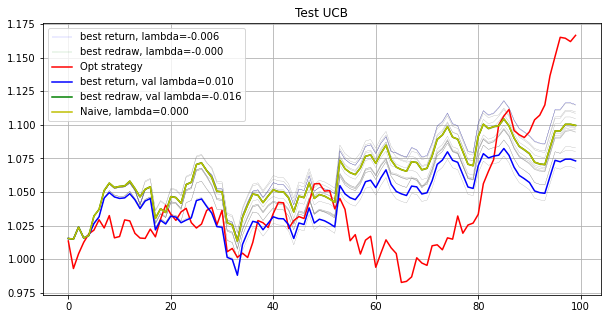

Phase 8
Validating...
./tmp2/res_phase08_iter8000_subn100_lb5.npz
Opt strategy
[0.     0.     0.1055 0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.0696 0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.3    0.     0.     0.     0.     0.3
 0.     0.224  0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.2071 -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.  

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.037
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.0644  0.3    -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.3    -0.     -0.     -0.
 -0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.3
 0.     0.     0.     0.  

[0.     0.     0.     0.0151 0.     0.     0.     0.     0.     0.
 0.0325 0.     0.0519 0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.0085 0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.0912 0.     0.
 0.     0.     0.     0.     0.1556 0.     0.     0.0024 0.     0.
 0.     0.     0.     0.     0.     0.0978 0.     0.     0.     0.
 0.3    0.     0.     0.     0.     0.     0.     0.     0.     0.0567
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.1175 0.     0.     0.     0.     0.0694 0.     0.     0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.2254 -0.     -0.      0.0384 -0.      0.3
 -0.     -0.     -0.     -0.     -0.     -0.

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.177  -0.     -0.      0.2543 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.3    -0.     -0.     -0.
 -0.     -0.      0.0933  0.0947 -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.0809 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[0.     0.     0.0594 0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.0064 0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.3
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.1383 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.3    0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.1112 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.1499 0.     0.     0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.    

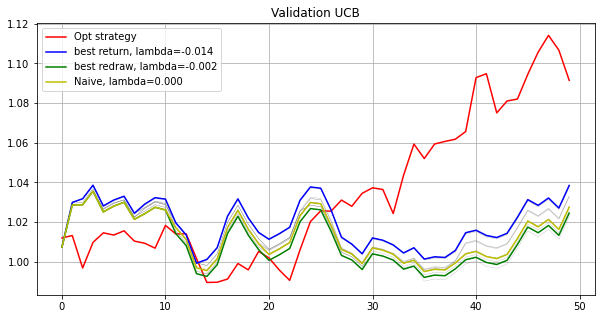

Testing...
./tmp2/res_phase08_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.04178553    Max redraw: 0.04154353
lambda: -0.018   Total log return: 0.04178553    Max redraw: 0.04154353
lambda: -0.016   Total log return: 0.04548496    Max redraw: 0.04154353
lambda: -0.014   Total log return: 0.04087616    Max redraw: 0.04154353
lambda: -0.012   Total log return: 0.03717725    Max redraw: 0.04154353
lambda: -0.010   Total log return: 0.04226571    Max redraw: 0.04154353
lambda: -0.008   Total log return: 0.04410808    Max redraw: 0.04154353
lambda: -0.006   Total log return: 0.04088311    Max redraw: 0.04154353
lambda: -0.004   Total log return: 0.04586607    Max redraw: 0.04154353
lambda: -0.002   Total log return: 0.04682497    Max redraw: 0.04154353
lambda: -0.000   Total log return: 0.04745435    Max redraw: 0.04154353
lambda: 0.002   Total log return: 0.04386840    Max redraw: 0.04154353
lambda: 0.004   Total log return: 0.05685098    Max redraw: 0.0415435

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.1012 -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.3    -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[0.     0.     0.0122 0.0291 0.0187 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.2003
 0.     0.     0.     0.     0.2502 0.     0.     0.     0.     0.
 0.     0.     0.     0.  

[0.     0.     0.     0.     0.     0.     0.     0.     0.1089 0.
 0.     0.088  0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.3    0.     0.3    0.
 0.     0.1774 0.     0.     0.0257 0.     0.     0.     0.     0.    ]
[0.     0.     0.0846 0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.0143 0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.3    0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.1255 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.3    0.     0.     0.
 0.     0.     0.     0.     0.2739 0.3    0.     0.     0.     0.    ]
[-0.     -0.      0.2202 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.1814 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.0698 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.2996 -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.3    -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.0927 -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.239
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.3

[ 0.0074 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.0266 -0.     -0.      0.0665 -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.
  0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[0.     0.     0.0216 0.     0.     0.     0.     0.     0.     0.0322
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.3    0.     0.     0.     0.     0.
 0.     0.     0.     0.  

[0.3    0.     0.     0.     0.     0.     0.     0.     0.     0.1746
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.224  0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.3    0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.0046 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.3

[0.     0.     0.0024 0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.1035 0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.0028 0.     0.0539 0.     0.     0.3    0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.0628 0.     0.     0.3    0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.1637 0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.0097 0.     0.     0.     0.     0.     0.     0.     0.    ]
[0.     0.     0.0467 0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.1179 0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.2916
 0.1421 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0. 

[-0.     -0.      0.0427 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.0421 -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.2415
 -0.     -0.     -0.      0.2359 -0.     -0.     -0.     -0.     -0.
  0.2575 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.181  -0.     -0.
 -0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.

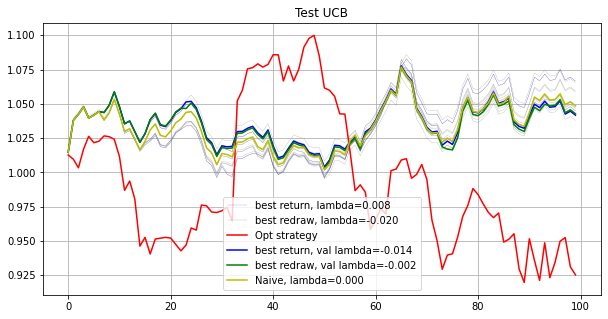

Phase 9
Validating...
./tmp2/res_phase09_iter8000_subn100_lb5.npz
Opt strategy
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.2694 -0.
 -0.     -0.     -0.     -0.     -0.      0.1146 -0.     -0.     -0.
 -0.      0.0171 -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.      0.1091 -0.     -0.     -0.     -0.      0.2071 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.     -0.
 -0.     -0.  

[-0.      0.1075 -0.     -0.     -0.     -0.     -0.      0.3    -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.0033 -0.     -0.     -0.     -0.     -0.      0.0427 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.2964 -0.     -0.     -0.      0.0139 -0.     -0.     -0.      0.2375
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.     -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.1523 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.3    0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.2316 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.3    0.     0.     0.0146 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[0.     0.1587 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.0811 0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.0005 0.     0.     0.     0.     0.     0.     

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.3    0.1893 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.0669 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.1423 0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.3    0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0455 -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.155  -0.     -0.     -0.     -0.     -0.      0.0677
 -0.     -0.     -0.     -0.     -0.      0.3    -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0. 

[-0.      0.0002 -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.2028 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.0188 -0.     -0.     -0.     -0.     -0.
  0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.2244 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.2552 -0.     -0.
 -0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.0831 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0

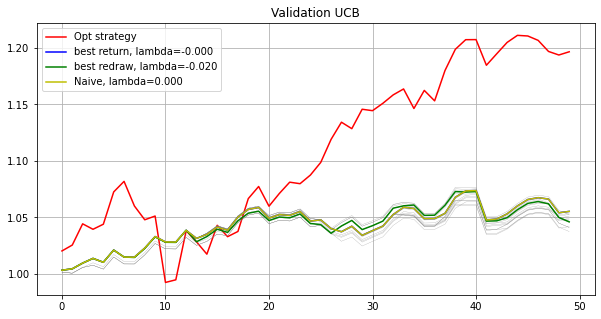

Testing...
./tmp2/res_phase09_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.09169513    Max redraw: 0.03340976
lambda: -0.018   Total log return: 0.09705971    Max redraw: 0.03340976
lambda: -0.016   Total log return: 0.08685545    Max redraw: 0.03340976
lambda: -0.014   Total log return: 0.09649924    Max redraw: 0.03340976
lambda: -0.012   Total log return: 0.09522997    Max redraw: 0.03340976
lambda: -0.010   Total log return: 0.10101991    Max redraw: 0.03267943
lambda: -0.008   Total log return: 0.10152567    Max redraw: 0.03267943
lambda: -0.006   Total log return: 0.10408528    Max redraw: 0.03267943
lambda: -0.004   Total log return: 0.10237535    Max redraw: 0.03267943
lambda: -0.002   Total log return: 0.10357638    Max redraw: 0.03267943
lambda: -0.000   Total log return: 0.10357638    Max redraw: 0.03267943
lambda: 0.002   Total log return: 0.10785830    Max redraw: 0.03267943
lambda: 0.004   Total log return: 0.10442110    Max redraw: 0.0326794

[-0.      0.1045 -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.2962 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.0295 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.0395 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.072  0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.2338 0.     0.     0.     0.     0.     0.     0.
 0.0392 0.     0.     0.     0.     0.     0.     0.     0.0523 0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.2018 0.     0.0024 0.     0.     0.0881
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.0791 0.     0.     0.     0.     0.     0.     0.1909]
[-0.      0.041  -0.     -0.     -0.     -0.      0.0147 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.29   -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.0551 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.3    -0.     -0.     -0.     -0. 

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0985  0.1166
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.1865 -0.
 -0.     -0.     -0.     -0.     -0.      0.3    -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.     -0.
 -0.    ]
[0.     0.     0.     0.     0.     0.     0.1551 0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.1224 0.     0.     0.     0.     0.
 0.     0.     0.     0.  

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.0237 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.0779 -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.3     0.3    -0.     -0.     -0.     -0.
  0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[0.     0.0743 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.1118 0.     0

[0.     0.1671 0.     0.2828 0.     0.     0.0256 0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.1977 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.0265 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.3    0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.0879 0.     0.     0.     0.     0.     0.049  0.     0.     0.
 0.     0.     0.2886 0.     0.0034 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     

[0.     0.     0.     0.     0.     0.     0.274  0.     0.     0.
 0.024  0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.3    0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.0545 0.     0.     0.
 0.     0.     0.     0.     0.2227 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.1233 0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.0779 0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.0988 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.0254 -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.2682 -0.      0.0077
 -0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0582  0.0456
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.1763 -0.      0.0294
 -0.     -0

[-0.      0.182  -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.      0.1013
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.1177 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.     -0.
 -0.    ]
[0.     0.     0.     0.3    0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.012  0.  

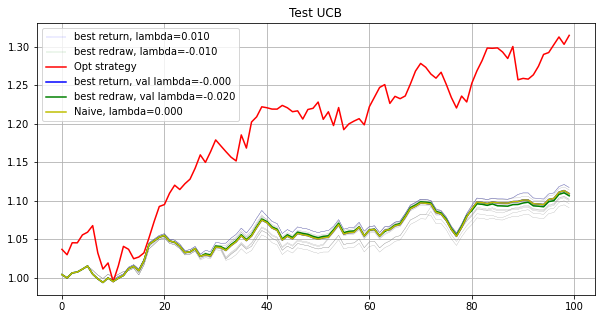

Phase 10
Validating...
./tmp2/res_phase10_iter8000_subn100_lb5.npz
Opt strategy
[-0.     -0.      0.0678 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.1454 -0.     -0.     -0.     -0.      0.3    -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.1877 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0. 

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.2801 -0.     -0.     -0.     -0.
 -0.     -0.      0.3    -0.     -0.     -0.     -0.      0.066  -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.283  -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0722 -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0602 -0.
 -0.     -0.     -0.    

[-0.     -0.      0.1463 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.1845  0.1048 -0.     -0.
 -0.     -0.      0.2649 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.     -0.     -0.     -0.      0.3    -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.    

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.1009 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.1753 0.     0.     0.     0.
 0.0944 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.2044 -0.     -0.     -0.
 -0.     -0.      0.3    -0.     -0.     -0.     -0.      0.0986 -0.
 -0.     -0.     -0.     -0.      0.3    -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.0985 -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.0271 0.0101 0.     0.0001 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.2137 0.     0.     0.     0.
 0.     0.     0.     0.     0

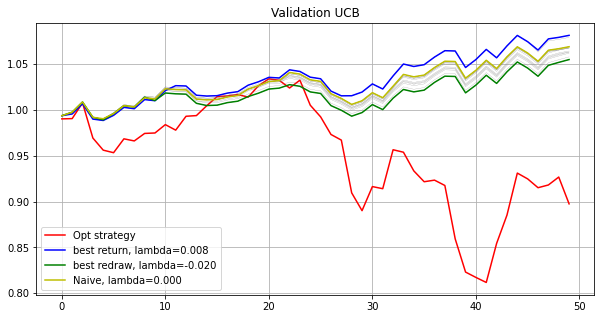

Testing...
./tmp2/res_phase10_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.08116028    Max redraw: 0.04229200
lambda: -0.018   Total log return: 0.08348685    Max redraw: 0.04229200
lambda: -0.016   Total log return: 0.06238050    Max redraw: 0.04229200
lambda: -0.014   Total log return: 0.06048604    Max redraw: 0.04229200
lambda: -0.012   Total log return: 0.06024048    Max redraw: 0.04229200
lambda: -0.010   Total log return: 0.05893089    Max redraw: 0.04229200
lambda: -0.008   Total log return: 0.07108065    Max redraw: 0.04229200
lambda: -0.006   Total log return: 0.07304868    Max redraw: 0.04229200
lambda: -0.004   Total log return: 0.07828324    Max redraw: 0.04229200
lambda: -0.002   Total log return: 0.08972199    Max redraw: 0.04229200
lambda: -0.000   Total log return: 0.09715899    Max redraw: 0.04229200
lambda: 0.002   Total log return: 0.09687345    Max redraw: 0.04229200
lambda: 0.004   Total log return: 0.10057098    Max redraw: 0.0422920

[0.     0.     0.1239 0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.3    0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.1736 0.     0.     0.     0.     0.102  0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.3    0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.3    0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.0984 0.     0.     

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.032  -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.1833 -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.0368 -0.     -0.     -0.     -0.     -0.     -0.      0.1496
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.     -0.      0.1713 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.
 -0.     -0.     -0.

[-0.     -0.      0.1003 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.3    -0.     -0.     -0.     -0.     -0.     -0.      0.0001 -0.
 -0.    ]
[0.     0.     0.     0.     0.1925 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.1124 -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.289  -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.    

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.1203 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.3    -0.     -0.     -0.     -0.      0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.2812 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.0541 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.1486 0.     0.     0.     0.
 0.     0.     0.     0.     0

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.008  0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.3    0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.0909 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.3    0.     0.3    0.     0.     0.     0.     0.     0.     0.    ]
[0.     0.     0.     0.     0.0428 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.3    0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     

[0.     0.     0.0468 0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.3    0.     0.     0.     0.     0.1861 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.1655 0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.3
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.    

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.092  0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.3    0.     0.     0.     0.
 0.     0.0124 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.3
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.294  0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[0.     0.     0.0661 0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.3    0.0927 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.    

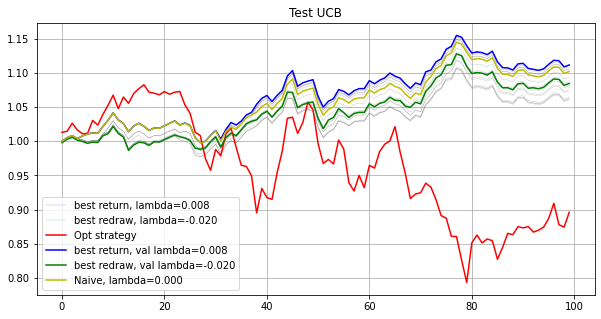

Phase 11
Validating...
./tmp2/res_phase11_iter8000_subn100_lb5.npz
Opt strategy
[ 0.2464 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.1169 -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0379 -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.3    -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.3    -0.     -0.     -0.
 -0.    ]
[0.1714 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.1449 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.3    0.     0.     0.     0.     0.     0.     0.     0.2541
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.3    0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0335 -0.
 -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0891
 -0.     -0.     -0.     -0.     -0.     

[ 0.1177 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.211  -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.0724 -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.
 -0.    ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.      0.2739 -0.     -0.     -0.
 -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.1272 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.2637
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.

[0.     0.     0.     0.     0.     0.006  0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.3
 0.     0.     0.     0.     0.2727 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.1209 0.     0.     0.3    0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.1753 -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.1396 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.    

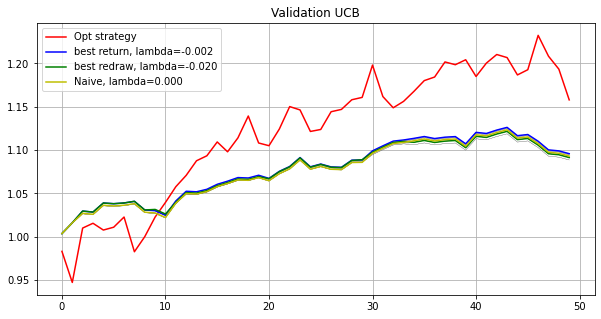

Testing...
./tmp2/res_phase11_iter8000_subn100_lb5.npz
UCB strategy
lambda: -0.020   Total log return: 0.00655404    Max redraw: 0.03963933
lambda: -0.018   Total log return: 0.00334525    Max redraw: 0.04059558
lambda: -0.016   Total log return: 0.00335113    Max redraw: 0.04059558
lambda: -0.014   Total log return: 0.00373069    Max redraw: 0.04059558
lambda: -0.012   Total log return: 0.00750634    Max redraw: 0.04059558
lambda: -0.010   Total log return: 0.00599503    Max redraw: 0.04059558
lambda: -0.008   Total log return: 0.00500325    Max redraw: 0.04059558
lambda: -0.006   Total log return: 0.00408816    Max redraw: 0.04059558
lambda: -0.004   Total log return: 0.00354523    Max redraw: 0.04059558
lambda: -0.002   Total log return: 0.00347971    Max redraw: 0.04059558
lambda: -0.000   Total log return: 0.00521187    Max redraw: 0.04059558
lambda: 0.002   Total log return: 0.00314349    Max redraw: 0.04059558
lambda: 0.004   Total log return: 0.00588208    Max redraw: 0.0408738

[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.1277 -0.     -0.      0.2728 -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.1082 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0

[0.2134 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.3    0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0056
 0.     0.     0.     0.     0.3    0.     0.     0.0708 0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.0432 0.     0.     0.     0.     0.     0.0568
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0098
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[ 0.0766 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.3    -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.025  -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.
 -0.     -0.     -0.     -0.     -0. 

[ 0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.3    -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.      0.1008 -0.     -0.     -0.     -0.
  0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.    

[ 0.2687 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.2297 -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
  0.1922 -0.     -0.     -0.      0.3    -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.0108 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[0.3    0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.0556 0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0

[0.3    0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.2194 0.     0.     0.     0.     0.     0.1153 0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.1077 0.
 0.0277 0.     0.     0.     0.     0.     0.     0.     0.     0.2286
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[-0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0. 

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.3    0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.1179 0.     0.
 0.     0.     0.     0.     0.     0.     0.1631 0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.118  0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.3    0.     0.     0.     0.     0.     0.    ]
[0.1284 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.27   0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     

[ 0.3    -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0563
 -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.1098 -0.
  0.0614 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.      0.2367  0.048  -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.      0.0851
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.      0.1027 -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.    ]
[ 0.0085 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.     -0.
 -0.     -0.    

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.0578 0.     0.     0.     0.3    0.     0.     0.     0.     0.
 0.     0.     0.     0.0117 0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.3    0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.0322 0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.1906 0.     0.     0.     0.1068 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
[0.1121 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     

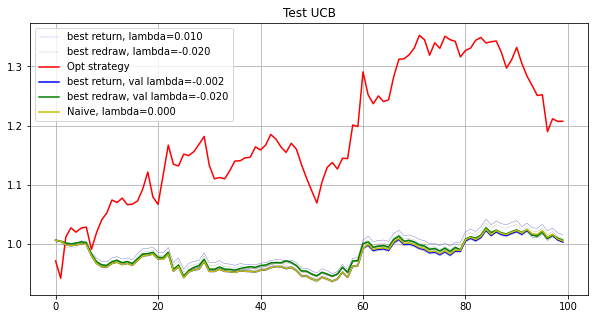

-----------------------------Final result-----------------------------
Opt strategy
Total return: 2.25270200
Mean return: 1.00101568
best return strategy
Total return: 1.91440952
Mean return: 1.00081209
best redraw strategy
Total return: 1.86537551
Mean return: 1.00077963
Naive strategy
Total return: 1.92961887
Mean return: 1.00082199


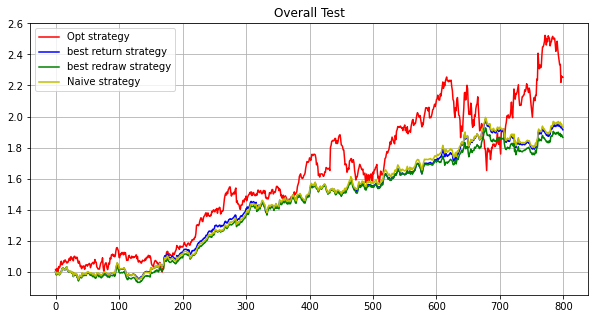

In [5]:
lb = 5
maxiter = 8000
subn = 100
path ='./tmp2/res_phase%02d_iter%d_subn%d_lb%d.npz'
gamma = 5
c = 0
run(path, maxiter, subn, lb, testv=np.arange(-0.02, 0.0100001, 0.002), gamma=gamma, c=c)